# Tel-Aviv Deep Learning Boot-camp: 12 Applied Deep Learning Labs

## Lab 0: Plant Seedlings Classification (PyTorch): The most basic lab :)  

<img src="../assets/seedlings.png" align="center">

### Instructors:

- Shlomo Kashani: shlomo@bayesian.io ,
- Nathaniel Shimoni nathaniel.shimoni@grid4c.com 

<img src="../assets/pt.jpg" width="35%" align="center">

## Progress

- [x] PyTorch DataSet
- [x] PyTorch DataLoader
- [x] Augmentations
- [x] Simple CNN
- [x] Training + train test split
- [x] TensorBoard Support from PyTorch
- [x] Accuray and Log Loss
- [x] Tqdm progress
- [x] Persisting the model
- [x] Testing on a test set



### Links:

- https://www.meetup.com/Tel-Aviv-Deep-Learning-Bootcamp/ 
- Git: https://github.com/bayesianio/applied-dl-2018
- Full info: https://www.evernote.com/shard/s341/sh/3855640e-2b0b-42e5-b5b9-00216d02ac9a/b47968226e49a81ee813901cd41d3924

### Date and Location: 
- July 2018


### Requirements:
- Python 3.5, CUDA 9, cuDNN 7, PyTorch 2.0 or above, Keras 2 or above

#### For Windows 10 and Windows Server 2016, CUDA 9
`conda install -c peterjc123 pytorch cuda90`


### Data
- Download: https://www.kaggle.com/c/plant-seedlings-classification

- Please make sure you have already set up a Pytorch tree structure of your dataset:
- `data_dir= '/home/data/bone/train/' `

```
    data_dir= '/home/data/bone/train/
    
    ├── valid
    │   └── Type_1
        ├── Type_2
        └── Type_3
    └── train
        ├── Type_1
        ├── Type_2
        └── Type_3
```

### PyTorch Datasets

To create a dataset, we subclass Dataset and define a constructor, a `__len__` method, and a `__getitem__` method. 
Here is full example:

```python
class BoneDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx, 0] # file name
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname).convert('RGB')
        labels = self.labels.iloc[idx, 2] # category_id
        if self.transform:
            image = self.transform(image)
        return image, labels
```

### The PyTorch DataLoader Class¶
- Will load our BoneDataset
- Can be regarded as a list (or iterator, technically).
- Each time it is invoked will provide a minibatch of (img, label) pairs.


### Training with TensorBoard

With the aid of [Crayon](https://github.com/torrvision/crayon),
we can access the visualisation power of TensorBoard for any 
deep learning framework.

To use the TensorBoard, install Crayon (https://github.com/torrvision/crayon)
and set `use_tensorboard = True`

In [11]:
%reset -f 

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 


%matplotlib inline
import matplotlib.pyplot as plt
import time
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random 
from tqdm import tqdm


import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

use_cuda = torch.cuda.is_available()
# use_cuda = False

print("USE CUDA=" + str (use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

manualSeed = None
def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if manualSeed is None:
        manualSeed = 999
fixSeed(manualSeed)

__Python VERSION: 3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]
__pyTorch VERSION: 0.3.1
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176
__CUDNN VERSION: 7005
__Number CUDA Devices: 2
__Devices
Active CUDA Device: GPU 0
Available devices  2
Current cuda device  0
USE CUDA=True


### Define Custom Dataset

In [12]:
class BoneDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx, 0] # file name
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname).convert('RGB')
        labels = self.labels.iloc[idx, 2] # category_id
#         print (labels)
        if self.transform:
            image = self.transform(image)
        return image, labels
    

import os


data_dir= 'd:/db/data/bone/train/'
data_dir= 'd:/db/data/cat-dog/train/'
data_dir= '/home/data/sidlings/train/'

def find_classes(fullDir):
    classes = [d for d in os.listdir(fullDir) if os.path.isdir(os.path.join(fullDir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    num_to_class = dict(zip(range(len(classes)), classes))
    
    train = []
    for index, label in enumerate(classes):
        path = fullDir + label + '/'
        for file in listdir(path):
            train.append(['{}/{}'.format(label, file), label, index])
    
    df = pd.DataFrame(train, columns=['file', 'category', 'category_id',]) 

    return classes, class_to_idx, num_to_class, df

classes, class_to_idx, num_to_class, df =find_classes (data_dir )


# class_to_idx
# num_to_class
df.head(5)    

,file,category,category_id
0,Black-grass/0fe440ed5.png,Black-grass,0
1,Black-grass/595e77ddf.png,Black-grass,0
2,Black-grass/b024eeb75.png,Black-grass,0
3,Black-grass/3f268bcf8.png,Black-grass,0
4,Black-grass/c1ab59648.png,Black-grass,0


In [13]:
len(classes)

12

# Augmentation 
- Many of the code snippts here were adapted from various github repos.
- If you dont need augementation, just skip this part.

In [14]:
from __future__ import absolute_import

from torchvision.transforms import *

from PIL import Image, ImageDraw
import numpy as np
import torch

import torchvision
import random
from PIL import Image, ImageOps
import numpy as np
import numbers
import math
import torch
import torch
import random
import PIL.ImageEnhance as ie
import PIL.Image as im

# adapted from https://github.com/kuangliu/pytorch-retinanet/blob/master/transform.py
# https://github.com/mratsim/Amazon-Forest-Computer-Vision/blob/master/src/p_data_augmentation.py

normalize_img = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

def draw(img, boxes):
    draw = ImageDraw.Draw(img)
    for box in boxes:
        draw.rectangle(list(box), outline='red')
    img.show()


class Stack(object):

    def __init__(self, roll=False):
        self.roll = roll

    def __call__(self, img_group):
        if img_group[0].mode == 'L':
            return np.concatenate([np.expand_dims(x, 2) for x in img_group], axis=2)
        elif img_group[0].mode == 'RGB':
            if self.roll:
                return np.concatenate([np.array(x)[:, :, ::-1] for x in img_group], axis=2)
            else:
                return np.concatenate(img_group, axis=2)


class ToTorchFormatTensor(object):
    """ Converts a PIL.Image (RGB) or numpy.ndarray (H x W x C) in the range [0, 255]
    to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] """
    def __init__(self, div=True):
        self.div = div

    def __call__(self, pic):
        if isinstance(pic, np.ndarray):
            # handle numpy array
            img = torch.from_numpy(pic).permute(2, 0, 1).contiguous()
        else:
            # handle PIL Image
            img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
            img = img.view(pic.size[1], pic.size[0], len(pic.mode))
            # put it from HWC to CHW format
            # yikes, this transpose takes 80% of the loading time/CPU
            img = img.transpose(0, 1).transpose(0, 2).contiguous()
        return img.float().div(255) if self.div else img.float()


class IdentityTransform(object):

    def __call__(self, data):
        return data

class RandomErasing(object):
    def __init__(self, EPSILON = 0.5, sl = 0.02, sh = 0.4, r1 = 0.3, mean=[0.4914, 0.4822, 0.4465]):
        self.EPSILON = EPSILON
        self.mean = mean
        self.sl = sl
        self.sh = sh
        self.r1 = r1
       
    def __call__(self, img):

        if random.uniform(0, 1) > self.EPSILON:
            return img

        for attempt in range(100):
            area = img.size()[1] * img.size()[2]
       
            target_area = random.uniform(self.sl, self.sh) * area
            aspect_ratio = random.uniform(self.r1, 1/self.r1)

            h = int(round(math.sqrt(target_area * aspect_ratio)))
            w = int(round(math.sqrt(target_area / aspect_ratio)))

            if w <= img.size()[2] and h <= img.size()[1]:
                x1 = random.randint(0, img.size()[1] - h)
                y1 = random.randint(0, img.size()[2] - w)
                if img.size()[0] == 3:
                    #img[0, x1:x1+h, y1:y1+w] = random.uniform(0, 1)
                    #img[1, x1:x1+h, y1:y1+w] = random.uniform(0, 1)
                    #img[2, x1:x1+h, y1:y1+w] = random.uniform(0, 1)
                    img[0, x1:x1+h, y1:y1+w] = self.mean[0]
                    img[1, x1:x1+h, y1:y1+w] = self.mean[1]
                    img[2, x1:x1+h, y1:y1+w] = self.mean[2]
                    #img[:, x1:x1+h, y1:y1+w] = torch.from_numpy(np.random.rand(3, h, w))
                else:
                    img[0, x1:x1+h, y1:y1+w] = self.mean[1]
                    # img[0, x1:x1+h, y1:y1+w] = torch.from_numpy(np.random.rand(1, h, w))
                return img

        return img

def random_crop(img, boxes):
    '''Crop the given PIL image to a random size and aspect ratio.
    A crop of random size of (0.08 to 1.0) of the original size and a random
    aspect ratio of 3/4 to 4/3 of the original aspect ratio is made.
    Args:
      img: (PIL.Image) image to be cropped.
      boxes: (tensor) object boxes, sized [#ojb,4].
    Returns:
      img: (PIL.Image) randomly cropped image.
      boxes: (tensor) randomly cropped boxes.
    '''
    success = False
    for attempt in range(10):
        area = img.size[0] * img.size[1]
        target_area = random.uniform(0.56, 1.0) * area
        aspect_ratio = random.uniform(3. / 4, 4. / 3)

        w = int(round(math.sqrt(target_area * aspect_ratio)))
        h = int(round(math.sqrt(target_area / aspect_ratio)))

        if random.random() < 0.5:
            w, h = h, w

        if w <= img.size[0] and h <= img.size[1]:
            x = random.randint(0, img.size[0] - w)
            y = random.randint(0, img.size[1] - h)
            success = True
            break

    # Fallback
    if not success:
        w = h = min(img.size[0], img.size[1])
        x = (img.size[0] - w) // 2
        y = (img.size[1] - h) // 2

    img = img.crop((x, y, x+w, y+h))
    boxes -= torch.Tensor([x,y,x,y])
    boxes[:,0::2].clamp_(min=0, max=w-1)
    boxes[:,1::2].clamp_(min=0, max=h-1)
    return img, boxes


class Lighting(object):
    """Lighting noise(AlexNet - style PCA - based noise)"""

    def __init__(self, alphastd, eigval, eigvec):
        self.alphastd = alphastd
        self.eigval = eigval
        self.eigvec = eigvec

    def __call__(self, img):
        if self.alphastd == 0:
            return img

        alpha = img.new().resize_(3).normal_(0, self.alphastd)
        rgb = self.eigvec.type_as(img).clone() \
            .mul(alpha.view(1, 3).expand(3, 3)) \
            .mul(self.eigval.view(1, 3).expand(3, 3)) \
            .sum(1).squeeze()

        return img.add(rgb.view(3, 1, 1).expand_as(img))


class Grayscale(object):
    def __call__(self, img):
        gs = img.clone()
        gs[0].mul_(0.299).add_(0.587, gs[1]).add_(0.114, gs[2])
        gs[1].copy_(gs[0])
        gs[2].copy_(gs[0])
        return gs


class Saturation(object):
    def __init__(self, var):
        self.var = var

    def __call__(self, img):
        gs = Grayscale()(img)
        alpha = random.uniform(0, self.var)
        return img.lerp(gs, alpha)


class Brightness(object):
    def __init__(self, var):
        self.var = var

    def __call__(self, img):
        gs = img.new().resize_as_(img).zero_()
        alpha = random.uniform(0, self.var)
        return img.lerp(gs, alpha)


class Contrast(object):
    def __init__(self, var):
        self.var = var

    def __call__(self, img):
        gs = Grayscale()(img)
        gs.fill_(gs.mean())
        alpha = random.uniform(0, self.var)
        return img.lerp(gs, alpha)


class RandomOrder(object):
    """ Composes several transforms together in random order.
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        if self.transforms is None:
            return img
        order = torch.randperm(len(self.transforms))
        for i in order:
            img = self.transforms[i](img)
        return img


class ColorJitter(RandomOrder):
    def __init__(self, brightness=0.4, contrast=0.4, saturation=0.4):
        self.transforms = []
        if brightness != 0:
            self.transforms.append(Brightness(brightness))
        if contrast != 0:
            self.transforms.append(Contrast(contrast))
        if saturation != 0:
            self.transforms.append(Saturation(saturation))


class RandomFlip(object):
    """Randomly flips the given PIL.Image with a probability of 0.25 horizontal,
                                                                0.25 vertical,
                                                                0.5 as is
    """

    def __call__(self, img):
        dispatcher = {
            0: img,
            1: img,
            2: img.transpose(im.FLIP_LEFT_RIGHT),
            3: img.transpose(im.FLIP_TOP_BOTTOM)
        }

        return dispatcher[random.randint(0, 3)]  # randint is inclusive


class RandomRotate(object):
    """Randomly rotate the given PIL.Image with a probability of 1/6 90°,
                                                                 1/6 180°,
                                                                 1/6 270°,
                                                                 1/2 as is
    """

    def __call__(self, img):
        dispatcher = {
            0: img,
            1: img,
            2: img,
            3: img.transpose(im.ROTATE_90),
            4: img.transpose(im.ROTATE_180),
            5: img.transpose(im.ROTATE_270)
        }

        return dispatcher[random.randint(0, 5)]  # randint is inclusive


class PILColorBalance(object):
    def __init__(self, var):
        self.var = var

    def __call__(self, img):
        alpha = random.uniform(1 - self.var, 1 + self.var)
        return ie.Color(img).enhance(alpha)


class PILContrast(object):
    def __init__(self, var):
        self.var = var

    def __call__(self, img):
        alpha = random.uniform(1 - self.var, 1 + self.var)
        return ie.Contrast(img).enhance(alpha)


class PILBrightness(object):
    def __init__(self, var):
        self.var = var

    def __call__(self, img):
        alpha = random.uniform(1 - self.var, 1 + self.var)
        return ie.Brightness(img).enhance(alpha)


class PILSharpness(object):
    def __init__(self, var):
        self.var = var

    def __call__(self, img):
        alpha = random.uniform(1 - self.var, 1 + self.var)
        return ie.Sharpness(img).enhance(alpha)


# Check ImageEnhancer effect: https://www.youtube.com/watch?v=_7iDTpTop04
# Not documented but all enhancements can go beyond 1.0 to 2
# Image must be RGB
# Use Pillow-SIMD because Pillow is too slow
class PowerPIL(RandomOrder):
    def __init__(self, rotate=True,
                 flip=True,
                 colorbalance=0.4,
                 contrast=0.4,
                 brightness=0.4,
                 sharpness=0.4):
        self.transforms = []
        if rotate:
            self.transforms.append(RandomRotate())
        if flip:
            self.transforms.append(RandomFlip())
        if brightness != 0:
            self.transforms.append(PILBrightness(brightness))
        if contrast != 0:
            self.transforms.append(PILContrast(contrast))
        if colorbalance != 0:
            self.transforms.append(PILColorBalance(colorbalance))
        if sharpness != 0:
            self.transforms.append(PILSharpness(sharpness))

def default_loader(input_path):
    input_image = (Image.open(input_path)).convert('RGB')
    return input_image


## Setup transforms, datasets, and dataloaders

- Data loaders spit out data from a dataset in batches. This is what you actually feed the neural network during training.

In [15]:
image_size = 224

normalize_img = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


train_trans = transforms.Compose([
    transforms.RandomSizedCrop(image_size),
    PowerPIL(),
    transforms.ToTensor(),
#     normalize_img,
    RandomErasing()
])

## Normalization only for validation and test
valid_trans = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
#     normalize_img
])

batch_size = 16
train_data = df.sample(frac=0.85)
valid_data = df[~df['file'].isin(train_data['file'])]

train_set = BoneDataset(train_data, data_dir, transform = train_trans)
valid_set = BoneDataset(valid_data, data_dir, transform = valid_trans)
        

t_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
v_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=8)
# test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

dataset_sizes = {
    'train': len(t_loader.dataset), 
    'valid': len(v_loader.dataset)
}

print (dataset_sizes)

{'train': 4038, 'valid': 712}


/usr/local/lib/python3.5/dist-packages/torchvision/transforms/transforms.py:397: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")
/usr/local/lib/python3.5/dist-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


### Test the DataLoader Class

i=0: 
i=1: 
i=2: 
i=3: 


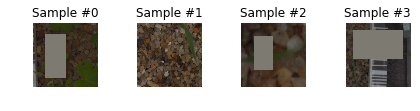

In [16]:
imagesToShow=4

def flaotTensorToImage(img, mean=0, std=1):
        """convert a tensor to an image"""
        img = np.transpose(img.numpy(), (1, 2, 0))
        img = (img*std+ mean)*255
        img = img.astype(np.uint8)    
        return img    

for i, data in enumerate(t_loader, 0):
    print('i=%d: '%(i))            
    images, labels = data            
    num = len(images)
    
    ax = plt.subplot(1, imagesToShow, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    
    for n in range(num):
        image=images[n]
        label=labels[n]
        plt.imshow (flaotTensorToImage(image))
        
    if i==imagesToShow-1:
        break

## Define the model
- A simple CNN with great performance (95% accuracy) 
- In PyTorch, a model is defined by a subclass of nn.Module. It has two methods:

`__init__:` constructor. Create layers here. Note that we don't define the connections between layers in this function.

`forward(x):` forward function. Receives an input variable x. Returns a output variable. Note that we actually connect the layers here dynamically.

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import math 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import numpy as np



# dropout = torch.nn.Dropout(p=0.75)
# relu=torch.nn.LeakyReLU()
# pool = nn.MaxPool2d(2, 2)

# class ConvRes(nn.Module):
#     def __init__(self,insize, outsize):
#         super(ConvRes, self).__init__()
#         drate = .3
#         self.math = nn.Sequential(
#                  nn.BatchNorm2d(insize),
#                  nn.Dropout(drate),
#                  torch.nn.Conv2d(insize, outsize, kernel_size=2,padding=2),
#                  nn.PReLU(),
#                 )
        
#     def forward(self, x):
#         return self.math(x) 

# class ConvCNN(nn.Module):
#     def __init__(self,insize, outsize, kernel_size=7, padding=2, pool=2, avg=True):
#         super(ConvCNN, self).__init__()
#         self.avg=avg
#         self.math = torch.nn.Sequential(
#             torch.nn.Conv2d(insize, outsize, kernel_size=kernel_size,padding=padding),
#             torch.nn.BatchNorm2d(outsize),
#             torch.nn.LeakyReLU(),
#             torch.nn.MaxPool2d(pool,pool),
#         )
#         self.avgpool=torch.nn.AvgPool2d(pool,pool)
        
#     def forward(self, x):
#         x=self.math(x)
#         if self.avg is True:
#             x=self.avgpool(x)
#         return x   
        
# class SimpleNet(nn.Module):
#     def __init__(self):
#         super(SimpleNet, self).__init__()        
        
#         self.avgpool = nn.AdaptiveAvgPool2d(1)
        
#         self.cnn1 = ConvCNN (3,64,  kernel_size=7, pool=4, avg=False)
#         self.cnn2 = ConvCNN (64,64, kernel_size=5, pool=2, avg=True)
#         self.cnn3 = ConvCNN (64,256, kernel_size=5, pool=2, avg=True)
#         self.cnn4 = ConvCNN (256,512, kernel_size=3, pool=1, avg=True)
        
#         self.res1 = ConvRes (64,64)
        
#         self.features = nn.Sequential( 
#             self.cnn1,dropout,          
#             self.cnn2,            
#             self.res1,
#         )        
        
#         self.classifier = torch.nn.Sequential(
#             nn.Linear(16384, len(classes)),             
#         )
# #         self.sig=nn.Sigmoid()        
            
#     def forward(self, x):
#         x = self.features(x) 
#         x = x.view(x.size(0), -1)        
# #         print (x.data.shape)
#         x = self.classifier(x)                
# #         x = self.sig(x)
#         return x        


import math

import torch.nn as nn
from torchvision.models import ResNet

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)


class SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, reduction=16):
        super(SEBasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, 1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.se = SELayer(planes, reduction)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class SEBottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, reduction=16):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se = SELayer(planes * 4, reduction)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


def se_resnet18(num_classes):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(SEBasicBlock, [2, 2, 2, 2], num_classes=num_classes)
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    return model


def se_resnet34(num_classes):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(SEBasicBlock, [3, 4, 6, 3], num_classes=num_classes)
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    return model


def se_resnet50(num_classes):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(SEBottleneck, [3, 4, 6, 3], num_classes=num_classes)
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    return model


def se_resnet101(num_classes):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(SEBottleneck, [3, 4, 23, 3], num_classes=num_classes)
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    return model


def se_resnet152(num_classes):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(SEBottleneck, [3, 8, 36, 3], num_classes=num_classes)
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    return model


REDUCTION=16

class SELayer(nn.Module):
    def __init__(self, channel, reduction=REDUCTION):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, reduction),
            # nn.ReLU(inplace=True),
            nn.PReLU(),
            nn.Linear(reduction, channel),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class IceSEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, reduction=REDUCTION):
        super(IceSEBasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, 1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.se = SELayer(planes, reduction)
        self.downsample = nn.Sequential(nn.Conv2d(inplanes, planes, kernel_size=1,
                                                  stride=1, bias=False),
                                        nn.BatchNorm2d(planes))

    def forward(self, x):
        residual = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)

        out += residual
        out = self.relu(out)

        return out


class IceResNet(nn.Module):
    def __init__(self, block, n_size=1, num_classes=1, num_rgb=2, base=32):
        super(IceResNet, self).__init__()
        self.base = base
        self.num_classes = num_classes
        self.inplane = self.base  # 45 epochs
        # self.inplane = 16 # 57 epochs
        self.conv1 = nn.Conv2d(num_rgb, self.inplane, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplane)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, self.inplane, blocks=2 * n_size, stride=2)
        self.layer2 = self._make_layer(block, self.inplane * 2, blocks=2 * n_size, stride=2)
        self.layer3 = self._make_layer(block, self.inplane * 4, blocks=2 * n_size, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Linear(int(8 * self.base), num_classes)
        nn.init.kaiming_normal(self.fc.weight)
        self.sig = nn.Sigmoid()

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride):

        layers = []
        for i in range(1, blocks):
            layers.append(block(self.inplane, planes, stride))
            self.inplane = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        # print (x.data.size())
        x = self.fc(x)

        if self.num_classes == 1:  # BCE Loss,
            x = self.sig(x)
        return x


def senet16_RGB_10_classes(num_classes=10, num_rgb=3):
    model = IceResNet(IceSEBasicBlock, 1, num_classes, num_rgb, 16)  # 56
    return model


def senet16_RG_1_classes(num_classes=1, num_rgb=2):
    model = IceResNet(IceSEBasicBlock, 1, num_classes, num_rgb, 16)  # 56
    return model


def senet32_RG_1_classes(num_classes=1, num_rgb=2):
    model = IceResNet(IceSEBasicBlock, 1, num_classes, num_rgb, 32)  # 56
    return model

def senet32_RGB_1_classes(num_classes=1, num_rgb=3):
    model = IceResNet(IceSEBasicBlock, 1, num_classes, num_rgb, 32)  # 56
    return model

def senet64_RG_1_classes(num_classes=1, num_rgb=2):
    model = IceResNet(IceSEBasicBlock, 1, num_classes, num_rgb, 64)  # 56
    return model


def senet128_RG_1_classes(num_classes=1, num_rgb=2):
    model = IceResNet(IceSEBasicBlock, 1, num_classes, num_rgb, 128)  # 56
    return model

def senetXX_generic(num_classes, num_rgb, base):
    model = IceResNet(IceSEBasicBlock, 1, num_classes, num_rgb, base)  # 56
    return model


# model = SimpleNet()
model = senetXX_generic(len(classes), 3, 32)

if use_cuda:
    model = model.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.00005 * 2 * 2)

model = torch.nn.DataParallel(model, device_ids=list(range(2)))

print (model)

DataParallel(
  (module): IceResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (layer1): Sequential(
      (0): IceSEBasicBlock(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
        (se): SELayer(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (fc): Sequential(
            (0): Linear(in_features=32, out_features=2, bias=True)
            (1): PReLU(num_parameters=1)
            (2): Linear(in_features=2, out_features=32, bias=True)
            (3): Sigmoid()
          )
        )
        (downsample): Sequential(
          (0): Conv2d(32, 32, 

# Metrics and Tensorboard

In [18]:
import datetime 
try:
    from pycrayon import CrayonClient
except ImportError:
    CrayonClient = None

# tensorboad
use_tensorboard = False
# use_tensorboard = True and CrayonClient is not None

if use_tensorboard == True:
    cc = CrayonClient(hostname='http://nec-gpu-2') # point to where you installed Crayon
#     cc.remove_all_experiments()
    
model_name = (type(model).__name__)
exp_name = datetime.datetime.now().strftime(model_name + '_' + 'bone' + '_%Y-%m-%d_%H-%M-%S')
if use_tensorboard == True:
    exp = cc.create_experiment(exp_name)    
    

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy2(y_pred, y_actual, topk=(1, )):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = y_actual.size(0)

    _, pred = y_pred.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(y_actual.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))

    return res
        

### Training

In [19]:
from tqdm import tqdm 
from sklearn import metrics
import torch
import numpy as np
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc

def train(train_loader, model, epoch, optimizer):
    if use_cuda:
        model.cuda()
        criterion.cuda()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()
   
    # switch to train mode
    model.train()

    end = time.time()
    for batch_idx, (images, target) in enumerate(train_loader): 
        correct = 0
        # measure data loading time
        data_time.update(time.time() - end)

        if use_cuda:
            images, target = images.cuda(), target.cuda()
            images, target = Variable(images), Variable(target)
        # compute y_pred
        y_pred = model(images)
        loss = criterion(y_pred, target)

        # measure accuracy and record loss
        prec1, prec1 = accuracy2(y_pred.data, target.data, topk=(1, 1))
        losses.update(loss.data[0], images.size(0))
        acc.update(prec1[0], images.size(0))
        
        pred = y_pred.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        accuracy = 100. * correct / len(images)
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if batch_idx % 100  == 0:
            print('TRAIN: LOSS-->{loss.val:.4f} ({loss.avg:.4f})\t' 'ACC-->{acc.val:.3f}% ({acc.avg:.3f}%)'.format(loss=losses, acc=acc))
            if use_tensorboard:
                exp.add_scalar_value('tr_epoch_loss', losses.avg, step=epoch)
                exp.add_scalar_value('tr_epoch_acc', acc.avg, step=epoch)
                
            print('TRAIN: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {}/{} ({:.3f}%)'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0],
                correct, len(images),
                accuracy))            
    

    return float('{loss.avg:.4f}'.format(loss=losses)), float('{acc.avg:.4f}'.format(acc=acc))

def validate(val_loader, model, epoch):
    if use_cuda:
        model.cuda()
        criterion.cuda()

    batch_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (images, labels) in enumerate(val_loader):

        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
            images, labels = Variable(images, volatile=True), Variable(labels)

        # compute y_pred
        y_pred = model(images)
        loss = criterion(y_pred, labels)

        # measure accuracy and record loss
        prec1, temp_var = accuracy2(y_pred.data, labels.data, topk=(1, 1))
        losses.update(loss.data[0], images.size(0))
        acc.update(prec1[0], images.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 100== 0:
            print('VAL:   LOSS--> {loss.val:.4f} ({loss.avg:.4f})\t''ACC-->{acc.val:.3f} ({acc.avg:.3f})'.format(loss=losses, acc=acc))

        if i % 50 == 0:
            if use_tensorboard:
                exp.add_scalar_value('val_epoch_loss', losses.avg, step=epoch)
                exp.add_scalar_value('val_epoch_acc', acc.avg, step=epoch)

    print(' * Accuracy {acc.avg:.4f}'.format(acc=acc))
    return float('{loss.avg:.6f}'.format(loss=losses)), float('{acc.avg:.6f}'.format(acc=acc))

test_trans = valid_trans
test_data_dir = '/home/data/sidlings/test/'

def testImageLoader(image_name):
    """load image, returns cuda tensor"""
#     image = Image.open(image_name)
    image = Image.open(image_name).convert('RGB')
    image = test_trans(image)
#     image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  
    if use_cuda:
#         print ("cuda")
        image.cuda()         
    return image  

def testModel(test_dir, local_model):    
    if use_cuda:
        local_model.cuda()
    
    local_model.eval()
    
    columns = ['file', 'species']
    df_pred = pd.DataFrame(data=np.zeros((0, len(columns))), columns=columns)
#     df_pred.species.astype(int)
    for index, row in (sample_submission.iterrows()):
#         for file in os.listdir(test_dir):            
        currImage=os.path.join(test_dir, row['file'])
        if os.path.isfile(currImage):
            X_tensor_test=testImageLoader (currImage)            
#             print (type(X_tensor_test))
            if use_cuda:
                X_tensor_test = Variable(X_tensor_test.cuda()) 
            else:
                X_tensor_test = Variable(X_tensor_test)        
            
            # get the index of the max log-probability
            predicted_val = (local_model(X_tensor_test)).data.max(1)[1] # get the index of the max log-probability
#             predicted_val = predicted_val.data.max(1, keepdim=True)[1]
            p_test = (predicted_val.cpu().numpy().item())
            df_pred = df_pred.append({'file': row['file'], 'species': num_to_class[int(p_test)]}, ignore_index=True)             
    
    return df_pred

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Train the model

In [20]:
sample_submission = pd.read_csv(data_dir + 'sample_submission.csv')
sample_submission.columns = ['file', 'species']
# sample_submission['category_id'] = 0
sample_submission.head(3)

if __name__ == '__main__':    
    print ("MODEL: {}".format( str(type(model).__name__)))
    for epoch in tqdm(range(0, 350)):        
        train(t_loader, model, epoch, optimizer)
        val_loss, val_accuracy= validate(v_loader, model, epoch)
        if float(val_accuracy) > float(90.0):            
            print ("EARLY STOP")
            df_pred=testModel(test_data_dir,model)
            df_pred.to_csv(str(type(model).__name__) + '_' + str(val_accuracy) + '_' + 
                           str(epoch) + "_sub.csv", columns=('file', 'species'), index=None)         
    

  0%|          | 0/350 [00:00<?, ?it/s]

MODEL: DataParallel
TRAIN: LOSS-->2.8390 (2.8390)	ACC-->6.250% (6.250%)
TRAIN: 0 [0/4038 (0%)]	Loss: 2.839008, Accuracy: 1/16 (6.250%)
TRAIN: LOSS-->1.8945 (2.1683)	ACC-->25.000% (26.052%)
TRAIN: 0 [1600/4038 (40%)]	Loss: 1.894536, Accuracy: 4/16 (25.000%)
TRAIN: LOSS-->1.7515 (2.0650)	ACC-->25.000% (29.167%)
TRAIN: 0 [3200/4038 (79%)]	Loss: 1.751483, Accuracy: 4/16 (25.000%)
VAL:   LOSS--> 1.6355 (1.6355)	ACC-->43.750 (43.750)


  0%|          | 1/350 [01:53<11:01:42, 113.76s/it]

 * Accuracy 46.6292
TRAIN: LOSS-->2.4791 (2.4791)	ACC-->18.750% (18.750%)
TRAIN: 1 [0/4038 (0%)]	Loss: 2.479146, Accuracy: 3/16 (18.750%)
TRAIN: LOSS-->1.9737 (1.8731)	ACC-->31.250% (38.428%)
TRAIN: 1 [1600/4038 (40%)]	Loss: 1.973740, Accuracy: 5/16 (31.250%)
TRAIN: LOSS-->1.9832 (1.8535)	ACC-->25.000% (38.993%)
TRAIN: 1 [3200/4038 (79%)]	Loss: 1.983231, Accuracy: 4/16 (25.000%)
VAL:   LOSS--> 1.2754 (1.2754)	ACC-->68.750 (68.750)


  1%|          | 2/350 [04:53<14:11:03, 146.73s/it]

 * Accuracy 52.1067
TRAIN: LOSS-->1.9860 (1.9860)	ACC-->25.000% (25.000%)
TRAIN: 2 [0/4038 (0%)]	Loss: 1.986030, Accuracy: 4/16 (25.000%)
TRAIN: LOSS-->1.7136 (1.7840)	ACC-->50.000% (41.337%)
TRAIN: 2 [1600/4038 (40%)]	Loss: 1.713586, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->1.4087 (1.7571)	ACC-->37.500% (42.009%)
TRAIN: 2 [3200/4038 (79%)]	Loss: 1.408694, Accuracy: 6/16 (37.500%)
VAL:   LOSS--> 1.4836 (1.4836)	ACC-->43.750 (43.750)


  1%|          | 3/350 [08:09<15:43:26, 163.13s/it]

 * Accuracy 56.6011
TRAIN: LOSS-->1.8854 (1.8854)	ACC-->37.500% (37.500%)
TRAIN: 3 [0/4038 (0%)]	Loss: 1.885351, Accuracy: 6/16 (37.500%)
TRAIN: LOSS-->1.7409 (1.7286)	ACC-->31.250% (42.698%)
TRAIN: 3 [1600/4038 (40%)]	Loss: 1.740894, Accuracy: 5/16 (31.250%)
TRAIN: LOSS-->1.2977 (1.7015)	ACC-->62.500% (43.626%)
TRAIN: 3 [3200/4038 (79%)]	Loss: 1.297737, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 1.4078 (1.4078)	ACC-->56.250 (56.250)


  1%|          | 4/350 [11:22<16:23:50, 170.61s/it]

 * Accuracy 58.8483
TRAIN: LOSS-->1.9925 (1.9925)	ACC-->25.000% (25.000%)
TRAIN: 4 [0/4038 (0%)]	Loss: 1.992454, Accuracy: 4/16 (25.000%)
TRAIN: LOSS-->1.7569 (1.6065)	ACC-->37.500% (47.153%)
TRAIN: 4 [1600/4038 (40%)]	Loss: 1.756927, Accuracy: 6/16 (37.500%)
TRAIN: LOSS-->1.9674 (1.6065)	ACC-->25.000% (46.922%)
TRAIN: 4 [3200/4038 (79%)]	Loss: 1.967366, Accuracy: 4/16 (25.000%)
VAL:   LOSS--> 0.7820 (0.7820)	ACC-->75.000 (75.000)


  1%|▏         | 5/350 [14:31<16:42:37, 174.37s/it]

 * Accuracy 60.6742
TRAIN: LOSS-->1.7055 (1.7055)	ACC-->43.750% (43.750%)
TRAIN: 5 [0/4038 (0%)]	Loss: 1.705452, Accuracy: 7/16 (43.750%)
TRAIN: LOSS-->1.7366 (1.5649)	ACC-->50.000% (49.196%)
TRAIN: 5 [1600/4038 (40%)]	Loss: 1.736638, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->2.0270 (1.5754)	ACC-->31.250% (47.948%)
TRAIN: 5 [3200/4038 (79%)]	Loss: 2.027021, Accuracy: 5/16 (31.250%)
VAL:   LOSS--> 1.2743 (1.2743)	ACC-->56.250 (56.250)


  2%|▏         | 6/350 [17:41<16:54:28, 176.94s/it]

 * Accuracy 60.6742
TRAIN: LOSS-->1.2060 (1.2060)	ACC-->62.500% (62.500%)
TRAIN: 6 [0/4038 (0%)]	Loss: 1.206024, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.2612 (1.5234)	ACC-->50.000% (48.515%)
TRAIN: 6 [1600/4038 (40%)]	Loss: 1.261155, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->1.6190 (1.5456)	ACC-->50.000% (48.041%)
TRAIN: 6 [3200/4038 (79%)]	Loss: 1.618956, Accuracy: 8/16 (50.000%)
VAL:   LOSS--> 1.0592 (1.0592)	ACC-->68.750 (68.750)


  2%|▏         | 7/350 [20:52<17:03:11, 178.99s/it]

 * Accuracy 58.5674
TRAIN: LOSS-->1.7480 (1.7480)	ACC-->50.000% (50.000%)
TRAIN: 7 [0/4038 (0%)]	Loss: 1.747956, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->1.5467 (1.5407)	ACC-->50.000% (49.691%)
TRAIN: 7 [1600/4038 (40%)]	Loss: 1.546712, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->1.3905 (1.5091)	ACC-->56.250% (50.373%)
TRAIN: 7 [3200/4038 (79%)]	Loss: 1.390549, Accuracy: 9/16 (56.250%)
VAL:   LOSS--> 1.2138 (1.2138)	ACC-->68.750 (68.750)


  2%|▏         | 8/350 [24:03<17:08:10, 180.38s/it]

 * Accuracy 64.7472
TRAIN: LOSS-->1.6542 (1.6542)	ACC-->50.000% (50.000%)
TRAIN: 8 [0/4038 (0%)]	Loss: 1.654229, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->1.3995 (1.4957)	ACC-->62.500% (49.752%)
TRAIN: 8 [1600/4038 (40%)]	Loss: 1.399511, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->2.2734 (1.4881)	ACC-->31.250% (50.404%)
TRAIN: 8 [3200/4038 (79%)]	Loss: 2.273449, Accuracy: 5/16 (31.250%)
VAL:   LOSS--> 1.0373 (1.0373)	ACC-->75.000 (75.000)


  3%|▎         | 9/350 [27:14<17:11:50, 181.56s/it]

 * Accuracy 65.5899
TRAIN: LOSS-->1.1941 (1.1941)	ACC-->62.500% (62.500%)
TRAIN: 9 [0/4038 (0%)]	Loss: 1.194077, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.3666 (1.4595)	ACC-->37.500% (52.908%)
TRAIN: 9 [1600/4038 (40%)]	Loss: 1.366591, Accuracy: 6/16 (37.500%)
TRAIN: LOSS-->1.2482 (1.4717)	ACC-->62.500% (51.990%)
TRAIN: 9 [3200/4038 (79%)]	Loss: 1.248194, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.9855 (0.9855)	ACC-->75.000 (75.000)


  3%|▎         | 10/350 [30:23<17:13:09, 182.32s/it]

 * Accuracy 62.5000
TRAIN: LOSS-->1.5348 (1.5348)	ACC-->56.250% (56.250%)
TRAIN: 10 [0/4038 (0%)]	Loss: 1.534773, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->1.6224 (1.4228)	ACC-->50.000% (54.022%)
TRAIN: 10 [1600/4038 (40%)]	Loss: 1.622395, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->1.4630 (1.4141)	ACC-->56.250% (54.011%)
TRAIN: 10 [3200/4038 (79%)]	Loss: 1.462978, Accuracy: 9/16 (56.250%)
VAL:   LOSS--> 0.7723 (0.7723)	ACC-->68.750 (68.750)


  3%|▎         | 11/350 [33:39<17:17:25, 183.62s/it]

 * Accuracy 65.3090
TRAIN: LOSS-->1.2273 (1.2273)	ACC-->56.250% (56.250%)
TRAIN: 11 [0/4038 (0%)]	Loss: 1.227304, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->1.4196 (1.3977)	ACC-->56.250% (53.527%)
TRAIN: 11 [1600/4038 (40%)]	Loss: 1.419575, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->1.4559 (1.4029)	ACC-->43.750% (54.104%)
TRAIN: 11 [3200/4038 (79%)]	Loss: 1.455940, Accuracy: 7/16 (43.750%)
VAL:   LOSS--> 0.8144 (0.8144)	ACC-->75.000 (75.000)


  3%|▎         | 12/350 [37:05<17:24:46, 185.46s/it]

 * Accuracy 62.5000
TRAIN: LOSS-->1.7694 (1.7694)	ACC-->37.500% (37.500%)
TRAIN: 12 [0/4038 (0%)]	Loss: 1.769377, Accuracy: 6/16 (37.500%)
TRAIN: LOSS-->1.2153 (1.4124)	ACC-->56.250% (53.775%)
TRAIN: 12 [1600/4038 (40%)]	Loss: 1.215349, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->1.3615 (1.3892)	ACC-->56.250% (54.757%)
TRAIN: 12 [3200/4038 (79%)]	Loss: 1.361538, Accuracy: 9/16 (56.250%)
VAL:   LOSS--> 1.0783 (1.0783)	ACC-->68.750 (68.750)


  4%|▎         | 13/350 [40:23<17:27:02, 186.42s/it]

 * Accuracy 68.5393
TRAIN: LOSS-->1.6220 (1.6220)	ACC-->43.750% (43.750%)
TRAIN: 13 [0/4038 (0%)]	Loss: 1.621998, Accuracy: 7/16 (43.750%)
TRAIN: LOSS-->1.1238 (1.3585)	ACC-->62.500% (54.084%)
TRAIN: 13 [1600/4038 (40%)]	Loss: 1.123770, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.6880 (1.3578)	ACC-->31.250% (54.198%)
TRAIN: 13 [3200/4038 (79%)]	Loss: 1.688015, Accuracy: 5/16 (31.250%)
VAL:   LOSS--> 0.6890 (0.6890)	ACC-->87.500 (87.500)


  4%|▍         | 14/350 [43:40<17:28:06, 187.16s/it]

 * Accuracy 71.3483
TRAIN: LOSS-->1.7300 (1.7300)	ACC-->37.500% (37.500%)
TRAIN: 14 [0/4038 (0%)]	Loss: 1.730010, Accuracy: 6/16 (37.500%)
TRAIN: LOSS-->1.1826 (1.3253)	ACC-->50.000% (56.436%)
TRAIN: 14 [1600/4038 (40%)]	Loss: 1.182570, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->1.5938 (1.3222)	ACC-->43.750% (56.374%)
TRAIN: 14 [3200/4038 (79%)]	Loss: 1.593798, Accuracy: 7/16 (43.750%)
VAL:   LOSS--> 1.0754 (1.0754)	ACC-->56.250 (56.250)


  4%|▍         | 15/350 [47:01<17:30:05, 188.08s/it]

 * Accuracy 71.2079
TRAIN: LOSS-->1.5748 (1.5748)	ACC-->50.000% (50.000%)
TRAIN: 15 [0/4038 (0%)]	Loss: 1.574822, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->1.1606 (1.2846)	ACC-->56.250% (57.426%)
TRAIN: 15 [1600/4038 (40%)]	Loss: 1.160580, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->1.3546 (1.3079)	ACC-->68.750% (57.058%)
TRAIN: 15 [3200/4038 (79%)]	Loss: 1.354623, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.9872 (0.9872)	ACC-->62.500 (62.500)


  5%|▍         | 16/350 [50:13<17:28:28, 188.35s/it]

 * Accuracy 68.6798
TRAIN: LOSS-->1.4171 (1.4171)	ACC-->50.000% (50.000%)
TRAIN: 16 [0/4038 (0%)]	Loss: 1.417082, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->1.4842 (1.2931)	ACC-->62.500% (56.002%)
TRAIN: 16 [1600/4038 (40%)]	Loss: 1.484193, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.0898 (1.2866)	ACC-->62.500% (57.152%)
TRAIN: 16 [3200/4038 (79%)]	Loss: 1.089792, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.5665 (0.5665)	ACC-->93.750 (93.750)


  5%|▍         | 17/350 [53:27<17:27:09, 188.68s/it]

 * Accuracy 71.2079
TRAIN: LOSS-->1.6239 (1.6239)	ACC-->50.000% (50.000%)
TRAIN: 17 [0/4038 (0%)]	Loss: 1.623906, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->1.0783 (1.2929)	ACC-->56.250% (55.879%)
TRAIN: 17 [1600/4038 (40%)]	Loss: 1.078333, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->1.3419 (1.2888)	ACC-->62.500% (57.214%)
TRAIN: 17 [3200/4038 (79%)]	Loss: 1.341923, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.7488 (0.7488)	ACC-->81.250 (81.250)


  5%|▌         | 18/350 [56:44<17:26:31, 189.13s/it]

 * Accuracy 70.2247
TRAIN: LOSS-->1.5470 (1.5470)	ACC-->37.500% (37.500%)
TRAIN: 18 [0/4038 (0%)]	Loss: 1.546969, Accuracy: 6/16 (37.500%)
TRAIN: LOSS-->1.3986 (1.2929)	ACC-->68.750% (55.507%)
TRAIN: 18 [1600/4038 (40%)]	Loss: 1.398565, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->1.1115 (1.2768)	ACC-->75.000% (56.841%)
TRAIN: 18 [3200/4038 (79%)]	Loss: 1.111464, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.9939 (0.9939)	ACC-->75.000 (75.000)


  5%|▌         | 19/350 [1:00:00<17:25:25, 189.50s/it]

 * Accuracy 64.6067
TRAIN: LOSS-->1.2289 (1.2289)	ACC-->68.750% (68.750%)
TRAIN: 19 [0/4038 (0%)]	Loss: 1.228932, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->1.2975 (1.2717)	ACC-->56.250% (58.045%)
TRAIN: 19 [1600/4038 (40%)]	Loss: 1.297489, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->1.3887 (1.2762)	ACC-->56.250% (57.929%)
TRAIN: 19 [3200/4038 (79%)]	Loss: 1.388670, Accuracy: 9/16 (56.250%)
VAL:   LOSS--> 1.0851 (1.0851)	ACC-->56.250 (56.250)


  6%|▌         | 20/350 [1:03:18<17:24:38, 189.93s/it]

 * Accuracy 69.3820
TRAIN: LOSS-->1.2952 (1.2952)	ACC-->50.000% (50.000%)
TRAIN: 20 [0/4038 (0%)]	Loss: 1.295248, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->1.2069 (1.2292)	ACC-->56.250% (58.045%)
TRAIN: 20 [1600/4038 (40%)]	Loss: 1.206866, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.9413 (1.2382)	ACC-->75.000% (58.551%)
TRAIN: 20 [3200/4038 (79%)]	Loss: 0.941322, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 1.3569 (1.3569)	ACC-->56.250 (56.250)


  6%|▌         | 21/350 [1:06:38<17:24:03, 190.40s/it]

 * Accuracy 68.5393
TRAIN: LOSS-->1.1629 (1.1629)	ACC-->50.000% (50.000%)
TRAIN: 21 [0/4038 (0%)]	Loss: 1.162912, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->0.9754 (1.2386)	ACC-->68.750% (58.354%)
TRAIN: 21 [1600/4038 (40%)]	Loss: 0.975366, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->1.2906 (1.2443)	ACC-->62.500% (57.836%)
TRAIN: 21 [3200/4038 (79%)]	Loss: 1.290604, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.8653 (0.8653)	ACC-->62.500 (62.500)


  6%|▋         | 22/350 [1:09:55<17:22:25, 190.69s/it]

 * Accuracy 69.6629
TRAIN: LOSS-->1.1034 (1.1034)	ACC-->75.000% (75.000%)
TRAIN: 22 [0/4038 (0%)]	Loss: 1.103427, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->1.0147 (1.2149)	ACC-->62.500% (60.953%)
TRAIN: 22 [1600/4038 (40%)]	Loss: 1.014728, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.9875 (1.2078)	ACC-->75.000% (60.852%)
TRAIN: 22 [3200/4038 (79%)]	Loss: 0.987450, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.9045 (0.9045)	ACC-->75.000 (75.000)


  7%|▋         | 23/350 [1:13:13<17:21:00, 191.01s/it]

 * Accuracy 73.4551
TRAIN: LOSS-->1.2700 (1.2700)	ACC-->62.500% (62.500%)
TRAIN: 23 [0/4038 (0%)]	Loss: 1.270026, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.2758 (1.2292)	ACC-->56.250% (59.715%)
TRAIN: 23 [1600/4038 (40%)]	Loss: 1.275776, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.9487 (1.2070)	ACC-->62.500% (59.950%)
TRAIN: 23 [3200/4038 (79%)]	Loss: 0.948746, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.9909 (0.9909)	ACC-->68.750 (68.750)


  7%|▋         | 24/350 [1:16:29<17:18:54, 191.21s/it]

 * Accuracy 72.0506
TRAIN: LOSS-->1.0439 (1.0439)	ACC-->68.750% (68.750%)
TRAIN: 24 [0/4038 (0%)]	Loss: 1.043886, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->1.0286 (1.2051)	ACC-->62.500% (60.829%)
TRAIN: 24 [1600/4038 (40%)]	Loss: 1.028570, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.4759 (1.1989)	ACC-->43.750% (60.417%)
TRAIN: 24 [3200/4038 (79%)]	Loss: 1.475935, Accuracy: 7/16 (43.750%)
VAL:   LOSS--> 1.5667 (1.5667)	ACC-->50.000 (50.000)


  7%|▋         | 25/350 [1:19:43<17:16:22, 191.33s/it]

 * Accuracy 67.4157
TRAIN: LOSS-->1.4042 (1.4042)	ACC-->43.750% (43.750%)
TRAIN: 25 [0/4038 (0%)]	Loss: 1.404209, Accuracy: 7/16 (43.750%)
TRAIN: LOSS-->1.0706 (1.1577)	ACC-->56.250% (61.634%)
TRAIN: 25 [1600/4038 (40%)]	Loss: 1.070568, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.9324 (1.1515)	ACC-->68.750% (62.127%)
TRAIN: 25 [3200/4038 (79%)]	Loss: 0.932351, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.7683 (0.7683)	ACC-->81.250 (81.250)


  7%|▋         | 26/350 [1:23:01<17:14:33, 191.59s/it]

 * Accuracy 71.6292
TRAIN: LOSS-->0.6649 (0.6649)	ACC-->81.250% (81.250%)
TRAIN: 26 [0/4038 (0%)]	Loss: 0.664853, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->1.2101 (1.1364)	ACC-->43.750% (60.087%)
TRAIN: 26 [1600/4038 (40%)]	Loss: 1.210147, Accuracy: 7/16 (43.750%)
TRAIN: LOSS-->1.1584 (1.1253)	ACC-->62.500% (62.158%)
TRAIN: 26 [3200/4038 (79%)]	Loss: 1.158416, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.6884 (0.6884)	ACC-->81.250 (81.250)


  8%|▊         | 27/350 [1:26:13<17:11:34, 191.62s/it]

 * Accuracy 74.4382
TRAIN: LOSS-->1.1727 (1.1727)	ACC-->56.250% (56.250%)
TRAIN: 27 [0/4038 (0%)]	Loss: 1.172709, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->1.6704 (1.1631)	ACC-->50.000% (59.901%)
TRAIN: 27 [1600/4038 (40%)]	Loss: 1.670442, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->1.1674 (1.1357)	ACC-->56.250% (61.007%)
TRAIN: 27 [3200/4038 (79%)]	Loss: 1.167390, Accuracy: 9/16 (56.250%)
VAL:   LOSS--> 0.6540 (0.6540)	ACC-->81.250 (81.250)


  8%|▊         | 28/350 [1:29:26<17:08:40, 191.68s/it]

 * Accuracy 75.0000
TRAIN: LOSS-->1.0207 (1.0207)	ACC-->56.250% (56.250%)
TRAIN: 28 [0/4038 (0%)]	Loss: 1.020740, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->1.1871 (1.0906)	ACC-->50.000% (63.923%)
TRAIN: 28 [1600/4038 (40%)]	Loss: 1.187104, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->1.0970 (1.1112)	ACC-->50.000% (63.495%)
TRAIN: 28 [3200/4038 (79%)]	Loss: 1.097036, Accuracy: 8/16 (50.000%)
VAL:   LOSS--> 0.9363 (0.9363)	ACC-->75.000 (75.000)


  8%|▊         | 29/350 [1:32:39<17:05:39, 191.71s/it]

 * Accuracy 73.4551
TRAIN: LOSS-->0.9428 (0.9428)	ACC-->68.750% (68.750%)
TRAIN: 29 [0/4038 (0%)]	Loss: 0.942817, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.9608 (1.1132)	ACC-->62.500% (62.871%)
TRAIN: 29 [1600/4038 (40%)]	Loss: 0.960844, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.7333 (1.0961)	ACC-->68.750% (63.930%)
TRAIN: 29 [3200/4038 (79%)]	Loss: 0.733332, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.6894 (0.6894)	ACC-->75.000 (75.000)


  9%|▊         | 30/350 [1:35:58<17:03:46, 191.96s/it]

 * Accuracy 72.1910
TRAIN: LOSS-->1.0479 (1.0479)	ACC-->62.500% (62.500%)
TRAIN: 30 [0/4038 (0%)]	Loss: 1.047877, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.8115 (1.0712)	ACC-->75.000% (64.975%)
TRAIN: 30 [1600/4038 (40%)]	Loss: 0.811487, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.9386 (1.0810)	ACC-->50.000% (64.677%)
TRAIN: 30 [3200/4038 (79%)]	Loss: 0.938613, Accuracy: 8/16 (50.000%)
VAL:   LOSS--> 0.5772 (0.5772)	ACC-->75.000 (75.000)


  9%|▉         | 31/350 [1:39:14<17:01:10, 192.07s/it]

 * Accuracy 75.0000
TRAIN: LOSS-->0.9544 (0.9544)	ACC-->62.500% (62.500%)
TRAIN: 31 [0/4038 (0%)]	Loss: 0.954365, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.5184 (1.1318)	ACC-->37.500% (62.500%)
TRAIN: 31 [1600/4038 (40%)]	Loss: 1.518389, Accuracy: 6/16 (37.500%)
TRAIN: LOSS-->0.8868 (1.0930)	ACC-->68.750% (63.899%)
TRAIN: 31 [3200/4038 (79%)]	Loss: 0.886838, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.5817 (0.5817)	ACC-->68.750 (68.750)


  9%|▉         | 32/350 [1:42:29<16:58:32, 192.18s/it]

 * Accuracy 76.5449
TRAIN: LOSS-->1.2121 (1.2121)	ACC-->56.250% (56.250%)
TRAIN: 32 [0/4038 (0%)]	Loss: 1.212061, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->1.1582 (1.0590)	ACC-->50.000% (64.047%)
TRAIN: 32 [1600/4038 (40%)]	Loss: 1.158227, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->0.9890 (1.0690)	ACC-->62.500% (63.526%)
TRAIN: 32 [3200/4038 (79%)]	Loss: 0.988986, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.7168 (0.7168)	ACC-->68.750 (68.750)


  9%|▉         | 33/350 [1:45:52<16:56:59, 192.49s/it]

 * Accuracy 73.7360
TRAIN: LOSS-->1.0470 (1.0470)	ACC-->62.500% (62.500%)
TRAIN: 33 [0/4038 (0%)]	Loss: 1.046970, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.0827 (1.0328)	ACC-->62.500% (64.790%)
TRAIN: 33 [1600/4038 (40%)]	Loss: 1.082684, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.9483 (1.0507)	ACC-->75.000% (64.303%)
TRAIN: 33 [3200/4038 (79%)]	Loss: 0.948320, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.4673 (0.4673)	ACC-->93.750 (93.750)


 10%|▉         | 34/350 [1:49:03<16:53:38, 192.46s/it]

 * Accuracy 79.0730
TRAIN: LOSS-->0.7761 (0.7761)	ACC-->75.000% (75.000%)
TRAIN: 34 [0/4038 (0%)]	Loss: 0.776077, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->1.2532 (1.0140)	ACC-->56.250% (65.903%)
TRAIN: 34 [1600/4038 (40%)]	Loss: 1.253249, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->1.3073 (1.0183)	ACC-->68.750% (66.014%)
TRAIN: 34 [3200/4038 (79%)]	Loss: 1.307344, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.5240 (0.5240)	ACC-->81.250 (81.250)


 10%|█         | 35/350 [1:52:14<16:50:14, 192.43s/it]

 * Accuracy 77.6685
TRAIN: LOSS-->0.8646 (0.8646)	ACC-->75.000% (75.000%)
TRAIN: 35 [0/4038 (0%)]	Loss: 0.864646, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.6327 (1.0421)	ACC-->93.750% (65.347%)
TRAIN: 35 [1600/4038 (40%)]	Loss: 0.632734, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.9388 (1.0447)	ACC-->68.750% (64.521%)
TRAIN: 35 [3200/4038 (79%)]	Loss: 0.938787, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.7962 (0.7962)	ACC-->81.250 (81.250)


 10%|█         | 36/350 [1:55:27<16:47:02, 192.43s/it]

 * Accuracy 77.8090
TRAIN: LOSS-->0.9770 (0.9770)	ACC-->68.750% (68.750%)
TRAIN: 36 [0/4038 (0%)]	Loss: 0.976970, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->1.3016 (1.0465)	ACC-->43.750% (65.285%)
TRAIN: 36 [1600/4038 (40%)]	Loss: 1.301630, Accuracy: 7/16 (43.750%)
TRAIN: LOSS-->1.1657 (1.0349)	ACC-->62.500% (66.262%)
TRAIN: 36 [3200/4038 (79%)]	Loss: 1.165662, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.4790 (0.4790)	ACC-->81.250 (81.250)


 11%|█         | 37/350 [1:58:39<16:43:46, 192.42s/it]

 * Accuracy 76.2640
TRAIN: LOSS-->1.7087 (1.7087)	ACC-->37.500% (37.500%)
TRAIN: 37 [0/4038 (0%)]	Loss: 1.708718, Accuracy: 6/16 (37.500%)
TRAIN: LOSS-->0.9920 (0.9978)	ACC-->62.500% (65.532%)
TRAIN: 37 [1600/4038 (40%)]	Loss: 0.991998, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.8090 (1.0202)	ACC-->81.250% (65.889%)
TRAIN: 37 [3200/4038 (79%)]	Loss: 0.809032, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.5699 (0.5699)	ACC-->87.500 (87.500)


 11%|█         | 38/350 [2:01:49<16:40:14, 192.35s/it]

 * Accuracy 77.8090
TRAIN: LOSS-->1.0854 (1.0854)	ACC-->50.000% (50.000%)
TRAIN: 38 [0/4038 (0%)]	Loss: 1.085352, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->0.7660 (1.0331)	ACC-->75.000% (65.347%)
TRAIN: 38 [1600/4038 (40%)]	Loss: 0.766002, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.8345 (1.0115)	ACC-->62.500% (66.138%)
TRAIN: 38 [3200/4038 (79%)]	Loss: 0.834546, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 1.2639 (1.2639)	ACC-->62.500 (62.500)


 11%|█         | 39/350 [2:04:58<16:36:34, 192.27s/it]

 * Accuracy 72.0506
TRAIN: LOSS-->0.8918 (0.8918)	ACC-->75.000% (75.000%)
TRAIN: 39 [0/4038 (0%)]	Loss: 0.891831, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->1.1972 (1.0255)	ACC-->56.250% (67.265%)
TRAIN: 39 [1600/4038 (40%)]	Loss: 1.197217, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->1.2498 (1.0171)	ACC-->68.750% (66.076%)
TRAIN: 39 [3200/4038 (79%)]	Loss: 1.249824, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.4741 (0.4741)	ACC-->87.500 (87.500)


 11%|█▏        | 40/350 [2:08:07<16:33:00, 192.19s/it]

 * Accuracy 78.5112
TRAIN: LOSS-->0.8056 (0.8056)	ACC-->68.750% (68.750%)
TRAIN: 40 [0/4038 (0%)]	Loss: 0.805577, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.8641 (1.0399)	ACC-->75.000% (64.418%)
TRAIN: 40 [1600/4038 (40%)]	Loss: 0.864143, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.9779 (1.0166)	ACC-->68.750% (65.858%)
TRAIN: 40 [3200/4038 (79%)]	Loss: 0.977917, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.4266 (0.4266)	ACC-->87.500 (87.500)


 12%|█▏        | 41/350 [2:11:18<16:29:33, 192.15s/it]

 * Accuracy 78.3708
TRAIN: LOSS-->0.7667 (0.7667)	ACC-->75.000% (75.000%)
TRAIN: 41 [0/4038 (0%)]	Loss: 0.766659, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.8689 (0.9232)	ACC-->81.250% (68.998%)
TRAIN: 41 [1600/4038 (40%)]	Loss: 0.868885, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->1.1051 (0.9607)	ACC-->68.750% (68.159%)
TRAIN: 41 [3200/4038 (79%)]	Loss: 1.105108, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.3934 (0.3934)	ACC-->87.500 (87.500)


 12%|█▏        | 42/350 [2:14:29<16:26:18, 192.14s/it]

 * Accuracy 76.8258
TRAIN: LOSS-->0.9279 (0.9279)	ACC-->56.250% (56.250%)
TRAIN: 42 [0/4038 (0%)]	Loss: 0.927897, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->1.1342 (0.9826)	ACC-->75.000% (68.069%)
TRAIN: 42 [1600/4038 (40%)]	Loss: 1.134161, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->1.0964 (0.9858)	ACC-->56.250% (67.942%)
TRAIN: 42 [3200/4038 (79%)]	Loss: 1.096378, Accuracy: 9/16 (56.250%)
VAL:   LOSS--> 0.5298 (0.5298)	ACC-->87.500 (87.500)


 12%|█▏        | 43/350 [2:17:38<16:22:42, 192.06s/it]

 * Accuracy 75.4213
TRAIN: LOSS-->0.6879 (0.6879)	ACC-->75.000% (75.000%)
TRAIN: 43 [0/4038 (0%)]	Loss: 0.687864, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.7764 (0.9463)	ACC-->75.000% (70.235%)
TRAIN: 43 [1600/4038 (40%)]	Loss: 0.776377, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.8810 (0.9631)	ACC-->68.750% (68.843%)
TRAIN: 43 [3200/4038 (79%)]	Loss: 0.881005, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.7144 (0.7144)	ACC-->75.000 (75.000)


 13%|█▎        | 44/350 [2:20:51<16:19:33, 192.07s/it]

 * Accuracy 76.2640
TRAIN: LOSS-->0.8297 (0.8297)	ACC-->75.000% (75.000%)
TRAIN: 44 [0/4038 (0%)]	Loss: 0.829722, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->1.5795 (0.9980)	ACC-->56.250% (67.636%)
TRAIN: 44 [1600/4038 (40%)]	Loss: 1.579531, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.7547 (0.9928)	ACC-->68.750% (67.537%)
TRAIN: 44 [3200/4038 (79%)]	Loss: 0.754670, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.9252 (0.9252)	ACC-->68.750 (68.750)


 13%|█▎        | 45/350 [2:24:00<16:16:02, 192.01s/it]

 * Accuracy 81.7416
TRAIN: LOSS-->1.0186 (1.0186)	ACC-->68.750% (68.750%)
TRAIN: 45 [0/4038 (0%)]	Loss: 1.018629, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.9016 (0.9832)	ACC-->62.500% (67.327%)
TRAIN: 45 [1600/4038 (40%)]	Loss: 0.901647, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.9327 (0.9840)	ACC-->68.750% (68.066%)
TRAIN: 45 [3200/4038 (79%)]	Loss: 0.932684, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.4861 (0.4861)	ACC-->93.750 (93.750)


 13%|█▎        | 46/350 [2:27:11<16:12:47, 192.00s/it]

 * Accuracy 80.4775
TRAIN: LOSS-->1.0816 (1.0816)	ACC-->75.000% (75.000%)
TRAIN: 46 [0/4038 (0%)]	Loss: 1.081600, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.8860 (0.9279)	ACC-->62.500% (69.493%)
TRAIN: 46 [1600/4038 (40%)]	Loss: 0.886023, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.7656 (0.9558)	ACC-->68.750% (68.315%)
TRAIN: 46 [3200/4038 (79%)]	Loss: 0.765632, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.6417 (0.6417)	ACC-->75.000 (75.000)


 13%|█▎        | 47/350 [2:30:21<16:09:19, 191.95s/it]

 * Accuracy 78.9326
TRAIN: LOSS-->0.7935 (0.7935)	ACC-->81.250% (81.250%)
TRAIN: 47 [0/4038 (0%)]	Loss: 0.793516, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.8355 (0.9364)	ACC-->75.000% (69.802%)
TRAIN: 47 [1600/4038 (40%)]	Loss: 0.835462, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.7161 (0.9455)	ACC-->68.750% (69.838%)
TRAIN: 47 [3200/4038 (79%)]	Loss: 0.716127, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.3718 (0.3718)	ACC-->87.500 (87.500)


 14%|█▎        | 48/350 [2:33:32<16:06:05, 191.94s/it]

 * Accuracy 82.0225
TRAIN: LOSS-->1.0575 (1.0575)	ACC-->81.250% (81.250%)
TRAIN: 48 [0/4038 (0%)]	Loss: 1.057541, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.8278 (0.9462)	ACC-->75.000% (68.998%)
TRAIN: 48 [1600/4038 (40%)]	Loss: 0.827817, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->1.0261 (0.9576)	ACC-->68.750% (68.719%)
TRAIN: 48 [3200/4038 (79%)]	Loss: 1.026052, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.5379 (0.5379)	ACC-->87.500 (87.500)


 14%|█▍        | 49/350 [2:36:43<16:02:43, 191.91s/it]

 * Accuracy 79.6348
TRAIN: LOSS-->0.5367 (0.5367)	ACC-->93.750% (93.750%)
TRAIN: 49 [0/4038 (0%)]	Loss: 0.536653, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.9670 (0.8998)	ACC-->62.500% (70.421%)
TRAIN: 49 [1600/4038 (40%)]	Loss: 0.966962, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.8243 (0.9057)	ACC-->81.250% (70.243%)
TRAIN: 49 [3200/4038 (79%)]	Loss: 0.824326, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.6947 (0.6947)	ACC-->62.500 (62.500)


 14%|█▍        | 50/350 [2:39:53<15:59:23, 191.88s/it]

 * Accuracy 80.6180
TRAIN: LOSS-->1.3881 (1.3881)	ACC-->62.500% (62.500%)
TRAIN: 50 [0/4038 (0%)]	Loss: 1.388115, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.7958 (0.9421)	ACC-->75.000% (68.936%)
TRAIN: 50 [1600/4038 (40%)]	Loss: 0.795775, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->1.4523 (0.9350)	ACC-->62.500% (69.092%)
TRAIN: 50 [3200/4038 (79%)]	Loss: 1.452256, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.2508 (0.2508)	ACC-->100.000 (100.000)


 15%|█▍        | 51/350 [2:43:02<15:55:54, 191.82s/it]

 * Accuracy 82.3034
TRAIN: LOSS-->1.3955 (1.3955)	ACC-->56.250% (56.250%)
TRAIN: 51 [0/4038 (0%)]	Loss: 1.395526, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.8108 (0.9542)	ACC-->75.000% (68.750%)
TRAIN: 51 [1600/4038 (40%)]	Loss: 0.810758, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.9982 (0.9471)	ACC-->56.250% (68.843%)
TRAIN: 51 [3200/4038 (79%)]	Loss: 0.998200, Accuracy: 9/16 (56.250%)
VAL:   LOSS--> 0.6102 (0.6102)	ACC-->87.500 (87.500)


 15%|█▍        | 52/350 [2:46:13<15:52:33, 191.79s/it]

 * Accuracy 77.1067
TRAIN: LOSS-->0.6157 (0.6157)	ACC-->81.250% (81.250%)
TRAIN: 52 [0/4038 (0%)]	Loss: 0.615650, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.8809 (0.9079)	ACC-->75.000% (71.597%)
TRAIN: 52 [1600/4038 (40%)]	Loss: 0.880883, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->1.2801 (0.9087)	ACC-->56.250% (70.927%)
TRAIN: 52 [3200/4038 (79%)]	Loss: 1.280127, Accuracy: 9/16 (56.250%)
VAL:   LOSS--> 0.4475 (0.4475)	ACC-->93.750 (93.750)


 15%|█▌        | 53/350 [2:49:22<15:49:09, 191.75s/it]

 * Accuracy 83.9888
TRAIN: LOSS-->0.7068 (0.7068)	ACC-->75.000% (75.000%)
TRAIN: 53 [0/4038 (0%)]	Loss: 0.706771, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.6051 (0.9038)	ACC-->68.750% (69.059%)
TRAIN: 53 [1600/4038 (40%)]	Loss: 0.605118, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.7044 (0.8905)	ACC-->75.000% (70.522%)
TRAIN: 53 [3200/4038 (79%)]	Loss: 0.704437, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.6844 (0.6844)	ACC-->62.500 (62.500)


 15%|█▌        | 54/350 [2:52:34<15:45:55, 191.74s/it]

 * Accuracy 83.0056
TRAIN: LOSS-->1.0601 (1.0601)	ACC-->62.500% (62.500%)
TRAIN: 54 [0/4038 (0%)]	Loss: 1.060110, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.4195 (0.8832)	ACC-->87.500% (72.401%)
TRAIN: 54 [1600/4038 (40%)]	Loss: 0.419499, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->1.2568 (0.8931)	ACC-->62.500% (70.522%)
TRAIN: 54 [3200/4038 (79%)]	Loss: 1.256760, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.3430 (0.3430)	ACC-->87.500 (87.500)


 16%|█▌        | 55/350 [2:55:43<15:42:29, 191.69s/it]

 * Accuracy 81.7416
TRAIN: LOSS-->1.4674 (1.4674)	ACC-->62.500% (62.500%)
TRAIN: 55 [0/4038 (0%)]	Loss: 1.467367, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.1069 (0.8998)	ACC-->62.500% (71.411%)
TRAIN: 55 [1600/4038 (40%)]	Loss: 1.106921, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.7899 (0.8893)	ACC-->75.000% (71.549%)
TRAIN: 55 [3200/4038 (79%)]	Loss: 0.789882, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.5521 (0.5521)	ACC-->81.250 (81.250)


 16%|█▌        | 56/350 [2:58:53<15:39:12, 191.67s/it]

 * Accuracy 81.6011
TRAIN: LOSS-->0.5540 (0.5540)	ACC-->81.250% (81.250%)
TRAIN: 56 [0/4038 (0%)]	Loss: 0.554049, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.9591 (0.8401)	ACC-->68.750% (72.649%)
TRAIN: 56 [1600/4038 (40%)]	Loss: 0.959070, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->1.0029 (0.8370)	ACC-->62.500% (72.917%)
TRAIN: 56 [3200/4038 (79%)]	Loss: 1.002864, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.3908 (0.3908)	ACC-->87.500 (87.500)


 16%|█▋        | 57/350 [3:02:02<15:35:45, 191.62s/it]

 * Accuracy 83.0056
TRAIN: LOSS-->0.9289 (0.9289)	ACC-->68.750% (68.750%)
TRAIN: 57 [0/4038 (0%)]	Loss: 0.928862, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.5402 (0.8372)	ACC-->81.250% (72.030%)
TRAIN: 57 [1600/4038 (40%)]	Loss: 0.540239, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.8591 (0.8543)	ACC-->81.250% (72.015%)
TRAIN: 57 [3200/4038 (79%)]	Loss: 0.859078, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.4770 (0.4770)	ACC-->75.000 (75.000)


 17%|█▋        | 58/350 [3:05:13<15:32:29, 191.61s/it]

 * Accuracy 79.4944
TRAIN: LOSS-->0.7403 (0.7403)	ACC-->68.750% (68.750%)
TRAIN: 58 [0/4038 (0%)]	Loss: 0.740340, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.7764 (0.8757)	ACC-->75.000% (71.225%)
TRAIN: 58 [1600/4038 (40%)]	Loss: 0.776420, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->1.2184 (0.8673)	ACC-->68.750% (71.517%)
TRAIN: 58 [3200/4038 (79%)]	Loss: 1.218356, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.9180 (0.9180)	ACC-->81.250 (81.250)


 17%|█▋        | 59/350 [3:08:23<15:29:13, 191.59s/it]

 * Accuracy 83.9888
TRAIN: LOSS-->0.8108 (0.8108)	ACC-->75.000% (75.000%)
TRAIN: 59 [0/4038 (0%)]	Loss: 0.810802, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.7972 (0.8651)	ACC-->75.000% (71.658%)
TRAIN: 59 [1600/4038 (40%)]	Loss: 0.797154, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.7585 (0.8753)	ACC-->68.750% (70.989%)
TRAIN: 59 [3200/4038 (79%)]	Loss: 0.758498, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.5605 (0.5605)	ACC-->81.250 (81.250)


 17%|█▋        | 60/350 [3:11:34<15:25:56, 191.57s/it]

 * Accuracy 82.1629
TRAIN: LOSS-->0.8330 (0.8330)	ACC-->62.500% (62.500%)
TRAIN: 60 [0/4038 (0%)]	Loss: 0.832976, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.6080 (0.8246)	ACC-->75.000% (71.782%)
TRAIN: 60 [1600/4038 (40%)]	Loss: 0.608036, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->1.0334 (0.8404)	ACC-->62.500% (71.828%)
TRAIN: 60 [3200/4038 (79%)]	Loss: 1.033396, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.4779 (0.4779)	ACC-->87.500 (87.500)


 17%|█▋        | 61/350 [3:14:44<15:22:38, 191.55s/it]

 * Accuracy 85.3933
TRAIN: LOSS-->0.8695 (0.8695)	ACC-->75.000% (75.000%)
TRAIN: 61 [0/4038 (0%)]	Loss: 0.869511, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.6791 (0.8130)	ACC-->68.750% (73.639%)
TRAIN: 61 [1600/4038 (40%)]	Loss: 0.679060, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.9560 (0.8443)	ACC-->43.750% (72.264%)
TRAIN: 61 [3200/4038 (79%)]	Loss: 0.956047, Accuracy: 7/16 (43.750%)
VAL:   LOSS--> 0.7517 (0.7517)	ACC-->81.250 (81.250)


 18%|█▊        | 62/350 [3:17:53<15:19:14, 191.51s/it]

 * Accuracy 80.7584
TRAIN: LOSS-->0.8555 (0.8555)	ACC-->68.750% (68.750%)
TRAIN: 62 [0/4038 (0%)]	Loss: 0.855489, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.6844 (0.8383)	ACC-->75.000% (72.030%)
TRAIN: 62 [1600/4038 (40%)]	Loss: 0.684370, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.9656 (0.8422)	ACC-->68.750% (72.637%)
TRAIN: 62 [3200/4038 (79%)]	Loss: 0.965591, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.2265 (0.2265)	ACC-->100.000 (100.000)


 18%|█▊        | 63/350 [3:21:04<15:16:00, 191.50s/it]

 * Accuracy 84.9719
TRAIN: LOSS-->0.8353 (0.8353)	ACC-->75.000% (75.000%)
TRAIN: 63 [0/4038 (0%)]	Loss: 0.835250, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.5335 (0.8828)	ACC-->81.250% (70.978%)
TRAIN: 63 [1600/4038 (40%)]	Loss: 0.533486, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.7077 (0.8209)	ACC-->81.250% (73.041%)
TRAIN: 63 [3200/4038 (79%)]	Loss: 0.707660, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.7414 (0.7414)	ACC-->68.750 (68.750)


 18%|█▊        | 64/350 [3:24:15<15:12:45, 191.49s/it]

 * Accuracy 75.9831
TRAIN: LOSS-->0.9523 (0.9523)	ACC-->75.000% (75.000%)
TRAIN: 64 [0/4038 (0%)]	Loss: 0.952345, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.6492 (0.8287)	ACC-->75.000% (73.329%)
TRAIN: 64 [1600/4038 (40%)]	Loss: 0.649210, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.7624 (0.8442)	ACC-->81.250% (72.512%)
TRAIN: 64 [3200/4038 (79%)]	Loss: 0.762409, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.5982 (0.5982)	ACC-->81.250 (81.250)


 19%|█▊        | 65/350 [3:27:25<15:09:29, 191.47s/it]

 * Accuracy 84.8315
TRAIN: LOSS-->0.9958 (0.9958)	ACC-->50.000% (50.000%)
TRAIN: 65 [0/4038 (0%)]	Loss: 0.995766, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->0.6610 (0.8256)	ACC-->87.500% (73.700%)
TRAIN: 65 [1600/4038 (40%)]	Loss: 0.660980, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.5941 (0.8150)	ACC-->87.500% (72.730%)
TRAIN: 65 [3200/4038 (79%)]	Loss: 0.594093, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.4452 (0.4452)	ACC-->81.250 (81.250)


 19%|█▉        | 66/350 [3:30:34<15:06:07, 191.44s/it]

 * Accuracy 84.2697
TRAIN: LOSS-->1.2286 (1.2286)	ACC-->68.750% (68.750%)
TRAIN: 66 [0/4038 (0%)]	Loss: 1.228581, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.8266 (0.7999)	ACC-->81.250% (73.082%)
TRAIN: 66 [1600/4038 (40%)]	Loss: 0.826612, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->1.0000 (0.8226)	ACC-->56.250% (73.414%)
TRAIN: 66 [3200/4038 (79%)]	Loss: 1.000028, Accuracy: 9/16 (56.250%)
VAL:   LOSS--> 0.5038 (0.5038)	ACC-->87.500 (87.500)


 19%|█▉        | 67/350 [3:33:44<15:02:50, 191.41s/it]

 * Accuracy 82.8652
TRAIN: LOSS-->0.7334 (0.7334)	ACC-->68.750% (68.750%)
TRAIN: 67 [0/4038 (0%)]	Loss: 0.733395, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.6483 (0.8141)	ACC-->87.500% (74.257%)
TRAIN: 67 [1600/4038 (40%)]	Loss: 0.648299, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4332 (0.8322)	ACC-->87.500% (72.699%)
TRAIN: 67 [3200/4038 (79%)]	Loss: 0.433217, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.9373 (0.9373)	ACC-->81.250 (81.250)


 19%|█▉        | 68/350 [3:36:56<14:59:41, 191.42s/it]

 * Accuracy 86.7978
TRAIN: LOSS-->1.3345 (1.3345)	ACC-->43.750% (43.750%)
TRAIN: 68 [0/4038 (0%)]	Loss: 1.334544, Accuracy: 7/16 (43.750%)
TRAIN: LOSS-->1.1878 (0.8135)	ACC-->62.500% (72.958%)
TRAIN: 68 [1600/4038 (40%)]	Loss: 1.187777, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.5306 (0.8155)	ACC-->50.000% (73.476%)
TRAIN: 68 [3200/4038 (79%)]	Loss: 1.530641, Accuracy: 8/16 (50.000%)
VAL:   LOSS--> 0.3132 (0.3132)	ACC-->93.750 (93.750)


 20%|█▉        | 69/350 [3:40:07<14:56:25, 191.41s/it]

 * Accuracy 83.8483
TRAIN: LOSS-->0.4665 (0.4665)	ACC-->100.000% (100.000%)
TRAIN: 69 [0/4038 (0%)]	Loss: 0.466459, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.9860 (0.8212)	ACC-->62.500% (73.329%)
TRAIN: 69 [1600/4038 (40%)]	Loss: 0.985989, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.6589 (0.8155)	ACC-->68.750% (73.010%)
TRAIN: 69 [3200/4038 (79%)]	Loss: 0.658901, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.8971 (0.8971)	ACC-->75.000 (75.000)


 20%|██        | 70/350 [3:43:18<14:53:13, 191.41s/it]

 * Accuracy 87.2191
TRAIN: LOSS-->1.0202 (1.0202)	ACC-->68.750% (68.750%)
TRAIN: 70 [0/4038 (0%)]	Loss: 1.020240, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.5182 (0.7980)	ACC-->81.250% (75.000%)
TRAIN: 70 [1600/4038 (40%)]	Loss: 0.518243, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->1.2686 (0.7911)	ACC-->50.000% (74.596%)
TRAIN: 70 [3200/4038 (79%)]	Loss: 1.268590, Accuracy: 8/16 (50.000%)
VAL:   LOSS--> 0.4757 (0.4757)	ACC-->81.250 (81.250)


 20%|██        | 71/350 [3:46:29<14:50:01, 191.40s/it]

 * Accuracy 83.5674
TRAIN: LOSS-->0.9001 (0.9001)	ACC-->68.750% (68.750%)
TRAIN: 71 [0/4038 (0%)]	Loss: 0.900138, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.6867 (0.8079)	ACC-->62.500% (73.267%)
TRAIN: 71 [1600/4038 (40%)]	Loss: 0.686702, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.1400 (0.7808)	ACC-->62.500% (74.845%)
TRAIN: 71 [3200/4038 (79%)]	Loss: 1.140019, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.6859 (0.6859)	ACC-->81.250 (81.250)


 21%|██        | 72/350 [3:49:40<14:46:46, 191.39s/it]

 * Accuracy 84.4101
TRAIN: LOSS-->0.9084 (0.9084)	ACC-->68.750% (68.750%)
TRAIN: 72 [0/4038 (0%)]	Loss: 0.908411, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->1.2453 (0.7891)	ACC-->50.000% (74.196%)
TRAIN: 72 [1600/4038 (40%)]	Loss: 1.245284, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->0.4745 (0.7846)	ACC-->81.250% (74.378%)
TRAIN: 72 [3200/4038 (79%)]	Loss: 0.474516, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.3285 (0.3285)	ACC-->93.750 (93.750)


 21%|██        | 73/350 [3:52:50<14:43:30, 191.38s/it]

 * Accuracy 77.2472
TRAIN: LOSS-->0.6608 (0.6608)	ACC-->75.000% (75.000%)
TRAIN: 73 [0/4038 (0%)]	Loss: 0.660754, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.6494 (0.7949)	ACC-->81.250% (73.329%)
TRAIN: 73 [1600/4038 (40%)]	Loss: 0.649402, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.1896 (0.7824)	ACC-->100.000% (73.881%)
TRAIN: 73 [3200/4038 (79%)]	Loss: 0.189573, Accuracy: 16/16 (100.000%)
VAL:   LOSS--> 0.3047 (0.3047)	ACC-->81.250 (81.250)


 21%|██        | 74/350 [3:55:59<14:40:11, 191.35s/it]

 * Accuracy 83.5674
TRAIN: LOSS-->0.3360 (0.3360)	ACC-->93.750% (93.750%)
TRAIN: 74 [0/4038 (0%)]	Loss: 0.335977, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.6129 (0.7738)	ACC-->75.000% (74.691%)
TRAIN: 74 [1600/4038 (40%)]	Loss: 0.612940, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.5435 (0.7839)	ACC-->87.500% (74.378%)
TRAIN: 74 [3200/4038 (79%)]	Loss: 0.543490, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.4868 (0.4868)	ACC-->87.500 (87.500)


 21%|██▏       | 75/350 [3:59:09<14:36:53, 191.32s/it]

 * Accuracy 83.9888
TRAIN: LOSS-->0.4558 (0.4558)	ACC-->81.250% (81.250%)
TRAIN: 75 [0/4038 (0%)]	Loss: 0.455762, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.7542 (0.7585)	ACC-->81.250% (76.300%)
TRAIN: 75 [1600/4038 (40%)]	Loss: 0.754175, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.8730 (0.7865)	ACC-->62.500% (74.596%)
TRAIN: 75 [3200/4038 (79%)]	Loss: 0.872961, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.5095 (0.5095)	ACC-->81.250 (81.250)


 22%|██▏       | 76/350 [4:02:18<14:33:34, 191.29s/it]

 * Accuracy 81.8820
TRAIN: LOSS-->1.1340 (1.1340)	ACC-->56.250% (56.250%)
TRAIN: 76 [0/4038 (0%)]	Loss: 1.134030, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.5413 (0.7427)	ACC-->87.500% (76.114%)
TRAIN: 76 [1600/4038 (40%)]	Loss: 0.541290, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.5675 (0.7328)	ACC-->75.000% (76.275%)
TRAIN: 76 [3200/4038 (79%)]	Loss: 0.567489, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.3989 (0.3989)	ACC-->81.250 (81.250)


 22%|██▏       | 77/350 [4:05:28<14:30:19, 191.28s/it]

 * Accuracy 85.8146
TRAIN: LOSS-->0.4518 (0.4518)	ACC-->87.500% (87.500%)
TRAIN: 77 [0/4038 (0%)]	Loss: 0.451775, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.5665 (0.7953)	ACC-->87.500% (73.948%)
TRAIN: 77 [1600/4038 (40%)]	Loss: 0.566549, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.9802 (0.7813)	ACC-->75.000% (73.507%)
TRAIN: 77 [3200/4038 (79%)]	Loss: 0.980177, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.5014 (0.5014)	ACC-->81.250 (81.250)


 22%|██▏       | 78/350 [4:08:36<14:26:58, 191.24s/it]

 * Accuracy 84.5506
TRAIN: LOSS-->0.9361 (0.9361)	ACC-->62.500% (62.500%)
TRAIN: 78 [0/4038 (0%)]	Loss: 0.936112, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.4705 (0.7774)	ACC-->50.000% (75.124%)
TRAIN: 78 [1600/4038 (40%)]	Loss: 1.470548, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->0.8027 (0.7655)	ACC-->75.000% (75.342%)
TRAIN: 78 [3200/4038 (79%)]	Loss: 0.802672, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.7599 (0.7599)	ACC-->75.000 (75.000)


 23%|██▎       | 79/350 [4:11:47<14:23:44, 191.23s/it]

 * Accuracy 84.4101
TRAIN: LOSS-->1.1992 (1.1992)	ACC-->62.500% (62.500%)
TRAIN: 79 [0/4038 (0%)]	Loss: 1.199172, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.6109 (0.7627)	ACC-->75.000% (75.062%)
TRAIN: 79 [1600/4038 (40%)]	Loss: 0.610931, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.6545 (0.7567)	ACC-->81.250% (75.280%)
TRAIN: 79 [3200/4038 (79%)]	Loss: 0.654500, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.3747 (0.3747)	ACC-->87.500 (87.500)


 23%|██▎       | 80/350 [4:14:58<14:20:31, 191.23s/it]

 * Accuracy 86.3764
TRAIN: LOSS-->0.7044 (0.7044)	ACC-->81.250% (81.250%)
TRAIN: 80 [0/4038 (0%)]	Loss: 0.704446, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->1.0530 (0.7343)	ACC-->68.750% (76.176%)
TRAIN: 80 [1600/4038 (40%)]	Loss: 1.052999, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.9526 (0.7580)	ACC-->68.750% (75.062%)
TRAIN: 80 [3200/4038 (79%)]	Loss: 0.952610, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.4936 (0.4936)	ACC-->87.500 (87.500)


 23%|██▎       | 81/350 [4:18:07<14:17:13, 191.20s/it]

 * Accuracy 81.7416
TRAIN: LOSS-->0.3415 (0.3415)	ACC-->87.500% (87.500%)
TRAIN: 81 [0/4038 (0%)]	Loss: 0.341529, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.5940 (0.7456)	ACC-->68.750% (76.176%)
TRAIN: 81 [1600/4038 (40%)]	Loss: 0.594009, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.4434 (0.7683)	ACC-->87.500% (74.907%)
TRAIN: 81 [3200/4038 (79%)]	Loss: 0.443398, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.4642 (0.4642)	ACC-->81.250 (81.250)


 23%|██▎       | 82/350 [4:21:17<14:13:59, 191.19s/it]

 * Accuracy 83.2865
TRAIN: LOSS-->1.2702 (1.2702)	ACC-->56.250% (56.250%)
TRAIN: 82 [0/4038 (0%)]	Loss: 1.270228, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.4226 (0.7590)	ACC-->75.000% (75.248%)
TRAIN: 82 [1600/4038 (40%)]	Loss: 0.422641, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.6956 (0.7571)	ACC-->68.750% (75.280%)
TRAIN: 82 [3200/4038 (79%)]	Loss: 0.695575, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.4155 (0.4155)	ACC-->81.250 (81.250)


 24%|██▎       | 83/350 [4:24:26<14:10:41, 191.17s/it]

 * Accuracy 84.2697
TRAIN: LOSS-->0.6426 (0.6426)	ACC-->75.000% (75.000%)
TRAIN: 83 [0/4038 (0%)]	Loss: 0.642640, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.6340 (0.7244)	ACC-->81.250% (76.423%)
TRAIN: 83 [1600/4038 (40%)]	Loss: 0.634025, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.7596 (0.7142)	ACC-->75.000% (76.493%)
TRAIN: 83 [3200/4038 (79%)]	Loss: 0.759618, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.6849 (0.6849)	ACC-->68.750 (68.750)


 24%|██▍       | 84/350 [4:27:37<14:07:29, 191.16s/it]

 * Accuracy 87.5000
TRAIN: LOSS-->0.4798 (0.4798)	ACC-->81.250% (81.250%)
TRAIN: 84 [0/4038 (0%)]	Loss: 0.479794, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4000 (0.7458)	ACC-->100.000% (76.485%)
TRAIN: 84 [1600/4038 (40%)]	Loss: 0.400018, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.6975 (0.7475)	ACC-->87.500% (75.871%)
TRAIN: 84 [3200/4038 (79%)]	Loss: 0.697475, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.4096 (0.4096)	ACC-->93.750 (93.750)


 24%|██▍       | 85/350 [4:30:47<14:04:15, 191.15s/it]

 * Accuracy 84.2697
TRAIN: LOSS-->0.6376 (0.6376)	ACC-->87.500% (87.500%)
TRAIN: 85 [0/4038 (0%)]	Loss: 0.637620, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.6411 (0.7716)	ACC-->81.250% (75.866%)
TRAIN: 85 [1600/4038 (40%)]	Loss: 0.641052, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->1.0399 (0.7633)	ACC-->68.750% (75.995%)
TRAIN: 85 [3200/4038 (79%)]	Loss: 1.039861, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.4285 (0.4285)	ACC-->75.000 (75.000)


 25%|██▍       | 86/350 [4:33:57<14:00:59, 191.14s/it]

 * Accuracy 84.2697
TRAIN: LOSS-->0.7697 (0.7697)	ACC-->68.750% (68.750%)
TRAIN: 86 [0/4038 (0%)]	Loss: 0.769655, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.8150 (0.6950)	ACC-->75.000% (77.847%)
TRAIN: 86 [1600/4038 (40%)]	Loss: 0.815031, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.3397 (0.7084)	ACC-->87.500% (76.990%)
TRAIN: 86 [3200/4038 (79%)]	Loss: 0.339693, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.8661 (0.8661)	ACC-->68.750 (68.750)


 25%|██▍       | 87/350 [4:37:07<13:57:44, 191.12s/it]

 * Accuracy 79.9157
TRAIN: LOSS-->0.9227 (0.9227)	ACC-->68.750% (68.750%)
TRAIN: 87 [0/4038 (0%)]	Loss: 0.922711, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.9691 (0.7184)	ACC-->81.250% (76.609%)
TRAIN: 87 [1600/4038 (40%)]	Loss: 0.969122, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4989 (0.6982)	ACC-->87.500% (77.114%)
TRAIN: 87 [3200/4038 (79%)]	Loss: 0.498863, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.3956 (0.3956)	ACC-->81.250 (81.250)


 25%|██▌       | 88/350 [4:40:16<13:54:27, 191.10s/it]

 * Accuracy 86.9382
TRAIN: LOSS-->0.6190 (0.6190)	ACC-->81.250% (81.250%)
TRAIN: 88 [0/4038 (0%)]	Loss: 0.618964, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4851 (0.6949)	ACC-->87.500% (77.042%)
TRAIN: 88 [1600/4038 (40%)]	Loss: 0.485061, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.5888 (0.7124)	ACC-->87.500% (76.493%)
TRAIN: 88 [3200/4038 (79%)]	Loss: 0.588837, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.4851 (0.4851)	ACC-->87.500 (87.500)


 25%|██▌       | 89/350 [4:43:25<13:51:11, 191.08s/it]

 * Accuracy 87.0787
TRAIN: LOSS-->0.6109 (0.6109)	ACC-->75.000% (75.000%)
TRAIN: 89 [0/4038 (0%)]	Loss: 0.610879, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.7796 (0.7073)	ACC-->75.000% (76.609%)
TRAIN: 89 [1600/4038 (40%)]	Loss: 0.779612, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.4161 (0.7108)	ACC-->93.750% (76.897%)
TRAIN: 89 [3200/4038 (79%)]	Loss: 0.416108, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.2050 (0.2050)	ACC-->93.750 (93.750)


 26%|██▌       | 90/350 [4:46:35<13:47:55, 191.06s/it]

 * Accuracy 86.6573
TRAIN: LOSS-->0.3940 (0.3940)	ACC-->93.750% (93.750%)
TRAIN: 90 [0/4038 (0%)]	Loss: 0.393964, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.7418 (0.7213)	ACC-->81.250% (77.599%)
TRAIN: 90 [1600/4038 (40%)]	Loss: 0.741812, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.8438 (0.7308)	ACC-->87.500% (77.146%)
TRAIN: 90 [3200/4038 (79%)]	Loss: 0.843773, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.2459 (0.2459)	ACC-->100.000 (100.000)


 26%|██▌       | 91/350 [4:49:45<13:44:42, 191.05s/it]

 * Accuracy 85.9551
TRAIN: LOSS-->0.5336 (0.5336)	ACC-->75.000% (75.000%)
TRAIN: 91 [0/4038 (0%)]	Loss: 0.533611, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.6571 (0.7609)	ACC-->81.250% (74.752%)
TRAIN: 91 [1600/4038 (40%)]	Loss: 0.657059, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4833 (0.7036)	ACC-->87.500% (76.679%)
TRAIN: 91 [3200/4038 (79%)]	Loss: 0.483309, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.1647 (0.1647)	ACC-->93.750 (93.750)


 26%|██▋       | 92/350 [4:52:54<13:41:25, 191.03s/it]

 * Accuracy 87.2191
TRAIN: LOSS-->1.0168 (1.0168)	ACC-->68.750% (68.750%)
TRAIN: 92 [0/4038 (0%)]	Loss: 1.016768, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->1.1637 (0.7219)	ACC-->56.250% (76.918%)
TRAIN: 92 [1600/4038 (40%)]	Loss: 1.163668, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.6360 (0.7047)	ACC-->75.000% (77.239%)
TRAIN: 92 [3200/4038 (79%)]	Loss: 0.636027, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.4584 (0.4584)	ACC-->81.250 (81.250)


 27%|██▋       | 93/350 [4:56:04<13:38:11, 191.02s/it]

 * Accuracy 85.9551
TRAIN: LOSS-->0.4385 (0.4385)	ACC-->81.250% (81.250%)
TRAIN: 93 [0/4038 (0%)]	Loss: 0.438532, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.7374 (0.7053)	ACC-->81.250% (76.052%)
TRAIN: 93 [1600/4038 (40%)]	Loss: 0.737429, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->1.0427 (0.7082)	ACC-->68.750% (76.399%)
TRAIN: 93 [3200/4038 (79%)]	Loss: 1.042722, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.4801 (0.4801)	ACC-->81.250 (81.250)


 27%|██▋       | 94/350 [4:59:13<13:34:54, 191.00s/it]

 * Accuracy 86.7978
TRAIN: LOSS-->0.5553 (0.5553)	ACC-->87.500% (87.500%)
TRAIN: 94 [0/4038 (0%)]	Loss: 0.555284, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.8224 (0.6921)	ACC-->75.000% (78.651%)
TRAIN: 94 [1600/4038 (40%)]	Loss: 0.822374, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.5685 (0.6983)	ACC-->75.000% (77.736%)
TRAIN: 94 [3200/4038 (79%)]	Loss: 0.568521, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.5952 (0.5952)	ACC-->87.500 (87.500)


 27%|██▋       | 95/350 [5:02:23<13:31:42, 190.99s/it]

 * Accuracy 85.8146
TRAIN: LOSS-->0.8674 (0.8674)	ACC-->68.750% (68.750%)
TRAIN: 95 [0/4038 (0%)]	Loss: 0.867406, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.4095 (0.6645)	ACC-->87.500% (78.651%)
TRAIN: 95 [1600/4038 (40%)]	Loss: 0.409548, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->1.0325 (0.6796)	ACC-->62.500% (77.954%)
TRAIN: 95 [3200/4038 (79%)]	Loss: 1.032501, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.4634 (0.4634)	ACC-->87.500 (87.500)


 27%|██▋       | 96/350 [5:05:33<13:28:27, 190.98s/it]

 * Accuracy 87.0787
TRAIN: LOSS-->0.3080 (0.3080)	ACC-->87.500% (87.500%)
TRAIN: 96 [0/4038 (0%)]	Loss: 0.307977, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.5389 (0.7342)	ACC-->87.500% (75.681%)
TRAIN: 96 [1600/4038 (40%)]	Loss: 0.538884, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.7095 (0.6926)	ACC-->81.250% (77.021%)
TRAIN: 96 [3200/4038 (79%)]	Loss: 0.709511, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.3358 (0.3358)	ACC-->93.750 (93.750)


 28%|██▊       | 97/350 [5:08:43<13:25:13, 190.96s/it]

 * Accuracy 87.0787
TRAIN: LOSS-->0.9995 (0.9995)	ACC-->62.500% (62.500%)
TRAIN: 97 [0/4038 (0%)]	Loss: 0.999505, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.4850 (0.7215)	ACC-->50.000% (77.104%)
TRAIN: 97 [1600/4038 (40%)]	Loss: 1.484993, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->0.8907 (0.7127)	ACC-->56.250% (77.052%)
TRAIN: 97 [3200/4038 (79%)]	Loss: 0.890668, Accuracy: 9/16 (56.250%)
VAL:   LOSS--> 0.4851 (0.4851)	ACC-->75.000 (75.000)


 28%|██▊       | 98/350 [5:11:53<13:21:59, 190.95s/it]

 * Accuracy 87.5000
TRAIN: LOSS-->0.5986 (0.5986)	ACC-->87.500% (87.500%)
TRAIN: 98 [0/4038 (0%)]	Loss: 0.598569, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4875 (0.7143)	ACC-->75.000% (76.176%)
TRAIN: 98 [1600/4038 (40%)]	Loss: 0.487493, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.3096 (0.6931)	ACC-->93.750% (76.959%)
TRAIN: 98 [3200/4038 (79%)]	Loss: 0.309553, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.5470 (0.5470)	ACC-->81.250 (81.250)


 28%|██▊       | 99/350 [5:15:02<13:18:45, 190.94s/it]

 * Accuracy 84.1292
TRAIN: LOSS-->0.4640 (0.4640)	ACC-->81.250% (81.250%)
TRAIN: 99 [0/4038 (0%)]	Loss: 0.463979, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.6657 (0.6886)	ACC-->81.250% (77.847%)
TRAIN: 99 [1600/4038 (40%)]	Loss: 0.665700, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.6067 (0.6851)	ACC-->87.500% (78.047%)
TRAIN: 99 [3200/4038 (79%)]	Loss: 0.606657, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.4584 (0.4584)	ACC-->87.500 (87.500)


 29%|██▊       | 100/350 [5:18:12<13:15:30, 190.92s/it]

 * Accuracy 84.9719
TRAIN: LOSS-->0.6734 (0.6734)	ACC-->87.500% (87.500%)
TRAIN: 100 [0/4038 (0%)]	Loss: 0.673410, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.7317 (0.6847)	ACC-->75.000% (77.475%)
TRAIN: 100 [1600/4038 (40%)]	Loss: 0.731750, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.4886 (0.6862)	ACC-->87.500% (77.114%)
TRAIN: 100 [3200/4038 (79%)]	Loss: 0.488641, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.4557 (0.4557)	ACC-->81.250 (81.250)


 29%|██▉       | 101/350 [5:21:21<13:12:16, 190.91s/it]

 * Accuracy 86.3764
TRAIN: LOSS-->0.6285 (0.6285)	ACC-->81.250% (81.250%)
TRAIN: 101 [0/4038 (0%)]	Loss: 0.628544, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4787 (0.6696)	ACC-->81.250% (77.290%)
TRAIN: 101 [1600/4038 (40%)]	Loss: 0.478666, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.8753 (0.7045)	ACC-->68.750% (76.803%)
TRAIN: 101 [3200/4038 (79%)]	Loss: 0.875344, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.2476 (0.2476)	ACC-->100.000 (100.000)


 29%|██▉       | 102/350 [5:24:31<13:09:03, 190.90s/it]

 * Accuracy 87.0787
TRAIN: LOSS-->1.3228 (1.3228)	ACC-->62.500% (62.500%)
TRAIN: 102 [0/4038 (0%)]	Loss: 1.322802, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.7793 (0.6959)	ACC-->75.000% (77.661%)
TRAIN: 102 [1600/4038 (40%)]	Loss: 0.779343, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.6665 (0.6852)	ACC-->75.000% (77.456%)
TRAIN: 102 [3200/4038 (79%)]	Loss: 0.666536, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.2642 (0.2642)	ACC-->93.750 (93.750)


 29%|██▉       | 103/350 [5:27:41<13:05:49, 190.89s/it]

 * Accuracy 88.0618
TRAIN: LOSS-->0.5213 (0.5213)	ACC-->81.250% (81.250%)
TRAIN: 103 [0/4038 (0%)]	Loss: 0.521260, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.5637 (0.6605)	ACC-->87.500% (79.208%)
TRAIN: 103 [1600/4038 (40%)]	Loss: 0.563679, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.7568 (0.6957)	ACC-->75.000% (78.141%)
TRAIN: 103 [3200/4038 (79%)]	Loss: 0.756822, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.5492 (0.5492)	ACC-->87.500 (87.500)


 30%|██▉       | 104/350 [5:30:50<13:02:34, 190.87s/it]

 * Accuracy 89.4663
TRAIN: LOSS-->0.7292 (0.7292)	ACC-->75.000% (75.000%)
TRAIN: 104 [0/4038 (0%)]	Loss: 0.729166, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->1.0812 (0.6973)	ACC-->75.000% (77.970%)
TRAIN: 104 [1600/4038 (40%)]	Loss: 1.081187, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.3975 (0.7014)	ACC-->87.500% (77.519%)
TRAIN: 104 [3200/4038 (79%)]	Loss: 0.397504, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.3192 (0.3192)	ACC-->93.750 (93.750)


 30%|███       | 105/350 [5:34:01<12:59:22, 190.87s/it]

 * Accuracy 81.6011
TRAIN: LOSS-->0.7450 (0.7450)	ACC-->75.000% (75.000%)
TRAIN: 105 [0/4038 (0%)]	Loss: 0.744994, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.5025 (0.6409)	ACC-->81.250% (78.899%)
TRAIN: 105 [1600/4038 (40%)]	Loss: 0.502466, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.5664 (0.6704)	ACC-->75.000% (78.016%)
TRAIN: 105 [3200/4038 (79%)]	Loss: 0.566436, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.3551 (0.3551)	ACC-->87.500 (87.500)


 30%|███       | 106/350 [5:37:10<12:56:07, 190.85s/it]

 * Accuracy 88.4831
TRAIN: LOSS-->1.0188 (1.0188)	ACC-->68.750% (68.750%)
TRAIN: 106 [0/4038 (0%)]	Loss: 1.018844, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.7846 (0.6541)	ACC-->68.750% (78.342%)
TRAIN: 106 [1600/4038 (40%)]	Loss: 0.784585, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.7776 (0.6787)	ACC-->81.250% (77.985%)
TRAIN: 106 [3200/4038 (79%)]	Loss: 0.777577, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.8683 (0.8683)	ACC-->68.750 (68.750)


 31%|███       | 107/350 [5:40:20<12:52:54, 190.84s/it]

 * Accuracy 85.6742
TRAIN: LOSS-->0.6207 (0.6207)	ACC-->87.500% (87.500%)
TRAIN: 107 [0/4038 (0%)]	Loss: 0.620715, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.6057 (0.6202)	ACC-->68.750% (79.765%)
TRAIN: 107 [1600/4038 (40%)]	Loss: 0.605665, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.2410 (0.6356)	ACC-->93.750% (79.104%)
TRAIN: 107 [3200/4038 (79%)]	Loss: 0.240959, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.6767 (0.6767)	ACC-->81.250 (81.250)


 31%|███       | 108/350 [5:43:29<12:49:41, 190.83s/it]

 * Accuracy 86.5169
TRAIN: LOSS-->0.5502 (0.5502)	ACC-->81.250% (81.250%)
TRAIN: 108 [0/4038 (0%)]	Loss: 0.550174, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.5712 (0.6348)	ACC-->81.250% (78.465%)
TRAIN: 108 [1600/4038 (40%)]	Loss: 0.571208, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.9092 (0.6491)	ACC-->68.750% (78.420%)
TRAIN: 108 [3200/4038 (79%)]	Loss: 0.909173, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.1884 (0.1884)	ACC-->100.000 (100.000)


 31%|███       | 109/350 [5:46:39<12:46:28, 190.82s/it]

 * Accuracy 88.4831
TRAIN: LOSS-->0.6388 (0.6388)	ACC-->87.500% (87.500%)
TRAIN: 109 [0/4038 (0%)]	Loss: 0.638759, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.6313 (0.6651)	ACC-->68.750% (77.413%)
TRAIN: 109 [1600/4038 (40%)]	Loss: 0.631270, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.9340 (0.6575)	ACC-->75.000% (78.047%)
TRAIN: 109 [3200/4038 (79%)]	Loss: 0.933980, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.5116 (0.5116)	ACC-->75.000 (75.000)


 31%|███▏      | 110/350 [5:49:48<12:43:14, 190.81s/it]

 * Accuracy 84.9719
TRAIN: LOSS-->0.5732 (0.5732)	ACC-->81.250% (81.250%)
TRAIN: 110 [0/4038 (0%)]	Loss: 0.573244, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.8561 (0.6334)	ACC-->81.250% (78.775%)
TRAIN: 110 [1600/4038 (40%)]	Loss: 0.856095, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.7975 (0.6626)	ACC-->75.000% (78.047%)
TRAIN: 110 [3200/4038 (79%)]	Loss: 0.797536, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.3847 (0.3847)	ACC-->75.000 (75.000)


 32%|███▏      | 111/350 [5:52:58<12:40:00, 190.80s/it]

 * Accuracy 88.3427
TRAIN: LOSS-->0.5616 (0.5616)	ACC-->81.250% (81.250%)
TRAIN: 111 [0/4038 (0%)]	Loss: 0.561622, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.9834 (0.6678)	ACC-->68.750% (77.599%)
TRAIN: 111 [1600/4038 (40%)]	Loss: 0.983416, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->1.3976 (0.6770)	ACC-->56.250% (77.674%)
TRAIN: 111 [3200/4038 (79%)]	Loss: 1.397629, Accuracy: 9/16 (56.250%)
VAL:   LOSS--> 0.3598 (0.3598)	ACC-->93.750 (93.750)
 * Accuracy 90.3090
EARLY STOP


 32%|███▏      | 112/350 [5:56:32<12:37:38, 191.00s/it]

TRAIN: LOSS-->0.8070 (0.8070)	ACC-->75.000% (75.000%)
TRAIN: 112 [0/4038 (0%)]	Loss: 0.806978, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.6085 (0.6106)	ACC-->81.250% (80.817%)
TRAIN: 112 [1600/4038 (40%)]	Loss: 0.608473, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.6575 (0.6348)	ACC-->62.500% (79.322%)
TRAIN: 112 [3200/4038 (79%)]	Loss: 0.657513, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.6051 (0.6051)	ACC-->87.500 (87.500)


 32%|███▏      | 113/350 [5:59:38<12:34:18, 190.96s/it]

 * Accuracy 88.4831
TRAIN: LOSS-->0.4660 (0.4660)	ACC-->81.250% (81.250%)
TRAIN: 113 [0/4038 (0%)]	Loss: 0.466005, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.7808 (0.6670)	ACC-->75.000% (78.713%)
TRAIN: 113 [1600/4038 (40%)]	Loss: 0.780784, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.9764 (0.6621)	ACC-->68.750% (78.389%)
TRAIN: 113 [3200/4038 (79%)]	Loss: 0.976440, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.6932 (0.6932)	ACC-->68.750 (68.750)


 33%|███▎      | 114/350 [6:02:48<12:31:04, 190.95s/it]

 * Accuracy 79.6348
TRAIN: LOSS-->0.8343 (0.8343)	ACC-->56.250% (56.250%)
TRAIN: 114 [0/4038 (0%)]	Loss: 0.834348, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.6117 (0.6817)	ACC-->56.250% (77.970%)
TRAIN: 114 [1600/4038 (40%)]	Loss: 0.611723, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.9061 (0.6540)	ACC-->56.250% (78.327%)
TRAIN: 114 [3200/4038 (79%)]	Loss: 0.906128, Accuracy: 9/16 (56.250%)
VAL:   LOSS--> 0.4930 (0.4930)	ACC-->68.750 (68.750)


 33%|███▎      | 115/350 [6:05:57<12:27:50, 190.94s/it]

 * Accuracy 87.5000
TRAIN: LOSS-->0.8074 (0.8074)	ACC-->68.750% (68.750%)
TRAIN: 115 [0/4038 (0%)]	Loss: 0.807434, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.5386 (0.6671)	ACC-->81.250% (78.651%)
TRAIN: 115 [1600/4038 (40%)]	Loss: 0.538621, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.5378 (0.6480)	ACC-->93.750% (79.447%)
TRAIN: 115 [3200/4038 (79%)]	Loss: 0.537779, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.5694 (0.5694)	ACC-->75.000 (75.000)


 33%|███▎      | 116/350 [6:09:06<12:24:35, 190.92s/it]

 * Accuracy 86.6573
TRAIN: LOSS-->0.5807 (0.5807)	ACC-->75.000% (75.000%)
TRAIN: 116 [0/4038 (0%)]	Loss: 0.580720, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.7400 (0.6634)	ACC-->68.750% (78.651%)
TRAIN: 116 [1600/4038 (40%)]	Loss: 0.739990, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.4031 (0.6479)	ACC-->87.500% (78.762%)
TRAIN: 116 [3200/4038 (79%)]	Loss: 0.403131, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.3193 (0.3193)	ACC-->87.500 (87.500)


 33%|███▎      | 117/350 [6:12:16<12:21:21, 190.91s/it]

 * Accuracy 86.6573
TRAIN: LOSS-->0.3265 (0.3265)	ACC-->87.500% (87.500%)
TRAIN: 117 [0/4038 (0%)]	Loss: 0.326517, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.7313 (0.6294)	ACC-->68.750% (80.012%)
TRAIN: 117 [1600/4038 (40%)]	Loss: 0.731258, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.9011 (0.6216)	ACC-->75.000% (80.504%)
TRAIN: 117 [3200/4038 (79%)]	Loss: 0.901097, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.5339 (0.5339)	ACC-->81.250 (81.250)


 34%|███▎      | 118/350 [6:15:25<12:18:07, 190.90s/it]

 * Accuracy 89.0449
TRAIN: LOSS-->0.4663 (0.4663)	ACC-->75.000% (75.000%)
TRAIN: 118 [0/4038 (0%)]	Loss: 0.466342, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.3862 (0.6201)	ACC-->81.250% (79.332%)
TRAIN: 118 [1600/4038 (40%)]	Loss: 0.386172, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.7880 (0.6219)	ACC-->75.000% (79.602%)
TRAIN: 118 [3200/4038 (79%)]	Loss: 0.787951, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.2162 (0.2162)	ACC-->87.500 (87.500)


 34%|███▍      | 119/350 [6:18:35<12:14:54, 190.88s/it]

 * Accuracy 86.5169
TRAIN: LOSS-->1.1939 (1.1939)	ACC-->62.500% (62.500%)
TRAIN: 119 [0/4038 (0%)]	Loss: 1.193878, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.4565 (0.6395)	ACC-->87.500% (78.342%)
TRAIN: 119 [1600/4038 (40%)]	Loss: 0.456495, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.3556 (0.6235)	ACC-->87.500% (79.509%)
TRAIN: 119 [3200/4038 (79%)]	Loss: 0.355563, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.1549 (0.1549)	ACC-->100.000 (100.000)


 34%|███▍      | 120/350 [6:21:44<12:11:39, 190.87s/it]

 * Accuracy 89.6067
TRAIN: LOSS-->0.5064 (0.5064)	ACC-->81.250% (81.250%)
TRAIN: 120 [0/4038 (0%)]	Loss: 0.506382, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.7181 (0.6196)	ACC-->68.750% (80.384%)
TRAIN: 120 [1600/4038 (40%)]	Loss: 0.718118, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.6827 (0.6201)	ACC-->75.000% (80.131%)
TRAIN: 120 [3200/4038 (79%)]	Loss: 0.682708, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.1352 (0.1352)	ACC-->100.000 (100.000)


 35%|███▍      | 121/350 [6:24:53<12:08:26, 190.86s/it]

 * Accuracy 87.0787
TRAIN: LOSS-->0.8990 (0.8990)	ACC-->68.750% (68.750%)
TRAIN: 121 [0/4038 (0%)]	Loss: 0.899046, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.7437 (0.6445)	ACC-->75.000% (79.022%)
TRAIN: 121 [1600/4038 (40%)]	Loss: 0.743744, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.7642 (0.6368)	ACC-->81.250% (79.353%)
TRAIN: 121 [3200/4038 (79%)]	Loss: 0.764173, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.1411 (0.1411)	ACC-->93.750 (93.750)


 35%|███▍      | 122/350 [6:28:02<12:05:11, 190.84s/it]

 * Accuracy 89.8876
TRAIN: LOSS-->0.4772 (0.4772)	ACC-->81.250% (81.250%)
TRAIN: 122 [0/4038 (0%)]	Loss: 0.477190, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.8418 (0.6324)	ACC-->75.000% (80.074%)
TRAIN: 122 [1600/4038 (40%)]	Loss: 0.841827, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.2189 (0.6414)	ACC-->93.750% (78.638%)
TRAIN: 122 [3200/4038 (79%)]	Loss: 0.218863, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.5658 (0.5658)	ACC-->62.500 (62.500)


 35%|███▌      | 123/350 [6:31:11<12:01:57, 190.83s/it]

 * Accuracy 87.5000
TRAIN: LOSS-->0.7844 (0.7844)	ACC-->68.750% (68.750%)
TRAIN: 123 [0/4038 (0%)]	Loss: 0.784405, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.6669 (0.6296)	ACC-->75.000% (79.208%)
TRAIN: 123 [1600/4038 (40%)]	Loss: 0.666870, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->1.1142 (0.6423)	ACC-->43.750% (78.918%)
TRAIN: 123 [3200/4038 (79%)]	Loss: 1.114182, Accuracy: 7/16 (43.750%)
VAL:   LOSS--> 0.1410 (0.1410)	ACC-->100.000 (100.000)


 35%|███▌      | 124/350 [6:34:20<11:58:44, 190.81s/it]

 * Accuracy 88.7640
TRAIN: LOSS-->0.3180 (0.3180)	ACC-->93.750% (93.750%)
TRAIN: 124 [0/4038 (0%)]	Loss: 0.317953, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.7323 (0.6205)	ACC-->75.000% (79.889%)
TRAIN: 124 [1600/4038 (40%)]	Loss: 0.732291, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.4494 (0.6112)	ACC-->81.250% (80.379%)
TRAIN: 124 [3200/4038 (79%)]	Loss: 0.449365, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.5885 (0.5885)	ACC-->75.000 (75.000)


 36%|███▌      | 125/350 [6:37:30<11:55:30, 190.80s/it]

 * Accuracy 88.0618
TRAIN: LOSS-->0.9012 (0.9012)	ACC-->87.500% (87.500%)
TRAIN: 125 [0/4038 (0%)]	Loss: 0.901185, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4451 (0.6233)	ACC-->81.250% (80.198%)
TRAIN: 125 [1600/4038 (40%)]	Loss: 0.445108, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.8484 (0.6105)	ACC-->68.750% (79.944%)
TRAIN: 125 [3200/4038 (79%)]	Loss: 0.848389, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.2853 (0.2853)	ACC-->93.750 (93.750)


 36%|███▌      | 126/350 [6:40:40<11:52:17, 190.79s/it]

 * Accuracy 89.6067
TRAIN: LOSS-->0.4570 (0.4570)	ACC-->87.500% (87.500%)
TRAIN: 126 [0/4038 (0%)]	Loss: 0.456955, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.8241 (0.6225)	ACC-->81.250% (81.436%)
TRAIN: 126 [1600/4038 (40%)]	Loss: 0.824148, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4991 (0.6154)	ACC-->81.250% (80.473%)
TRAIN: 126 [3200/4038 (79%)]	Loss: 0.499140, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.5523 (0.5523)	ACC-->81.250 (81.250)


 36%|███▋      | 127/350 [6:43:49<11:49:04, 190.78s/it]

 * Accuracy 87.0787
TRAIN: LOSS-->0.6524 (0.6524)	ACC-->87.500% (87.500%)
TRAIN: 127 [0/4038 (0%)]	Loss: 0.652429, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.5754 (0.5935)	ACC-->87.500% (80.074%)
TRAIN: 127 [1600/4038 (40%)]	Loss: 0.575408, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.9539 (0.6139)	ACC-->68.750% (79.415%)
TRAIN: 127 [3200/4038 (79%)]	Loss: 0.953885, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.3419 (0.3419)	ACC-->93.750 (93.750)
 * Accuracy 90.4494
EARLY STOP


 37%|███▋      | 128/350 [6:47:23<11:46:34, 190.97s/it]

TRAIN: LOSS-->0.7812 (0.7812)	ACC-->87.500% (87.500%)
TRAIN: 128 [0/4038 (0%)]	Loss: 0.781240, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.2513 (0.6103)	ACC-->93.750% (79.827%)
TRAIN: 128 [1600/4038 (40%)]	Loss: 0.251349, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->1.3440 (0.6126)	ACC-->62.500% (79.789%)
TRAIN: 128 [3200/4038 (79%)]	Loss: 1.344008, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.1226 (0.1226)	ACC-->93.750 (93.750)


 37%|███▋      | 129/350 [6:50:30<11:43:16, 190.94s/it]

 * Accuracy 84.6910
TRAIN: LOSS-->0.3853 (0.3853)	ACC-->87.500% (87.500%)
TRAIN: 129 [0/4038 (0%)]	Loss: 0.385321, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4590 (0.6334)	ACC-->87.500% (77.661%)
TRAIN: 129 [1600/4038 (40%)]	Loss: 0.459037, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4347 (0.6466)	ACC-->87.500% (78.016%)
TRAIN: 129 [3200/4038 (79%)]	Loss: 0.434731, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.3007 (0.3007)	ACC-->81.250 (81.250)
 * Accuracy 91.0112
EARLY STOP


 37%|███▋      | 130/350 [6:54:04<11:40:44, 191.11s/it]

TRAIN: LOSS-->0.5305 (0.5305)	ACC-->75.000% (75.000%)
TRAIN: 130 [0/4038 (0%)]	Loss: 0.530476, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->1.0149 (0.5988)	ACC-->75.000% (81.188%)
TRAIN: 130 [1600/4038 (40%)]	Loss: 1.014935, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.6020 (0.6131)	ACC-->93.750% (80.286%)
TRAIN: 130 [3200/4038 (79%)]	Loss: 0.602002, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.5057 (0.5057)	ACC-->75.000 (75.000)


 37%|███▋      | 131/350 [6:57:10<11:37:24, 191.07s/it]

 * Accuracy 88.7640
TRAIN: LOSS-->0.7276 (0.7276)	ACC-->87.500% (87.500%)
TRAIN: 131 [0/4038 (0%)]	Loss: 0.727634, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.8998 (0.5812)	ACC-->62.500% (80.569%)
TRAIN: 131 [1600/4038 (40%)]	Loss: 0.899793, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.7152 (0.5789)	ACC-->75.000% (80.566%)
TRAIN: 131 [3200/4038 (79%)]	Loss: 0.715179, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.5181 (0.5181)	ACC-->93.750 (93.750)
 * Accuracy 90.8708
EARLY STOP


 38%|███▊      | 132/350 [7:00:44<11:34:51, 191.25s/it]

TRAIN: LOSS-->0.4690 (0.4690)	ACC-->75.000% (75.000%)
TRAIN: 132 [0/4038 (0%)]	Loss: 0.468977, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.5671 (0.5631)	ACC-->75.000% (80.755%)
TRAIN: 132 [1600/4038 (40%)]	Loss: 0.567116, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.4620 (0.5751)	ACC-->81.250% (80.970%)
TRAIN: 132 [3200/4038 (79%)]	Loss: 0.461951, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.8728 (0.8728)	ACC-->62.500 (62.500)


 38%|███▊      | 133/350 [7:03:51<11:31:33, 191.22s/it]

 * Accuracy 87.5000
TRAIN: LOSS-->0.7300 (0.7300)	ACC-->68.750% (68.750%)
TRAIN: 133 [0/4038 (0%)]	Loss: 0.730039, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.4020 (0.5838)	ACC-->87.500% (81.498%)
TRAIN: 133 [1600/4038 (40%)]	Loss: 0.402008, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.9956 (0.5841)	ACC-->68.750% (81.063%)
TRAIN: 133 [3200/4038 (79%)]	Loss: 0.995552, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.1160 (0.1160)	ACC-->100.000 (100.000)


 38%|███▊      | 134/350 [7:07:00<11:28:19, 191.20s/it]

 * Accuracy 89.0449
TRAIN: LOSS-->0.5583 (0.5583)	ACC-->81.250% (81.250%)
TRAIN: 134 [0/4038 (0%)]	Loss: 0.558331, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.7641 (0.5827)	ACC-->81.250% (79.579%)
TRAIN: 134 [1600/4038 (40%)]	Loss: 0.764138, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.6902 (0.6104)	ACC-->81.250% (79.167%)
TRAIN: 134 [3200/4038 (79%)]	Loss: 0.690229, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.2857 (0.2857)	ACC-->87.500 (87.500)


 39%|███▊      | 135/350 [7:10:10<11:25:06, 191.19s/it]

 * Accuracy 89.7472
TRAIN: LOSS-->1.0419 (1.0419)	ACC-->68.750% (68.750%)
TRAIN: 135 [0/4038 (0%)]	Loss: 1.041869, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.4552 (0.5670)	ACC-->87.500% (81.312%)
TRAIN: 135 [1600/4038 (40%)]	Loss: 0.455174, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.7961 (0.5771)	ACC-->68.750% (80.566%)
TRAIN: 135 [3200/4038 (79%)]	Loss: 0.796075, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.2967 (0.2967)	ACC-->93.750 (93.750)


 39%|███▉      | 136/350 [7:13:19<11:21:51, 191.18s/it]

 * Accuracy 87.2191
TRAIN: LOSS-->0.5848 (0.5848)	ACC-->75.000% (75.000%)
TRAIN: 136 [0/4038 (0%)]	Loss: 0.584769, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.6191 (0.5969)	ACC-->75.000% (80.879%)
TRAIN: 136 [1600/4038 (40%)]	Loss: 0.619065, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.5658 (0.5964)	ACC-->81.250% (79.789%)
TRAIN: 136 [3200/4038 (79%)]	Loss: 0.565807, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.2189 (0.2189)	ACC-->100.000 (100.000)


 39%|███▉      | 137/350 [7:16:28<11:18:37, 191.16s/it]

 * Accuracy 86.6573
TRAIN: LOSS-->0.2700 (0.2700)	ACC-->87.500% (87.500%)
TRAIN: 137 [0/4038 (0%)]	Loss: 0.270017, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.6805 (0.5793)	ACC-->75.000% (80.693%)
TRAIN: 137 [1600/4038 (40%)]	Loss: 0.680479, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.4647 (0.5823)	ACC-->81.250% (80.162%)
TRAIN: 137 [3200/4038 (79%)]	Loss: 0.464661, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.3166 (0.3166)	ACC-->81.250 (81.250)


 39%|███▉      | 138/350 [7:19:38<11:15:23, 191.15s/it]

 * Accuracy 87.7809
TRAIN: LOSS-->0.8756 (0.8756)	ACC-->75.000% (75.000%)
TRAIN: 138 [0/4038 (0%)]	Loss: 0.875622, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.4999 (0.5962)	ACC-->93.750% (79.022%)
TRAIN: 138 [1600/4038 (40%)]	Loss: 0.499937, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.3995 (0.6025)	ACC-->81.250% (79.726%)
TRAIN: 138 [3200/4038 (79%)]	Loss: 0.399521, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.1138 (0.1138)	ACC-->100.000 (100.000)


 40%|███▉      | 139/350 [7:22:48<11:12:10, 191.14s/it]

 * Accuracy 88.0618
TRAIN: LOSS-->0.8930 (0.8930)	ACC-->75.000% (75.000%)
TRAIN: 139 [0/4038 (0%)]	Loss: 0.893004, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.4300 (0.6186)	ACC-->87.500% (79.827%)
TRAIN: 139 [1600/4038 (40%)]	Loss: 0.430002, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.5632 (0.5841)	ACC-->68.750% (80.877%)
TRAIN: 139 [3200/4038 (79%)]	Loss: 0.563216, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.4995 (0.4995)	ACC-->75.000 (75.000)


 40%|████      | 140/350 [7:25:56<11:08:55, 191.12s/it]

 * Accuracy 84.1292
TRAIN: LOSS-->0.8100 (0.8100)	ACC-->75.000% (75.000%)
TRAIN: 140 [0/4038 (0%)]	Loss: 0.809984, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.4670 (0.6197)	ACC-->87.500% (79.394%)
TRAIN: 140 [1600/4038 (40%)]	Loss: 0.467037, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.5410 (0.5872)	ACC-->75.000% (80.473%)
TRAIN: 140 [3200/4038 (79%)]	Loss: 0.541036, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.2329 (0.2329)	ACC-->93.750 (93.750)
 * Accuracy 91.1517
EARLY STOP


 40%|████      | 141/350 [7:29:30<11:06:17, 191.28s/it]

TRAIN: LOSS-->0.4148 (0.4148)	ACC-->87.500% (87.500%)
TRAIN: 141 [0/4038 (0%)]	Loss: 0.414834, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.5061 (0.5833)	ACC-->87.500% (80.631%)
TRAIN: 141 [1600/4038 (40%)]	Loss: 0.506054, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4080 (0.5807)	ACC-->87.500% (81.188%)
TRAIN: 141 [3200/4038 (79%)]	Loss: 0.407978, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.1805 (0.1805)	ACC-->93.750 (93.750)


 41%|████      | 142/350 [7:32:36<11:02:58, 191.25s/it]

 * Accuracy 89.7472
TRAIN: LOSS-->0.7015 (0.7015)	ACC-->87.500% (87.500%)
TRAIN: 142 [0/4038 (0%)]	Loss: 0.701455, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.7805 (0.5798)	ACC-->68.750% (81.188%)
TRAIN: 142 [1600/4038 (40%)]	Loss: 0.780535, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.7572 (0.5666)	ACC-->75.000% (81.654%)
TRAIN: 142 [3200/4038 (79%)]	Loss: 0.757151, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.4656 (0.4656)	ACC-->87.500 (87.500)


 41%|████      | 143/350 [7:35:46<10:59:45, 191.23s/it]

 * Accuracy 87.9213
TRAIN: LOSS-->0.2907 (0.2907)	ACC-->93.750% (93.750%)
TRAIN: 143 [0/4038 (0%)]	Loss: 0.290691, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.8211 (0.5678)	ACC-->68.750% (82.364%)
TRAIN: 143 [1600/4038 (40%)]	Loss: 0.821072, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.6183 (0.5765)	ACC-->75.000% (81.841%)
TRAIN: 143 [3200/4038 (79%)]	Loss: 0.618334, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.3615 (0.3615)	ACC-->87.500 (87.500)
 * Accuracy 92.1348
EARLY STOP


 41%|████      | 144/350 [7:39:19<10:57:05, 191.39s/it]

TRAIN: LOSS-->0.1982 (0.1982)	ACC-->93.750% (93.750%)
TRAIN: 144 [0/4038 (0%)]	Loss: 0.198169, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.4857 (0.5528)	ACC-->81.250% (80.879%)
TRAIN: 144 [1600/4038 (40%)]	Loss: 0.485666, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.7478 (0.5869)	ACC-->81.250% (80.255%)
TRAIN: 144 [3200/4038 (79%)]	Loss: 0.747775, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.2114 (0.2114)	ACC-->100.000 (100.000)
 * Accuracy 90.4494
EARLY STOP


 41%|████▏     | 145/350 [7:42:50<10:54:22, 191.52s/it]

TRAIN: LOSS-->0.8767 (0.8767)	ACC-->62.500% (62.500%)
TRAIN: 145 [0/4038 (0%)]	Loss: 0.876702, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.4994 (0.5605)	ACC-->87.500% (80.693%)
TRAIN: 145 [1600/4038 (40%)]	Loss: 0.499418, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->1.0229 (0.5830)	ACC-->56.250% (80.162%)
TRAIN: 145 [3200/4038 (79%)]	Loss: 1.022892, Accuracy: 9/16 (56.250%)
VAL:   LOSS--> 0.2893 (0.2893)	ACC-->93.750 (93.750)


 42%|████▏     | 146/350 [7:45:58<10:51:05, 191.50s/it]

 * Accuracy 89.6067
TRAIN: LOSS-->0.3410 (0.3410)	ACC-->87.500% (87.500%)
TRAIN: 146 [0/4038 (0%)]	Loss: 0.340953, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.2233 (0.5620)	ACC-->100.000% (81.188%)
TRAIN: 146 [1600/4038 (40%)]	Loss: 0.223262, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.5477 (0.5789)	ACC-->81.250% (80.379%)
TRAIN: 146 [3200/4038 (79%)]	Loss: 0.547715, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.3792 (0.3792)	ACC-->87.500 (87.500)


 42%|████▏     | 147/350 [7:49:07<10:47:50, 191.48s/it]

 * Accuracy 86.7978
TRAIN: LOSS-->0.6820 (0.6820)	ACC-->81.250% (81.250%)
TRAIN: 147 [0/4038 (0%)]	Loss: 0.681985, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.8734 (0.5739)	ACC-->75.000% (81.498%)
TRAIN: 147 [1600/4038 (40%)]	Loss: 0.873389, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.4745 (0.5598)	ACC-->87.500% (81.405%)
TRAIN: 147 [3200/4038 (79%)]	Loss: 0.474547, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.5586 (0.5586)	ACC-->87.500 (87.500)


 42%|████▏     | 148/350 [7:52:17<10:44:36, 191.47s/it]

 * Accuracy 83.2865
TRAIN: LOSS-->0.1969 (0.1969)	ACC-->100.000% (100.000%)
TRAIN: 148 [0/4038 (0%)]	Loss: 0.196920, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->1.3897 (0.6219)	ACC-->50.000% (80.136%)
TRAIN: 148 [1600/4038 (40%)]	Loss: 1.389653, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->0.6154 (0.5992)	ACC-->62.500% (80.690%)
TRAIN: 148 [3200/4038 (79%)]	Loss: 0.615398, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.2833 (0.2833)	ACC-->87.500 (87.500)
 * Accuracy 90.1685
EARLY STOP


 43%|████▎     | 149/350 [7:55:50<10:41:54, 191.62s/it]

TRAIN: LOSS-->0.9506 (0.9506)	ACC-->43.750% (43.750%)
TRAIN: 149 [0/4038 (0%)]	Loss: 0.950646, Accuracy: 7/16 (43.750%)
TRAIN: LOSS-->0.4055 (0.6354)	ACC-->93.750% (80.322%)
TRAIN: 149 [1600/4038 (40%)]	Loss: 0.405501, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.4737 (0.5998)	ACC-->75.000% (81.250%)
TRAIN: 149 [3200/4038 (79%)]	Loss: 0.473686, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.1500 (0.1500)	ACC-->100.000 (100.000)
 * Accuracy 90.3090
EARLY STOP


 43%|████▎     | 150/350 [7:59:21<10:39:08, 191.74s/it]

TRAIN: LOSS-->0.1811 (0.1811)	ACC-->100.000% (100.000%)
TRAIN: 150 [0/4038 (0%)]	Loss: 0.181088, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.6321 (0.5967)	ACC-->81.250% (80.260%)
TRAIN: 150 [1600/4038 (40%)]	Loss: 0.632097, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.8023 (0.5689)	ACC-->62.500% (81.063%)
TRAIN: 150 [3200/4038 (79%)]	Loss: 0.802315, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.3592 (0.3592)	ACC-->87.500 (87.500)


 43%|████▎     | 151/350 [8:02:28<10:35:50, 191.71s/it]

 * Accuracy 87.9213
TRAIN: LOSS-->0.8982 (0.8982)	ACC-->75.000% (75.000%)
TRAIN: 151 [0/4038 (0%)]	Loss: 0.898169, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.1872 (0.5419)	ACC-->93.750% (81.498%)
TRAIN: 151 [1600/4038 (40%)]	Loss: 0.187233, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.5533 (0.5564)	ACC-->75.000% (81.716%)
TRAIN: 151 [3200/4038 (79%)]	Loss: 0.553255, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.1846 (0.1846)	ACC-->100.000 (100.000)
 * Accuracy 90.5899
EARLY STOP


 43%|████▎     | 152/350 [8:06:02<10:33:08, 191.86s/it]

TRAIN: LOSS-->0.6105 (0.6105)	ACC-->81.250% (81.250%)
TRAIN: 152 [0/4038 (0%)]	Loss: 0.610452, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4969 (0.5577)	ACC-->75.000% (81.188%)
TRAIN: 152 [1600/4038 (40%)]	Loss: 0.496854, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.4804 (0.5663)	ACC-->81.250% (81.405%)
TRAIN: 152 [3200/4038 (79%)]	Loss: 0.480372, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.0988 (0.0988)	ACC-->100.000 (100.000)
 * Accuracy 91.8539
EARLY STOP


 44%|████▎     | 153/350 [8:09:33<10:30:21, 191.98s/it]

TRAIN: LOSS-->0.3939 (0.3939)	ACC-->93.750% (93.750%)
TRAIN: 153 [0/4038 (0%)]	Loss: 0.393906, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.6718 (0.5172)	ACC-->87.500% (83.168%)
TRAIN: 153 [1600/4038 (40%)]	Loss: 0.671830, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.3984 (0.5337)	ACC-->93.750% (82.556%)
TRAIN: 153 [3200/4038 (79%)]	Loss: 0.398442, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.0951 (0.0951)	ACC-->100.000 (100.000)
 * Accuracy 90.7303
EARLY STOP


 44%|████▍     | 154/350 [8:13:04<10:27:33, 192.11s/it]

TRAIN: LOSS-->0.5977 (0.5977)	ACC-->62.500% (62.500%)
TRAIN: 154 [0/4038 (0%)]	Loss: 0.597741, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.8629 (0.5493)	ACC-->68.750% (82.240%)
TRAIN: 154 [1600/4038 (40%)]	Loss: 0.862872, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.4113 (0.5741)	ACC-->75.000% (81.468%)
TRAIN: 154 [3200/4038 (79%)]	Loss: 0.411348, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.3194 (0.3194)	ACC-->87.500 (87.500)
 * Accuracy 91.0112
EARLY STOP


 44%|████▍     | 155/350 [8:16:36<10:24:45, 192.23s/it]

TRAIN: LOSS-->1.1012 (1.1012)	ACC-->68.750% (68.750%)
TRAIN: 155 [0/4038 (0%)]	Loss: 1.101166, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.2765 (0.5916)	ACC-->93.750% (81.745%)
TRAIN: 155 [1600/4038 (40%)]	Loss: 0.276507, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.2257 (0.5684)	ACC-->93.750% (81.032%)
TRAIN: 155 [3200/4038 (79%)]	Loss: 0.225660, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.1881 (0.1881)	ACC-->93.750 (93.750)
 * Accuracy 90.8708
EARLY STOP


 45%|████▍     | 156/350 [8:20:07<10:21:56, 192.35s/it]

TRAIN: LOSS-->0.2434 (0.2434)	ACC-->93.750% (93.750%)
TRAIN: 156 [0/4038 (0%)]	Loss: 0.243389, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.3074 (0.5559)	ACC-->87.500% (81.002%)
TRAIN: 156 [1600/4038 (40%)]	Loss: 0.307416, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.3607 (0.5516)	ACC-->100.000% (81.281%)
TRAIN: 156 [3200/4038 (79%)]	Loss: 0.360723, Accuracy: 16/16 (100.000%)
VAL:   LOSS--> 0.2257 (0.2257)	ACC-->87.500 (87.500)
 * Accuracy 90.4494
EARLY STOP


 45%|████▍     | 157/350 [8:23:37<10:19:06, 192.47s/it]

TRAIN: LOSS-->0.6745 (0.6745)	ACC-->87.500% (87.500%)
TRAIN: 157 [0/4038 (0%)]	Loss: 0.674473, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.6473 (0.5471)	ACC-->75.000% (83.416%)
TRAIN: 157 [1600/4038 (40%)]	Loss: 0.647344, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.7292 (0.5479)	ACC-->75.000% (83.396%)
TRAIN: 157 [3200/4038 (79%)]	Loss: 0.729241, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.4293 (0.4293)	ACC-->81.250 (81.250)


 45%|████▌     | 158/350 [8:26:44<10:15:46, 192.43s/it]

 * Accuracy 87.3596
TRAIN: LOSS-->0.4644 (0.4644)	ACC-->81.250% (81.250%)
TRAIN: 158 [0/4038 (0%)]	Loss: 0.464377, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->1.2665 (0.5859)	ACC-->75.000% (80.322%)
TRAIN: 158 [1600/4038 (40%)]	Loss: 1.266472, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.2722 (0.5635)	ACC-->93.750% (81.188%)
TRAIN: 158 [3200/4038 (79%)]	Loss: 0.272227, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.0243 (0.0243)	ACC-->100.000 (100.000)


 45%|████▌     | 159/350 [8:29:53<10:12:30, 192.41s/it]

 * Accuracy 89.0449
TRAIN: LOSS-->0.2659 (0.2659)	ACC-->93.750% (93.750%)
TRAIN: 159 [0/4038 (0%)]	Loss: 0.265898, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.2946 (0.5649)	ACC-->100.000% (82.178%)
TRAIN: 159 [1600/4038 (40%)]	Loss: 0.294588, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.1838 (0.5621)	ACC-->93.750% (81.903%)
TRAIN: 159 [3200/4038 (79%)]	Loss: 0.183794, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.4109 (0.4109)	ACC-->87.500 (87.500)


 46%|████▌     | 160/350 [8:33:02<10:09:14, 192.39s/it]

 * Accuracy 88.7640
TRAIN: LOSS-->0.5359 (0.5359)	ACC-->87.500% (87.500%)
TRAIN: 160 [0/4038 (0%)]	Loss: 0.535902, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->1.0384 (0.5406)	ACC-->50.000% (81.250%)
TRAIN: 160 [1600/4038 (40%)]	Loss: 1.038404, Accuracy: 8/16 (50.000%)
TRAIN: LOSS-->0.1951 (0.5633)	ACC-->93.750% (80.846%)
TRAIN: 160 [3200/4038 (79%)]	Loss: 0.195081, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.1854 (0.1854)	ACC-->100.000 (100.000)
 * Accuracy 90.3090
EARLY STOP


 46%|████▌     | 161/350 [8:36:35<10:06:25, 192.52s/it]

TRAIN: LOSS-->0.7078 (0.7078)	ACC-->68.750% (68.750%)
TRAIN: 161 [0/4038 (0%)]	Loss: 0.707815, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.8023 (0.5427)	ACC-->68.750% (83.106%)
TRAIN: 161 [1600/4038 (40%)]	Loss: 0.802307, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.7527 (0.5545)	ACC-->62.500% (82.338%)
TRAIN: 161 [3200/4038 (79%)]	Loss: 0.752659, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.2140 (0.2140)	ACC-->93.750 (93.750)


 46%|████▋     | 162/350 [8:39:41<10:03:06, 192.48s/it]

 * Accuracy 89.6067
TRAIN: LOSS-->0.5133 (0.5133)	ACC-->81.250% (81.250%)
TRAIN: 162 [0/4038 (0%)]	Loss: 0.513342, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.5770 (0.5488)	ACC-->75.000% (82.983%)
TRAIN: 162 [1600/4038 (40%)]	Loss: 0.577017, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->1.0915 (0.5544)	ACC-->75.000% (82.183%)
TRAIN: 162 [3200/4038 (79%)]	Loss: 1.091508, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.1197 (0.1197)	ACC-->100.000 (100.000)
 * Accuracy 90.5899
EARLY STOP


 47%|████▋     | 163/350 [8:43:14<10:00:17, 192.61s/it]

TRAIN: LOSS-->0.3384 (0.3384)	ACC-->87.500% (87.500%)
TRAIN: 163 [0/4038 (0%)]	Loss: 0.338374, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.9675 (0.5329)	ACC-->62.500% (82.797%)
TRAIN: 163 [1600/4038 (40%)]	Loss: 0.967490, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.3790 (0.5450)	ACC-->81.250% (81.934%)
TRAIN: 163 [3200/4038 (79%)]	Loss: 0.379036, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.2472 (0.2472)	ACC-->93.750 (93.750)
 * Accuracy 91.2921
EARLY STOP


 47%|████▋     | 164/350 [8:46:45<9:57:25, 192.72s/it] 

TRAIN: LOSS-->0.5160 (0.5160)	ACC-->87.500% (87.500%)
TRAIN: 164 [0/4038 (0%)]	Loss: 0.515990, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.3633 (0.5638)	ACC-->81.250% (81.188%)
TRAIN: 164 [1600/4038 (40%)]	Loss: 0.363278, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.7904 (0.5560)	ACC-->75.000% (81.841%)
TRAIN: 164 [3200/4038 (79%)]	Loss: 0.790364, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.3552 (0.3552)	ACC-->81.250 (81.250)


 47%|████▋     | 165/350 [8:49:52<9:54:05, 192.68s/it]

 * Accuracy 87.2191
TRAIN: LOSS-->0.5265 (0.5265)	ACC-->75.000% (75.000%)
TRAIN: 165 [0/4038 (0%)]	Loss: 0.526540, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.2818 (0.5610)	ACC-->93.750% (82.116%)
TRAIN: 165 [1600/4038 (40%)]	Loss: 0.281759, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.4328 (0.5339)	ACC-->75.000% (82.556%)
TRAIN: 165 [3200/4038 (79%)]	Loss: 0.432849, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.2520 (0.2520)	ACC-->93.750 (93.750)
 * Accuracy 91.2921
EARLY STOP


 47%|████▋     | 166/350 [8:53:25<9:51:16, 192.81s/it]

TRAIN: LOSS-->0.2176 (0.2176)	ACC-->93.750% (93.750%)
TRAIN: 166 [0/4038 (0%)]	Loss: 0.217608, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.3361 (0.5314)	ACC-->87.500% (82.921%)
TRAIN: 166 [1600/4038 (40%)]	Loss: 0.336052, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.3216 (0.5290)	ACC-->87.500% (82.338%)
TRAIN: 166 [3200/4038 (79%)]	Loss: 0.321555, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.1408 (0.1408)	ACC-->100.000 (100.000)


 48%|████▊     | 167/350 [8:56:31<9:47:56, 192.77s/it]

 * Accuracy 89.6067
TRAIN: LOSS-->0.7071 (0.7071)	ACC-->81.250% (81.250%)
TRAIN: 167 [0/4038 (0%)]	Loss: 0.707060, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4038 (0.5728)	ACC-->93.750% (82.240%)
TRAIN: 167 [1600/4038 (40%)]	Loss: 0.403755, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.7089 (0.5682)	ACC-->68.750% (82.058%)
TRAIN: 167 [3200/4038 (79%)]	Loss: 0.708910, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.2242 (0.2242)	ACC-->87.500 (87.500)
 * Accuracy 91.8539
EARLY STOP


 48%|████▊     | 168/350 [9:00:05<9:45:05, 192.89s/it]

TRAIN: LOSS-->0.9324 (0.9324)	ACC-->81.250% (81.250%)
TRAIN: 168 [0/4038 (0%)]	Loss: 0.932380, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4648 (0.5012)	ACC-->87.500% (83.601%)
TRAIN: 168 [1600/4038 (40%)]	Loss: 0.464790, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4130 (0.5307)	ACC-->81.250% (82.867%)
TRAIN: 168 [3200/4038 (79%)]	Loss: 0.412990, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.4694 (0.4694)	ACC-->87.500 (87.500)
 * Accuracy 90.7303
EARLY STOP


 48%|████▊     | 169/350 [9:03:36<9:42:12, 192.99s/it]

TRAIN: LOSS-->0.4269 (0.4269)	ACC-->87.500% (87.500%)
TRAIN: 169 [0/4038 (0%)]	Loss: 0.426925, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.6230 (0.5008)	ACC-->75.000% (82.859%)
TRAIN: 169 [1600/4038 (40%)]	Loss: 0.623036, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.4600 (0.5232)	ACC-->93.750% (82.400%)
TRAIN: 169 [3200/4038 (79%)]	Loss: 0.460005, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.2745 (0.2745)	ACC-->87.500 (87.500)


 49%|████▊     | 170/350 [9:06:42<9:38:52, 192.96s/it]

 * Accuracy 89.6067
TRAIN: LOSS-->0.3004 (0.3004)	ACC-->100.000% (100.000%)
TRAIN: 170 [0/4038 (0%)]	Loss: 0.300376, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.3642 (0.5749)	ACC-->87.500% (81.559%)
TRAIN: 170 [1600/4038 (40%)]	Loss: 0.364195, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.1934 (0.5266)	ACC-->93.750% (83.116%)
TRAIN: 170 [3200/4038 (79%)]	Loss: 0.193430, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.1313 (0.1313)	ACC-->93.750 (93.750)
 * Accuracy 91.7135
EARLY STOP


 49%|████▉     | 171/350 [9:10:16<9:36:01, 193.08s/it]

TRAIN: LOSS-->0.2958 (0.2958)	ACC-->87.500% (87.500%)
TRAIN: 171 [0/4038 (0%)]	Loss: 0.295762, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.5694 (0.5100)	ACC-->81.250% (83.478%)
TRAIN: 171 [1600/4038 (40%)]	Loss: 0.569446, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.1690 (0.5000)	ACC-->100.000% (83.582%)
TRAIN: 171 [3200/4038 (79%)]	Loss: 0.168999, Accuracy: 16/16 (100.000%)
VAL:   LOSS--> 0.3494 (0.3494)	ACC-->87.500 (87.500)
 * Accuracy 91.5730
EARLY STOP


 49%|████▉     | 172/350 [9:13:47<9:33:06, 193.18s/it]

TRAIN: LOSS-->0.2893 (0.2893)	ACC-->100.000% (100.000%)
TRAIN: 172 [0/4038 (0%)]	Loss: 0.289269, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.4180 (0.4988)	ACC-->81.250% (83.292%)
TRAIN: 172 [1600/4038 (40%)]	Loss: 0.418024, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4783 (0.5114)	ACC-->87.500% (83.116%)
TRAIN: 172 [3200/4038 (79%)]	Loss: 0.478277, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.2743 (0.2743)	ACC-->87.500 (87.500)


 49%|████▉     | 173/350 [9:16:54<9:29:47, 193.15s/it]

 * Accuracy 85.9551
TRAIN: LOSS-->0.2816 (0.2816)	ACC-->93.750% (93.750%)
TRAIN: 173 [0/4038 (0%)]	Loss: 0.281616, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.4267 (0.5774)	ACC-->93.750% (80.260%)
TRAIN: 173 [1600/4038 (40%)]	Loss: 0.426742, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.4219 (0.5427)	ACC-->87.500% (82.463%)
TRAIN: 173 [3200/4038 (79%)]	Loss: 0.421891, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.2425 (0.2425)	ACC-->87.500 (87.500)
 * Accuracy 90.3090
EARLY STOP


 50%|████▉     | 174/350 [9:20:28<9:26:54, 193.27s/it]

TRAIN: LOSS-->0.4059 (0.4059)	ACC-->87.500% (87.500%)
TRAIN: 174 [0/4038 (0%)]	Loss: 0.405900, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.6766 (0.5593)	ACC-->81.250% (82.116%)
TRAIN: 174 [1600/4038 (40%)]	Loss: 0.676553, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.7878 (0.5461)	ACC-->68.750% (82.494%)
TRAIN: 174 [3200/4038 (79%)]	Loss: 0.787784, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.2894 (0.2894)	ACC-->87.500 (87.500)
 * Accuracy 90.1685
EARLY STOP


 50%|█████     | 175/350 [9:23:59<9:23:59, 193.37s/it]

TRAIN: LOSS-->0.9880 (0.9880)	ACC-->68.750% (68.750%)
TRAIN: 175 [0/4038 (0%)]	Loss: 0.987959, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.8740 (0.5412)	ACC-->75.000% (81.002%)
TRAIN: 175 [1600/4038 (40%)]	Loss: 0.874040, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.4241 (0.5282)	ACC-->81.250% (82.214%)
TRAIN: 175 [3200/4038 (79%)]	Loss: 0.424124, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.2991 (0.2991)	ACC-->87.500 (87.500)


 50%|█████     | 176/350 [9:27:05<9:20:38, 193.32s/it]

 * Accuracy 88.9045
TRAIN: LOSS-->0.7939 (0.7939)	ACC-->75.000% (75.000%)
TRAIN: 176 [0/4038 (0%)]	Loss: 0.793937, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.5018 (0.5652)	ACC-->75.000% (81.745%)
TRAIN: 176 [1600/4038 (40%)]	Loss: 0.501843, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.5678 (0.5380)	ACC-->75.000% (82.027%)
TRAIN: 176 [3200/4038 (79%)]	Loss: 0.567797, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.5407 (0.5407)	ACC-->75.000 (75.000)


 51%|█████     | 177/350 [9:30:14<9:17:21, 193.30s/it]

 * Accuracy 87.6404
TRAIN: LOSS-->0.3573 (0.3573)	ACC-->93.750% (93.750%)
TRAIN: 177 [0/4038 (0%)]	Loss: 0.357272, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.5485 (0.5237)	ACC-->81.250% (83.168%)
TRAIN: 177 [1600/4038 (40%)]	Loss: 0.548520, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.6700 (0.5368)	ACC-->87.500% (82.680%)
TRAIN: 177 [3200/4038 (79%)]	Loss: 0.670003, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.2915 (0.2915)	ACC-->93.750 (93.750)


 51%|█████     | 178/350 [9:33:23<9:14:03, 193.28s/it]

 * Accuracy 89.0449
TRAIN: LOSS-->0.3238 (0.3238)	ACC-->87.500% (87.500%)
TRAIN: 178 [0/4038 (0%)]	Loss: 0.323822, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.8108 (0.5371)	ACC-->68.750% (82.302%)
TRAIN: 178 [1600/4038 (40%)]	Loss: 0.810754, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.5147 (0.5119)	ACC-->81.250% (83.706%)
TRAIN: 178 [3200/4038 (79%)]	Loss: 0.514668, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.4382 (0.4382)	ACC-->87.500 (87.500)
 * Accuracy 91.5730
EARLY STOP


 51%|█████     | 179/350 [9:36:56<9:11:08, 193.39s/it]

TRAIN: LOSS-->0.4909 (0.4909)	ACC-->87.500% (87.500%)
TRAIN: 179 [0/4038 (0%)]	Loss: 0.490917, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.8494 (0.5444)	ACC-->75.000% (81.188%)
TRAIN: 179 [1600/4038 (40%)]	Loss: 0.849365, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.6854 (0.5467)	ACC-->62.500% (81.654%)
TRAIN: 179 [3200/4038 (79%)]	Loss: 0.685357, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.3742 (0.3742)	ACC-->81.250 (81.250)


 51%|█████▏    | 180/350 [9:40:02<9:07:49, 193.35s/it]

 * Accuracy 89.8876
TRAIN: LOSS-->0.7391 (0.7391)	ACC-->75.000% (75.000%)
TRAIN: 180 [0/4038 (0%)]	Loss: 0.739064, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.5366 (0.5550)	ACC-->81.250% (81.188%)
TRAIN: 180 [1600/4038 (40%)]	Loss: 0.536592, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.3424 (0.5381)	ACC-->87.500% (81.685%)
TRAIN: 180 [3200/4038 (79%)]	Loss: 0.342410, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.3831 (0.3831)	ACC-->87.500 (87.500)
 * Accuracy 90.7303
EARLY STOP


 52%|█████▏    | 181/350 [9:43:36<9:04:54, 193.46s/it]

TRAIN: LOSS-->0.4306 (0.4306)	ACC-->81.250% (81.250%)
TRAIN: 181 [0/4038 (0%)]	Loss: 0.430637, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4767 (0.5624)	ACC-->87.500% (82.178%)
TRAIN: 181 [1600/4038 (40%)]	Loss: 0.476699, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4276 (0.5469)	ACC-->87.500% (82.245%)
TRAIN: 181 [3200/4038 (79%)]	Loss: 0.427625, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.3454 (0.3454)	ACC-->75.000 (75.000)
 * Accuracy 90.5899
EARLY STOP


 52%|█████▏    | 182/350 [9:47:06<9:01:56, 193.55s/it]

TRAIN: LOSS-->0.6567 (0.6567)	ACC-->75.000% (75.000%)
TRAIN: 182 [0/4038 (0%)]	Loss: 0.656654, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.2710 (0.5307)	ACC-->87.500% (81.869%)
TRAIN: 182 [1600/4038 (40%)]	Loss: 0.270988, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4007 (0.5245)	ACC-->81.250% (82.307%)
TRAIN: 182 [3200/4038 (79%)]	Loss: 0.400723, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.4201 (0.4201)	ACC-->93.750 (93.750)
 * Accuracy 90.8708
EARLY STOP


 52%|█████▏    | 183/350 [9:50:36<8:58:58, 193.64s/it]

TRAIN: LOSS-->0.7278 (0.7278)	ACC-->68.750% (68.750%)
TRAIN: 183 [0/4038 (0%)]	Loss: 0.727849, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.2256 (0.5167)	ACC-->93.750% (82.983%)
TRAIN: 183 [1600/4038 (40%)]	Loss: 0.225552, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.4215 (0.5177)	ACC-->87.500% (82.867%)
TRAIN: 183 [3200/4038 (79%)]	Loss: 0.421481, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.2129 (0.2129)	ACC-->93.750 (93.750)
 * Accuracy 92.2753
EARLY STOP


 53%|█████▎    | 184/350 [9:54:08<8:56:01, 193.74s/it]

TRAIN: LOSS-->0.4363 (0.4363)	ACC-->87.500% (87.500%)
TRAIN: 184 [0/4038 (0%)]	Loss: 0.436251, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.7373 (0.5067)	ACC-->87.500% (83.045%)
TRAIN: 184 [1600/4038 (40%)]	Loss: 0.737267, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.7280 (0.5023)	ACC-->87.500% (83.489%)
TRAIN: 184 [3200/4038 (79%)]	Loss: 0.727973, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.3551 (0.3551)	ACC-->93.750 (93.750)
 * Accuracy 92.1348
EARLY STOP


 53%|█████▎    | 185/350 [9:57:39<8:53:02, 193.83s/it]

TRAIN: LOSS-->0.3201 (0.3201)	ACC-->93.750% (93.750%)
TRAIN: 185 [0/4038 (0%)]	Loss: 0.320144, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.5556 (0.5018)	ACC-->75.000% (83.849%)
TRAIN: 185 [1600/4038 (40%)]	Loss: 0.555626, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.5304 (0.5035)	ACC-->81.250% (84.049%)
TRAIN: 185 [3200/4038 (79%)]	Loss: 0.530424, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.2284 (0.2284)	ACC-->93.750 (93.750)
 * Accuracy 92.9775
EARLY STOP


 53%|█████▎    | 186/350 [10:01:10<8:50:03, 193.93s/it]

TRAIN: LOSS-->0.2345 (0.2345)	ACC-->87.500% (87.500%)
TRAIN: 186 [0/4038 (0%)]	Loss: 0.234525, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.3876 (0.4909)	ACC-->87.500% (82.859%)
TRAIN: 186 [1600/4038 (40%)]	Loss: 0.387576, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.2576 (0.4983)	ACC-->100.000% (82.929%)
TRAIN: 186 [3200/4038 (79%)]	Loss: 0.257642, Accuracy: 16/16 (100.000%)
VAL:   LOSS--> 0.1473 (0.1473)	ACC-->100.000 (100.000)
 * Accuracy 91.7135
EARLY STOP


 53%|█████▎    | 187/350 [10:04:40<8:47:04, 194.01s/it]

TRAIN: LOSS-->0.5120 (0.5120)	ACC-->75.000% (75.000%)
TRAIN: 187 [0/4038 (0%)]	Loss: 0.512047, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.7204 (0.5229)	ACC-->62.500% (82.116%)
TRAIN: 187 [1600/4038 (40%)]	Loss: 0.720429, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->1.1714 (0.5167)	ACC-->62.500% (82.307%)
TRAIN: 187 [3200/4038 (79%)]	Loss: 1.171431, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.1760 (0.1760)	ACC-->100.000 (100.000)
 * Accuracy 92.8371
EARLY STOP


 54%|█████▎    | 188/350 [10:08:11<8:44:04, 194.10s/it]

TRAIN: LOSS-->0.3916 (0.3916)	ACC-->87.500% (87.500%)
TRAIN: 188 [0/4038 (0%)]	Loss: 0.391638, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.8091 (0.5282)	ACC-->68.750% (83.601%)
TRAIN: 188 [1600/4038 (40%)]	Loss: 0.809119, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.5580 (0.5158)	ACC-->75.000% (83.582%)
TRAIN: 188 [3200/4038 (79%)]	Loss: 0.557993, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.2016 (0.2016)	ACC-->93.750 (93.750)
 * Accuracy 93.2584
EARLY STOP


 54%|█████▍    | 189/350 [10:11:41<8:41:04, 194.19s/it]

TRAIN: LOSS-->0.5191 (0.5191)	ACC-->81.250% (81.250%)
TRAIN: 189 [0/4038 (0%)]	Loss: 0.519064, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.8689 (0.5235)	ACC-->75.000% (83.106%)
TRAIN: 189 [1600/4038 (40%)]	Loss: 0.868918, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.2524 (0.5003)	ACC-->93.750% (83.800%)
TRAIN: 189 [3200/4038 (79%)]	Loss: 0.252383, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.5064 (0.5064)	ACC-->93.750 (93.750)
 * Accuracy 91.5730
EARLY STOP


 54%|█████▍    | 190/350 [10:15:12<8:38:04, 194.28s/it]

TRAIN: LOSS-->0.3377 (0.3377)	ACC-->87.500% (87.500%)
TRAIN: 190 [0/4038 (0%)]	Loss: 0.337730, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4529 (0.4739)	ACC-->81.250% (84.592%)
TRAIN: 190 [1600/4038 (40%)]	Loss: 0.452947, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.1746 (0.4887)	ACC-->100.000% (83.986%)
TRAIN: 190 [3200/4038 (79%)]	Loss: 0.174623, Accuracy: 16/16 (100.000%)
VAL:   LOSS--> 0.1212 (0.1212)	ACC-->93.750 (93.750)
 * Accuracy 91.2921
EARLY STOP


 55%|█████▍    | 191/350 [10:18:42<8:35:03, 194.36s/it]

TRAIN: LOSS-->0.3276 (0.3276)	ACC-->93.750% (93.750%)
TRAIN: 191 [0/4038 (0%)]	Loss: 0.327620, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.6015 (0.5009)	ACC-->87.500% (83.787%)
TRAIN: 191 [1600/4038 (40%)]	Loss: 0.601547, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.3525 (0.5102)	ACC-->87.500% (82.774%)
TRAIN: 191 [3200/4038 (79%)]	Loss: 0.352499, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.2190 (0.2190)	ACC-->87.500 (87.500)
 * Accuracy 92.1348
EARLY STOP


 55%|█████▍    | 192/350 [10:22:14<8:32:02, 194.45s/it]

TRAIN: LOSS-->0.5184 (0.5184)	ACC-->68.750% (68.750%)
TRAIN: 192 [0/4038 (0%)]	Loss: 0.518427, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.8190 (0.5233)	ACC-->68.750% (82.364%)
TRAIN: 192 [1600/4038 (40%)]	Loss: 0.819031, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.2006 (0.5114)	ACC-->93.750% (82.432%)
TRAIN: 192 [3200/4038 (79%)]	Loss: 0.200592, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.2546 (0.2546)	ACC-->87.500 (87.500)
 * Accuracy 92.4157
EARLY STOP


 55%|█████▌    | 193/350 [10:25:44<8:29:01, 194.53s/it]

TRAIN: LOSS-->0.3484 (0.3484)	ACC-->81.250% (81.250%)
TRAIN: 193 [0/4038 (0%)]	Loss: 0.348450, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.5238 (0.5015)	ACC-->87.500% (83.787%)
TRAIN: 193 [1600/4038 (40%)]	Loss: 0.523796, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.3311 (0.4878)	ACC-->87.500% (84.142%)
TRAIN: 193 [3200/4038 (79%)]	Loss: 0.331076, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.3011 (0.3011)	ACC-->87.500 (87.500)
 * Accuracy 90.4494
EARLY STOP


 55%|█████▌    | 194/350 [10:29:14<8:25:59, 194.61s/it]

TRAIN: LOSS-->0.4829 (0.4829)	ACC-->75.000% (75.000%)
TRAIN: 194 [0/4038 (0%)]	Loss: 0.482885, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.5402 (0.5179)	ACC-->81.250% (81.126%)
TRAIN: 194 [1600/4038 (40%)]	Loss: 0.540213, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4249 (0.5194)	ACC-->87.500% (82.338%)
TRAIN: 194 [3200/4038 (79%)]	Loss: 0.424945, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.0543 (0.0543)	ACC-->100.000 (100.000)
 * Accuracy 92.9775
EARLY STOP


 56%|█████▌    | 195/350 [10:32:45<8:22:57, 194.70s/it]

TRAIN: LOSS-->0.3714 (0.3714)	ACC-->81.250% (81.250%)
TRAIN: 195 [0/4038 (0%)]	Loss: 0.371413, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.6234 (0.5189)	ACC-->75.000% (82.550%)
TRAIN: 195 [1600/4038 (40%)]	Loss: 0.623427, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.5445 (0.5147)	ACC-->75.000% (83.240%)
TRAIN: 195 [3200/4038 (79%)]	Loss: 0.544454, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.2514 (0.2514)	ACC-->100.000 (100.000)
 * Accuracy 93.5393
EARLY STOP


 56%|█████▌    | 196/350 [10:36:16<8:19:55, 194.78s/it]

TRAIN: LOSS-->0.2365 (0.2365)	ACC-->93.750% (93.750%)
TRAIN: 196 [0/4038 (0%)]	Loss: 0.236464, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.8086 (0.5001)	ACC-->81.250% (83.911%)
TRAIN: 196 [1600/4038 (40%)]	Loss: 0.808602, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.2163 (0.5059)	ACC-->93.750% (83.800%)
TRAIN: 196 [3200/4038 (79%)]	Loss: 0.216348, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.3840 (0.3840)	ACC-->87.500 (87.500)
 * Accuracy 91.7135
EARLY STOP


 56%|█████▋    | 197/350 [10:39:46<8:16:53, 194.86s/it]

TRAIN: LOSS-->0.2727 (0.2727)	ACC-->93.750% (93.750%)
TRAIN: 197 [0/4038 (0%)]	Loss: 0.272673, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.7333 (0.4904)	ACC-->68.750% (83.663%)
TRAIN: 197 [1600/4038 (40%)]	Loss: 0.733277, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.2984 (0.5020)	ACC-->93.750% (83.271%)
TRAIN: 197 [3200/4038 (79%)]	Loss: 0.298357, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.5476 (0.5476)	ACC-->87.500 (87.500)


 57%|█████▋    | 198/350 [10:42:52<8:13:31, 194.81s/it]

 * Accuracy 89.7472
TRAIN: LOSS-->0.1068 (0.1068)	ACC-->100.000% (100.000%)
TRAIN: 198 [0/4038 (0%)]	Loss: 0.106824, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.6457 (0.4754)	ACC-->75.000% (86.015%)
TRAIN: 198 [1600/4038 (40%)]	Loss: 0.645673, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.2655 (0.4798)	ACC-->93.750% (84.950%)
TRAIN: 198 [3200/4038 (79%)]	Loss: 0.265540, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.3683 (0.3683)	ACC-->81.250 (81.250)
 * Accuracy 91.4326
EARLY STOP


 57%|█████▋    | 199/350 [10:46:25<8:10:29, 194.90s/it]

TRAIN: LOSS-->0.2015 (0.2015)	ACC-->100.000% (100.000%)
TRAIN: 199 [0/4038 (0%)]	Loss: 0.201518, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.6142 (0.4886)	ACC-->75.000% (83.663%)
TRAIN: 199 [1600/4038 (40%)]	Loss: 0.614219, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.3206 (0.4891)	ACC-->93.750% (83.862%)
TRAIN: 199 [3200/4038 (79%)]	Loss: 0.320633, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.3156 (0.3156)	ACC-->87.500 (87.500)


 57%|█████▋    | 200/350 [10:49:31<8:07:08, 194.86s/it]

 * Accuracy 88.9045
TRAIN: LOSS-->0.7624 (0.7624)	ACC-->81.250% (81.250%)
TRAIN: 200 [0/4038 (0%)]	Loss: 0.762376, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.2539 (0.4925)	ACC-->100.000% (83.849%)
TRAIN: 200 [1600/4038 (40%)]	Loss: 0.253939, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.4704 (0.4839)	ACC-->81.250% (84.111%)
TRAIN: 200 [3200/4038 (79%)]	Loss: 0.470354, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.3250 (0.3250)	ACC-->87.500 (87.500)
 * Accuracy 91.5730
EARLY STOP


 57%|█████▋    | 201/350 [10:53:04<8:04:07, 194.95s/it]

TRAIN: LOSS-->0.4394 (0.4394)	ACC-->87.500% (87.500%)
TRAIN: 201 [0/4038 (0%)]	Loss: 0.439373, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4016 (0.4653)	ACC-->87.500% (85.644%)
TRAIN: 201 [1600/4038 (40%)]	Loss: 0.401575, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.7777 (0.4733)	ACC-->62.500% (84.391%)
TRAIN: 201 [3200/4038 (79%)]	Loss: 0.777744, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.3967 (0.3967)	ACC-->87.500 (87.500)
 * Accuracy 90.7303
EARLY STOP


 58%|█████▊    | 202/350 [10:56:35<8:01:03, 195.03s/it]

TRAIN: LOSS-->0.2796 (0.2796)	ACC-->87.500% (87.500%)
TRAIN: 202 [0/4038 (0%)]	Loss: 0.279601, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.3887 (0.4941)	ACC-->81.250% (84.220%)
TRAIN: 202 [1600/4038 (40%)]	Loss: 0.388707, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4319 (0.4768)	ACC-->81.250% (84.546%)
TRAIN: 202 [3200/4038 (79%)]	Loss: 0.431925, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.0977 (0.0977)	ACC-->100.000 (100.000)
 * Accuracy 91.1517
EARLY STOP


 58%|█████▊    | 203/350 [11:00:05<7:58:00, 195.10s/it]

TRAIN: LOSS-->0.6486 (0.6486)	ACC-->68.750% (68.750%)
TRAIN: 203 [0/4038 (0%)]	Loss: 0.648587, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.3151 (0.5052)	ACC-->93.750% (82.797%)
TRAIN: 203 [1600/4038 (40%)]	Loss: 0.315137, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.5116 (0.5089)	ACC-->87.500% (83.209%)
TRAIN: 203 [3200/4038 (79%)]	Loss: 0.511602, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.1564 (0.1564)	ACC-->100.000 (100.000)
 * Accuracy 93.3989
EARLY STOP


 58%|█████▊    | 204/350 [11:03:35<7:54:55, 195.17s/it]

TRAIN: LOSS-->0.4871 (0.4871)	ACC-->93.750% (93.750%)
TRAIN: 204 [0/4038 (0%)]	Loss: 0.487103, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.9650 (0.4900)	ACC-->68.750% (83.787%)
TRAIN: 204 [1600/4038 (40%)]	Loss: 0.964991, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.4357 (0.4850)	ACC-->75.000% (83.893%)
TRAIN: 204 [3200/4038 (79%)]	Loss: 0.435661, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.2157 (0.2157)	ACC-->93.750 (93.750)
 * Accuracy 92.5562
EARLY STOP


 59%|█████▊    | 205/350 [11:07:06<7:51:51, 195.25s/it]

TRAIN: LOSS-->0.5023 (0.5023)	ACC-->81.250% (81.250%)
TRAIN: 205 [0/4038 (0%)]	Loss: 0.502304, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.3569 (0.4990)	ACC-->81.250% (83.106%)
TRAIN: 205 [1600/4038 (40%)]	Loss: 0.356938, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.2994 (0.4829)	ACC-->93.750% (84.173%)
TRAIN: 205 [3200/4038 (79%)]	Loss: 0.299356, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.0651 (0.0651)	ACC-->100.000 (100.000)
 * Accuracy 91.8539
EARLY STOP


 59%|█████▉    | 206/350 [11:10:38<7:48:47, 195.33s/it]

TRAIN: LOSS-->0.7310 (0.7310)	ACC-->68.750% (68.750%)
TRAIN: 206 [0/4038 (0%)]	Loss: 0.731017, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.8083 (0.4697)	ACC-->68.750% (83.849%)
TRAIN: 206 [1600/4038 (40%)]	Loss: 0.808326, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.8628 (0.4754)	ACC-->62.500% (84.204%)
TRAIN: 206 [3200/4038 (79%)]	Loss: 0.862803, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.0650 (0.0650)	ACC-->100.000 (100.000)
 * Accuracy 91.7135
EARLY STOP


 59%|█████▉    | 207/350 [11:14:08<7:45:42, 195.40s/it]

TRAIN: LOSS-->0.8575 (0.8575)	ACC-->62.500% (62.500%)
TRAIN: 207 [0/4038 (0%)]	Loss: 0.857528, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.2737 (0.4989)	ACC-->87.500% (83.849%)
TRAIN: 207 [1600/4038 (40%)]	Loss: 0.273718, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.3777 (0.4868)	ACC-->87.500% (83.644%)
TRAIN: 207 [3200/4038 (79%)]	Loss: 0.377697, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.5530 (0.5530)	ACC-->75.000 (75.000)
 * Accuracy 91.5730
EARLY STOP


 59%|█████▉    | 208/350 [11:17:39<7:42:38, 195.48s/it]

TRAIN: LOSS-->0.3410 (0.3410)	ACC-->93.750% (93.750%)
TRAIN: 208 [0/4038 (0%)]	Loss: 0.340994, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.1336 (0.5026)	ACC-->100.000% (82.426%)
TRAIN: 208 [1600/4038 (40%)]	Loss: 0.133637, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.3780 (0.4826)	ACC-->81.250% (83.613%)
TRAIN: 208 [3200/4038 (79%)]	Loss: 0.378026, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.1045 (0.1045)	ACC-->100.000 (100.000)
 * Accuracy 92.5562
EARLY STOP


 60%|█████▉    | 209/350 [11:21:10<7:39:32, 195.55s/it]

TRAIN: LOSS-->0.4954 (0.4954)	ACC-->87.500% (87.500%)
TRAIN: 209 [0/4038 (0%)]	Loss: 0.495448, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.9069 (0.4909)	ACC-->75.000% (83.292%)
TRAIN: 209 [1600/4038 (40%)]	Loss: 0.906877, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.3909 (0.4835)	ACC-->87.500% (83.986%)
TRAIN: 209 [3200/4038 (79%)]	Loss: 0.390875, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.1162 (0.1162)	ACC-->93.750 (93.750)
 * Accuracy 91.4326
EARLY STOP


 60%|██████    | 210/350 [11:24:41<7:36:27, 195.63s/it]

TRAIN: LOSS-->0.4329 (0.4329)	ACC-->87.500% (87.500%)
TRAIN: 210 [0/4038 (0%)]	Loss: 0.432879, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.5284 (0.4856)	ACC-->75.000% (83.478%)
TRAIN: 210 [1600/4038 (40%)]	Loss: 0.528436, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.1417 (0.4821)	ACC-->93.750% (84.328%)
TRAIN: 210 [3200/4038 (79%)]	Loss: 0.141696, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.0822 (0.0822)	ACC-->100.000 (100.000)


 60%|██████    | 211/350 [11:27:48<7:33:06, 195.58s/it]

 * Accuracy 89.7472
TRAIN: LOSS-->0.4284 (0.4284)	ACC-->93.750% (93.750%)
TRAIN: 211 [0/4038 (0%)]	Loss: 0.428397, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.2703 (0.4870)	ACC-->93.750% (83.725%)
TRAIN: 211 [1600/4038 (40%)]	Loss: 0.270252, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.6701 (0.4747)	ACC-->81.250% (84.422%)
TRAIN: 211 [3200/4038 (79%)]	Loss: 0.670094, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.4380 (0.4380)	ACC-->93.750 (93.750)


 61%|██████    | 212/350 [11:30:56<7:29:46, 195.55s/it]

 * Accuracy 89.7472
TRAIN: LOSS-->0.3554 (0.3554)	ACC-->87.500% (87.500%)
TRAIN: 212 [0/4038 (0%)]	Loss: 0.355387, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.5473 (0.4708)	ACC-->81.250% (84.468%)
TRAIN: 212 [1600/4038 (40%)]	Loss: 0.547337, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.8911 (0.4931)	ACC-->68.750% (83.706%)
TRAIN: 212 [3200/4038 (79%)]	Loss: 0.891128, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.2097 (0.2097)	ACC-->93.750 (93.750)
 * Accuracy 90.1685
EARLY STOP


 61%|██████    | 213/350 [11:34:29<7:26:41, 195.63s/it]

TRAIN: LOSS-->0.3455 (0.3455)	ACC-->93.750% (93.750%)
TRAIN: 213 [0/4038 (0%)]	Loss: 0.345506, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.6080 (0.4763)	ACC-->87.500% (84.592%)
TRAIN: 213 [1600/4038 (40%)]	Loss: 0.607955, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.3590 (0.4783)	ACC-->87.500% (84.484%)
TRAIN: 213 [3200/4038 (79%)]	Loss: 0.358995, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.6808 (0.6808)	ACC-->81.250 (81.250)


 61%|██████    | 214/350 [11:37:34<7:23:19, 195.58s/it]

 * Accuracy 89.6067
TRAIN: LOSS-->0.1563 (0.1563)	ACC-->93.750% (93.750%)
TRAIN: 214 [0/4038 (0%)]	Loss: 0.156311, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.1852 (0.4831)	ACC-->93.750% (84.901%)
TRAIN: 214 [1600/4038 (40%)]	Loss: 0.185237, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->1.0212 (0.4962)	ACC-->62.500% (84.111%)
TRAIN: 214 [3200/4038 (79%)]	Loss: 1.021171, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.2835 (0.2835)	ACC-->81.250 (81.250)
 * Accuracy 91.1517
EARLY STOP


 61%|██████▏   | 215/350 [11:41:07<7:20:14, 195.66s/it]

TRAIN: LOSS-->0.5342 (0.5342)	ACC-->81.250% (81.250%)
TRAIN: 215 [0/4038 (0%)]	Loss: 0.534241, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.6972 (0.4931)	ACC-->75.000% (85.458%)
TRAIN: 215 [1600/4038 (40%)]	Loss: 0.697199, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.1717 (0.4685)	ACC-->100.000% (85.821%)
TRAIN: 215 [3200/4038 (79%)]	Loss: 0.171747, Accuracy: 16/16 (100.000%)
VAL:   LOSS--> 0.2394 (0.2394)	ACC-->93.750 (93.750)
 * Accuracy 93.2584
EARLY STOP


 62%|██████▏   | 216/350 [11:44:37<7:17:07, 195.73s/it]

TRAIN: LOSS-->0.3976 (0.3976)	ACC-->93.750% (93.750%)
TRAIN: 216 [0/4038 (0%)]	Loss: 0.397584, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.0647 (0.4585)	ACC-->100.000% (85.210%)
TRAIN: 216 [1600/4038 (40%)]	Loss: 0.064747, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.7144 (0.4730)	ACC-->62.500% (84.484%)
TRAIN: 216 [3200/4038 (79%)]	Loss: 0.714362, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.4233 (0.4233)	ACC-->81.250 (81.250)
 * Accuracy 91.5730
EARLY STOP


 62%|██████▏   | 217/350 [11:48:09<7:14:01, 195.80s/it]

TRAIN: LOSS-->0.7146 (0.7146)	ACC-->81.250% (81.250%)
TRAIN: 217 [0/4038 (0%)]	Loss: 0.714566, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.7567 (0.5155)	ACC-->81.250% (82.921%)
TRAIN: 217 [1600/4038 (40%)]	Loss: 0.756734, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.7772 (0.4979)	ACC-->62.500% (83.582%)
TRAIN: 217 [3200/4038 (79%)]	Loss: 0.777206, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.5038 (0.5038)	ACC-->87.500 (87.500)
 * Accuracy 92.5562
EARLY STOP


 62%|██████▏   | 218/350 [11:51:40<7:10:55, 195.87s/it]

TRAIN: LOSS-->0.1855 (0.1855)	ACC-->93.750% (93.750%)
TRAIN: 218 [0/4038 (0%)]	Loss: 0.185458, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.3254 (0.4855)	ACC-->75.000% (84.653%)
TRAIN: 218 [1600/4038 (40%)]	Loss: 0.325360, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.4423 (0.4783)	ACC-->81.250% (84.608%)
TRAIN: 218 [3200/4038 (79%)]	Loss: 0.442314, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.6953 (0.6953)	ACC-->87.500 (87.500)
 * Accuracy 91.7135
EARLY STOP


 63%|██████▎   | 219/350 [11:55:10<7:07:48, 195.94s/it]

TRAIN: LOSS-->0.4244 (0.4244)	ACC-->87.500% (87.500%)
TRAIN: 219 [0/4038 (0%)]	Loss: 0.424443, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4939 (0.4640)	ACC-->75.000% (85.829%)
TRAIN: 219 [1600/4038 (40%)]	Loss: 0.493870, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.2344 (0.4695)	ACC-->100.000% (85.448%)
TRAIN: 219 [3200/4038 (79%)]	Loss: 0.234417, Accuracy: 16/16 (100.000%)
VAL:   LOSS--> 0.3557 (0.3557)	ACC-->87.500 (87.500)
 * Accuracy 90.5899
EARLY STOP


 63%|██████▎   | 220/350 [11:58:41<7:04:40, 196.01s/it]

TRAIN: LOSS-->0.6920 (0.6920)	ACC-->68.750% (68.750%)
TRAIN: 220 [0/4038 (0%)]	Loss: 0.691961, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.4452 (0.4646)	ACC-->81.250% (84.097%)
TRAIN: 220 [1600/4038 (40%)]	Loss: 0.445199, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.2830 (0.4712)	ACC-->93.750% (84.080%)
TRAIN: 220 [3200/4038 (79%)]	Loss: 0.282964, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.1720 (0.1720)	ACC-->93.750 (93.750)
 * Accuracy 91.5730
EARLY STOP


 63%|██████▎   | 221/350 [12:02:12<7:01:33, 196.07s/it]

TRAIN: LOSS-->0.7115 (0.7115)	ACC-->81.250% (81.250%)
TRAIN: 221 [0/4038 (0%)]	Loss: 0.711490, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.8258 (0.5255)	ACC-->56.250% (81.745%)
TRAIN: 221 [1600/4038 (40%)]	Loss: 0.825776, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.6463 (0.5048)	ACC-->75.000% (83.085%)
TRAIN: 221 [3200/4038 (79%)]	Loss: 0.646347, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.2531 (0.2531)	ACC-->93.750 (93.750)
 * Accuracy 92.1348
EARLY STOP


 63%|██████▎   | 222/350 [12:05:43<6:58:26, 196.14s/it]

TRAIN: LOSS-->0.2734 (0.2734)	ACC-->87.500% (87.500%)
TRAIN: 222 [0/4038 (0%)]	Loss: 0.273435, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.7404 (0.4713)	ACC-->87.500% (84.406%)
TRAIN: 222 [1600/4038 (40%)]	Loss: 0.740384, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.6369 (0.4785)	ACC-->87.500% (84.701%)
TRAIN: 222 [3200/4038 (79%)]	Loss: 0.636888, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.2625 (0.2625)	ACC-->87.500 (87.500)
 * Accuracy 92.4157
EARLY STOP


 64%|██████▎   | 223/350 [12:09:14<6:55:18, 196.21s/it]

TRAIN: LOSS-->0.5896 (0.5896)	ACC-->87.500% (87.500%)
TRAIN: 223 [0/4038 (0%)]	Loss: 0.589569, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.5706 (0.4787)	ACC-->87.500% (84.406%)
TRAIN: 223 [1600/4038 (40%)]	Loss: 0.570591, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4516 (0.4823)	ACC-->81.250% (84.080%)
TRAIN: 223 [3200/4038 (79%)]	Loss: 0.451637, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.0771 (0.0771)	ACC-->100.000 (100.000)
 * Accuracy 91.9944
EARLY STOP


 64%|██████▍   | 224/350 [12:12:45<6:52:10, 196.27s/it]

TRAIN: LOSS-->0.2943 (0.2943)	ACC-->81.250% (81.250%)
TRAIN: 224 [0/4038 (0%)]	Loss: 0.294328, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.3954 (0.4653)	ACC-->81.250% (84.220%)
TRAIN: 224 [1600/4038 (40%)]	Loss: 0.395428, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.3986 (0.4582)	ACC-->81.250% (84.391%)
TRAIN: 224 [3200/4038 (79%)]	Loss: 0.398615, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.2830 (0.2830)	ACC-->93.750 (93.750)
 * Accuracy 91.5730
EARLY STOP


 64%|██████▍   | 225/350 [12:16:15<6:49:01, 196.33s/it]

TRAIN: LOSS-->0.2020 (0.2020)	ACC-->93.750% (93.750%)
TRAIN: 225 [0/4038 (0%)]	Loss: 0.202001, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.7960 (0.4902)	ACC-->75.000% (83.354%)
TRAIN: 225 [1600/4038 (40%)]	Loss: 0.796016, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.2158 (0.4693)	ACC-->100.000% (84.795%)
TRAIN: 225 [3200/4038 (79%)]	Loss: 0.215794, Accuracy: 16/16 (100.000%)
VAL:   LOSS--> 0.2648 (0.2648)	ACC-->87.500 (87.500)
 * Accuracy 92.2753
EARLY STOP


 65%|██████▍   | 226/350 [12:19:45<6:45:53, 196.40s/it]

TRAIN: LOSS-->0.2474 (0.2474)	ACC-->87.500% (87.500%)
TRAIN: 226 [0/4038 (0%)]	Loss: 0.247396, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4742 (0.4335)	ACC-->87.500% (86.139%)
TRAIN: 226 [1600/4038 (40%)]	Loss: 0.474224, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4261 (0.4637)	ACC-->87.500% (84.608%)
TRAIN: 226 [3200/4038 (79%)]	Loss: 0.426069, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.0987 (0.0987)	ACC-->100.000 (100.000)
 * Accuracy 92.1348
EARLY STOP


 65%|██████▍   | 227/350 [12:23:16<6:42:44, 196.46s/it]

TRAIN: LOSS-->0.3763 (0.3763)	ACC-->87.500% (87.500%)
TRAIN: 227 [0/4038 (0%)]	Loss: 0.376277, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.6494 (0.4410)	ACC-->87.500% (85.582%)
TRAIN: 227 [1600/4038 (40%)]	Loss: 0.649350, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.2117 (0.4560)	ACC-->93.750% (84.639%)
TRAIN: 227 [3200/4038 (79%)]	Loss: 0.211684, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.5165 (0.5165)	ACC-->93.750 (93.750)
 * Accuracy 91.9944
EARLY STOP


 65%|██████▌   | 228/350 [12:26:47<6:39:35, 196.52s/it]

TRAIN: LOSS-->0.4532 (0.4532)	ACC-->93.750% (93.750%)
TRAIN: 228 [0/4038 (0%)]	Loss: 0.453215, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.3619 (0.4327)	ACC-->81.250% (85.891%)
TRAIN: 228 [1600/4038 (40%)]	Loss: 0.361942, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.7338 (0.4783)	ACC-->75.000% (83.986%)
TRAIN: 228 [3200/4038 (79%)]	Loss: 0.733756, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.1606 (0.1606)	ACC-->93.750 (93.750)
 * Accuracy 91.1517
EARLY STOP


 65%|██████▌   | 229/350 [12:30:17<6:36:26, 196.58s/it]

TRAIN: LOSS-->0.1940 (0.1940)	ACC-->93.750% (93.750%)
TRAIN: 229 [0/4038 (0%)]	Loss: 0.194046, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.0831 (0.4675)	ACC-->93.750% (84.963%)
TRAIN: 229 [1600/4038 (40%)]	Loss: 0.083103, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.4320 (0.4657)	ACC-->81.250% (85.292%)
TRAIN: 229 [3200/4038 (79%)]	Loss: 0.431968, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.2459 (0.2459)	ACC-->93.750 (93.750)
 * Accuracy 92.2753
EARLY STOP


 66%|██████▌   | 230/350 [12:33:48<6:33:17, 196.64s/it]

TRAIN: LOSS-->0.7474 (0.7474)	ACC-->81.250% (81.250%)
TRAIN: 230 [0/4038 (0%)]	Loss: 0.747447, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4147 (0.4873)	ACC-->93.750% (84.653%)
TRAIN: 230 [1600/4038 (40%)]	Loss: 0.414714, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.6190 (0.4745)	ACC-->75.000% (84.764%)
TRAIN: 230 [3200/4038 (79%)]	Loss: 0.618986, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.2643 (0.2643)	ACC-->93.750 (93.750)
 * Accuracy 92.6966
EARLY STOP


 66%|██████▌   | 231/350 [12:37:18<6:30:07, 196.71s/it]

TRAIN: LOSS-->0.4570 (0.4570)	ACC-->81.250% (81.250%)
TRAIN: 231 [0/4038 (0%)]	Loss: 0.457012, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.2467 (0.4433)	ACC-->93.750% (84.468%)
TRAIN: 231 [1600/4038 (40%)]	Loss: 0.246680, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.2053 (0.4551)	ACC-->93.750% (84.049%)
TRAIN: 231 [3200/4038 (79%)]	Loss: 0.205334, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.6611 (0.6611)	ACC-->81.250 (81.250)
 * Accuracy 91.9944
EARLY STOP


 66%|██████▋   | 232/350 [12:40:49<6:26:58, 196.77s/it]

TRAIN: LOSS-->0.1631 (0.1631)	ACC-->93.750% (93.750%)
TRAIN: 232 [0/4038 (0%)]	Loss: 0.163121, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.3402 (0.4488)	ACC-->81.250% (85.829%)
TRAIN: 232 [1600/4038 (40%)]	Loss: 0.340188, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.1624 (0.4698)	ACC-->100.000% (85.137%)
TRAIN: 232 [3200/4038 (79%)]	Loss: 0.162363, Accuracy: 16/16 (100.000%)
VAL:   LOSS--> 0.1729 (0.1729)	ACC-->93.750 (93.750)
 * Accuracy 91.5730
EARLY STOP


 67%|██████▋   | 233/350 [12:44:19<6:23:48, 196.82s/it]

TRAIN: LOSS-->0.1892 (0.1892)	ACC-->100.000% (100.000%)
TRAIN: 233 [0/4038 (0%)]	Loss: 0.189201, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.3154 (0.4489)	ACC-->93.750% (85.334%)
TRAIN: 233 [1600/4038 (40%)]	Loss: 0.315397, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.4586 (0.4696)	ACC-->87.500% (84.826%)
TRAIN: 233 [3200/4038 (79%)]	Loss: 0.458622, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.1368 (0.1368)	ACC-->100.000 (100.000)
 * Accuracy 93.3989
EARLY STOP


 67%|██████▋   | 234/350 [12:47:50<6:20:38, 196.88s/it]

TRAIN: LOSS-->0.1649 (0.1649)	ACC-->93.750% (93.750%)
TRAIN: 234 [0/4038 (0%)]	Loss: 0.164923, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.4524 (0.4652)	ACC-->81.250% (84.406%)
TRAIN: 234 [1600/4038 (40%)]	Loss: 0.452358, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.7517 (0.4674)	ACC-->68.750% (83.769%)
TRAIN: 234 [3200/4038 (79%)]	Loss: 0.751677, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.0962 (0.0962)	ACC-->93.750 (93.750)
 * Accuracy 91.2921
EARLY STOP


 67%|██████▋   | 235/350 [12:51:21<6:17:28, 196.94s/it]

TRAIN: LOSS-->0.4887 (0.4887)	ACC-->81.250% (81.250%)
TRAIN: 235 [0/4038 (0%)]	Loss: 0.488728, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.1771 (0.4846)	ACC-->93.750% (83.849%)
TRAIN: 235 [1600/4038 (40%)]	Loss: 0.177083, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.3592 (0.4668)	ACC-->93.750% (84.919%)
TRAIN: 235 [3200/4038 (79%)]	Loss: 0.359215, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.4710 (0.4710)	ACC-->75.000 (75.000)
 * Accuracy 91.2921
EARLY STOP


 67%|██████▋   | 236/350 [12:54:51<6:14:17, 197.00s/it]

TRAIN: LOSS-->0.3508 (0.3508)	ACC-->87.500% (87.500%)
TRAIN: 236 [0/4038 (0%)]	Loss: 0.350799, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.1842 (0.4783)	ACC-->100.000% (85.025%)
TRAIN: 236 [1600/4038 (40%)]	Loss: 0.184240, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.3256 (0.4511)	ACC-->93.750% (85.137%)
TRAIN: 236 [3200/4038 (79%)]	Loss: 0.325611, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.0851 (0.0851)	ACC-->100.000 (100.000)
 * Accuracy 92.5562
EARLY STOP


 68%|██████▊   | 237/350 [12:58:22<6:11:07, 197.06s/it]

TRAIN: LOSS-->0.6346 (0.6346)	ACC-->75.000% (75.000%)
TRAIN: 237 [0/4038 (0%)]	Loss: 0.634641, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.2619 (0.4441)	ACC-->93.750% (85.829%)
TRAIN: 237 [1600/4038 (40%)]	Loss: 0.261902, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.6056 (0.4748)	ACC-->87.500% (84.577%)
TRAIN: 237 [3200/4038 (79%)]	Loss: 0.605641, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.2181 (0.2181)	ACC-->87.500 (87.500)
 * Accuracy 91.7135
EARLY STOP


 68%|██████▊   | 238/350 [13:01:52<6:07:56, 197.11s/it]

TRAIN: LOSS-->0.4509 (0.4509)	ACC-->81.250% (81.250%)
TRAIN: 238 [0/4038 (0%)]	Loss: 0.450888, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.2556 (0.4774)	ACC-->93.750% (84.220%)
TRAIN: 238 [1600/4038 (40%)]	Loss: 0.255575, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.7899 (0.4791)	ACC-->62.500% (83.675%)
TRAIN: 238 [3200/4038 (79%)]	Loss: 0.789936, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.3904 (0.3904)	ACC-->87.500 (87.500)
 * Accuracy 91.1517
EARLY STOP


 68%|██████▊   | 239/350 [13:05:24<6:04:46, 197.17s/it]

TRAIN: LOSS-->0.2089 (0.2089)	ACC-->93.750% (93.750%)
TRAIN: 239 [0/4038 (0%)]	Loss: 0.208919, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.6227 (0.4867)	ACC-->81.250% (83.292%)
TRAIN: 239 [1600/4038 (40%)]	Loss: 0.622651, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4319 (0.4740)	ACC-->87.500% (84.204%)
TRAIN: 239 [3200/4038 (79%)]	Loss: 0.431856, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.1752 (0.1752)	ACC-->100.000 (100.000)
 * Accuracy 92.2753
EARLY STOP


 69%|██████▊   | 240/350 [13:08:55<6:01:35, 197.23s/it]

TRAIN: LOSS-->0.1854 (0.1854)	ACC-->100.000% (100.000%)
TRAIN: 240 [0/4038 (0%)]	Loss: 0.185420, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.3429 (0.4639)	ACC-->87.500% (84.777%)
TRAIN: 240 [1600/4038 (40%)]	Loss: 0.342886, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.5694 (0.4488)	ACC-->81.250% (85.137%)
TRAIN: 240 [3200/4038 (79%)]	Loss: 0.569364, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.1688 (0.1688)	ACC-->100.000 (100.000)


 69%|██████▉   | 241/350 [13:12:01<5:58:13, 197.18s/it]

 * Accuracy 89.7472
TRAIN: LOSS-->0.2455 (0.2455)	ACC-->87.500% (87.500%)
TRAIN: 241 [0/4038 (0%)]	Loss: 0.245505, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.2960 (0.4512)	ACC-->93.750% (85.087%)
TRAIN: 241 [1600/4038 (40%)]	Loss: 0.296003, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.2457 (0.4488)	ACC-->93.750% (85.479%)
TRAIN: 241 [3200/4038 (79%)]	Loss: 0.245715, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.3020 (0.3020)	ACC-->93.750 (93.750)
 * Accuracy 93.1180
EARLY STOP


 69%|██████▉   | 242/350 [13:15:34<5:55:03, 197.25s/it]

TRAIN: LOSS-->0.1641 (0.1641)	ACC-->93.750% (93.750%)
TRAIN: 242 [0/4038 (0%)]	Loss: 0.164054, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.7090 (0.4640)	ACC-->75.000% (84.468%)
TRAIN: 242 [1600/4038 (40%)]	Loss: 0.709044, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.1804 (0.4540)	ACC-->93.750% (84.453%)
TRAIN: 242 [3200/4038 (79%)]	Loss: 0.180420, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.3335 (0.3335)	ACC-->81.250 (81.250)
 * Accuracy 90.8708
EARLY STOP


 69%|██████▉   | 243/350 [13:19:04<5:51:51, 197.30s/it]

TRAIN: LOSS-->0.5071 (0.5071)	ACC-->87.500% (87.500%)
TRAIN: 243 [0/4038 (0%)]	Loss: 0.507132, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4143 (0.4787)	ACC-->81.250% (84.468%)
TRAIN: 243 [1600/4038 (40%)]	Loss: 0.414330, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.7343 (0.4590)	ACC-->81.250% (84.888%)
TRAIN: 243 [3200/4038 (79%)]	Loss: 0.734350, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.1504 (0.1504)	ACC-->93.750 (93.750)
 * Accuracy 93.3989
EARLY STOP


 70%|██████▉   | 244/350 [13:22:35<5:48:39, 197.36s/it]

TRAIN: LOSS-->0.3750 (0.3750)	ACC-->87.500% (87.500%)
TRAIN: 244 [0/4038 (0%)]	Loss: 0.375035, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.3252 (0.4472)	ACC-->93.750% (85.705%)
TRAIN: 244 [1600/4038 (40%)]	Loss: 0.325156, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.5175 (0.4356)	ACC-->81.250% (85.976%)
TRAIN: 244 [3200/4038 (79%)]	Loss: 0.517484, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.0624 (0.0624)	ACC-->100.000 (100.000)
 * Accuracy 92.9775
EARLY STOP


 70%|███████   | 245/350 [13:26:06<5:45:28, 197.41s/it]

TRAIN: LOSS-->0.2523 (0.2523)	ACC-->93.750% (93.750%)
TRAIN: 245 [0/4038 (0%)]	Loss: 0.252293, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.8480 (0.4199)	ACC-->75.000% (86.262%)
TRAIN: 245 [1600/4038 (40%)]	Loss: 0.847984, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.8083 (0.4460)	ACC-->87.500% (85.137%)
TRAIN: 245 [3200/4038 (79%)]	Loss: 0.808329, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.1552 (0.1552)	ACC-->93.750 (93.750)
 * Accuracy 91.4326
EARLY STOP


 70%|███████   | 246/350 [13:29:36<5:42:16, 197.47s/it]

TRAIN: LOSS-->0.6175 (0.6175)	ACC-->68.750% (68.750%)
TRAIN: 246 [0/4038 (0%)]	Loss: 0.617491, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.1250 (0.4470)	ACC-->93.750% (85.025%)
TRAIN: 246 [1600/4038 (40%)]	Loss: 0.124975, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.3411 (0.4598)	ACC-->87.500% (85.075%)
TRAIN: 246 [3200/4038 (79%)]	Loss: 0.341120, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.4475 (0.4475)	ACC-->93.750 (93.750)
 * Accuracy 92.5562
EARLY STOP


 71%|███████   | 247/350 [13:33:07<5:39:04, 197.52s/it]

TRAIN: LOSS-->0.3999 (0.3999)	ACC-->87.500% (87.500%)
TRAIN: 247 [0/4038 (0%)]	Loss: 0.399936, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4737 (0.4816)	ACC-->75.000% (82.983%)
TRAIN: 247 [1600/4038 (40%)]	Loss: 0.473688, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.6000 (0.4610)	ACC-->81.250% (84.733%)
TRAIN: 247 [3200/4038 (79%)]	Loss: 0.600018, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.3132 (0.3132)	ACC-->87.500 (87.500)


 71%|███████   | 248/350 [13:36:13<5:35:42, 197.47s/it]

 * Accuracy 89.3258
TRAIN: LOSS-->0.2573 (0.2573)	ACC-->93.750% (93.750%)
TRAIN: 248 [0/4038 (0%)]	Loss: 0.257327, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.2610 (0.4347)	ACC-->87.500% (85.149%)
TRAIN: 248 [1600/4038 (40%)]	Loss: 0.261004, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.6854 (0.4489)	ACC-->81.250% (84.826%)
TRAIN: 248 [3200/4038 (79%)]	Loss: 0.685372, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.2267 (0.2267)	ACC-->93.750 (93.750)
 * Accuracy 91.1517
EARLY STOP


 71%|███████   | 249/350 [13:39:46<5:32:31, 197.54s/it]

TRAIN: LOSS-->0.3173 (0.3173)	ACC-->87.500% (87.500%)
TRAIN: 249 [0/4038 (0%)]	Loss: 0.317289, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.2714 (0.4595)	ACC-->87.500% (85.767%)
TRAIN: 249 [1600/4038 (40%)]	Loss: 0.271351, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.6250 (0.4665)	ACC-->75.000% (84.888%)
TRAIN: 249 [3200/4038 (79%)]	Loss: 0.624988, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.1941 (0.1941)	ACC-->93.750 (93.750)
 * Accuracy 92.2753
EARLY STOP


 71%|███████▏  | 250/350 [13:43:16<5:29:18, 197.58s/it]

TRAIN: LOSS-->0.4086 (0.4086)	ACC-->87.500% (87.500%)
TRAIN: 250 [0/4038 (0%)]	Loss: 0.408580, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.8380 (0.4588)	ACC-->56.250% (85.149%)
TRAIN: 250 [1600/4038 (40%)]	Loss: 0.838029, Accuracy: 9/16 (56.250%)
TRAIN: LOSS-->0.6347 (0.4695)	ACC-->81.250% (84.080%)
TRAIN: 250 [3200/4038 (79%)]	Loss: 0.634652, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.4847 (0.4847)	ACC-->81.250 (81.250)
 * Accuracy 91.7135
EARLY STOP


 72%|███████▏  | 251/350 [13:46:47<5:26:06, 197.64s/it]

TRAIN: LOSS-->0.4940 (0.4940)	ACC-->75.000% (75.000%)
TRAIN: 251 [0/4038 (0%)]	Loss: 0.493965, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.4003 (0.4292)	ACC-->87.500% (86.015%)
TRAIN: 251 [1600/4038 (40%)]	Loss: 0.400292, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.5096 (0.4414)	ACC-->75.000% (85.572%)
TRAIN: 251 [3200/4038 (79%)]	Loss: 0.509593, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.2700 (0.2700)	ACC-->87.500 (87.500)
 * Accuracy 92.9775
EARLY STOP


 72%|███████▏  | 252/350 [13:50:17<5:22:53, 197.69s/it]

TRAIN: LOSS-->0.2034 (0.2034)	ACC-->93.750% (93.750%)
TRAIN: 252 [0/4038 (0%)]	Loss: 0.203381, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.2170 (0.4333)	ACC-->93.750% (85.334%)
TRAIN: 252 [1600/4038 (40%)]	Loss: 0.216975, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.4035 (0.4551)	ACC-->81.250% (84.981%)
TRAIN: 252 [3200/4038 (79%)]	Loss: 0.403452, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.2064 (0.2064)	ACC-->93.750 (93.750)
 * Accuracy 91.9944
EARLY STOP


 72%|███████▏  | 253/350 [13:53:46<5:19:40, 197.73s/it]

TRAIN: LOSS-->0.2539 (0.2539)	ACC-->87.500% (87.500%)
TRAIN: 253 [0/4038 (0%)]	Loss: 0.253923, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4378 (0.4268)	ACC-->87.500% (86.139%)
TRAIN: 253 [1600/4038 (40%)]	Loss: 0.437773, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.9134 (0.4528)	ACC-->62.500% (85.292%)
TRAIN: 253 [3200/4038 (79%)]	Loss: 0.913390, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.3379 (0.3379)	ACC-->87.500 (87.500)
 * Accuracy 90.5899
EARLY STOP


 73%|███████▎  | 254/350 [13:57:16<5:16:26, 197.78s/it]

TRAIN: LOSS-->0.5319 (0.5319)	ACC-->81.250% (81.250%)
TRAIN: 254 [0/4038 (0%)]	Loss: 0.531924, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.2964 (0.4539)	ACC-->93.750% (84.901%)
TRAIN: 254 [1600/4038 (40%)]	Loss: 0.296415, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.4360 (0.4603)	ACC-->87.500% (84.826%)
TRAIN: 254 [3200/4038 (79%)]	Loss: 0.435963, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.1994 (0.1994)	ACC-->87.500 (87.500)


 73%|███████▎  | 255/350 [14:00:22<5:13:04, 197.74s/it]

 * Accuracy 89.4663
TRAIN: LOSS-->0.6137 (0.6137)	ACC-->75.000% (75.000%)
TRAIN: 255 [0/4038 (0%)]	Loss: 0.613692, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.2476 (0.4629)	ACC-->93.750% (84.777%)
TRAIN: 255 [1600/4038 (40%)]	Loss: 0.247579, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.5764 (0.4602)	ACC-->81.250% (84.888%)
TRAIN: 255 [3200/4038 (79%)]	Loss: 0.576421, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.5337 (0.5337)	ACC-->87.500 (87.500)
 * Accuracy 91.1517
EARLY STOP


 73%|███████▎  | 256/350 [14:03:54<5:09:52, 197.79s/it]

TRAIN: LOSS-->0.3845 (0.3845)	ACC-->75.000% (75.000%)
TRAIN: 256 [0/4038 (0%)]	Loss: 0.384547, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.5367 (0.4528)	ACC-->81.250% (85.025%)
TRAIN: 256 [1600/4038 (40%)]	Loss: 0.536717, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.5896 (0.4482)	ACC-->81.250% (85.417%)
TRAIN: 256 [3200/4038 (79%)]	Loss: 0.589640, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.0771 (0.0771)	ACC-->100.000 (100.000)
 * Accuracy 91.5730
EARLY STOP


 73%|███████▎  | 257/350 [14:07:24<5:06:39, 197.84s/it]

TRAIN: LOSS-->0.1028 (0.1028)	ACC-->100.000% (100.000%)
TRAIN: 257 [0/4038 (0%)]	Loss: 0.102757, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.0885 (0.4200)	ACC-->100.000% (86.200%)
TRAIN: 257 [1600/4038 (40%)]	Loss: 0.088526, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.3811 (0.4351)	ACC-->81.250% (85.572%)
TRAIN: 257 [3200/4038 (79%)]	Loss: 0.381115, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.5000 (0.5000)	ACC-->87.500 (87.500)
 * Accuracy 90.8708
EARLY STOP


 74%|███████▎  | 258/350 [14:10:54<5:03:25, 197.89s/it]

TRAIN: LOSS-->0.3089 (0.3089)	ACC-->93.750% (93.750%)
TRAIN: 258 [0/4038 (0%)]	Loss: 0.308854, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.1895 (0.3943)	ACC-->100.000% (86.448%)
TRAIN: 258 [1600/4038 (40%)]	Loss: 0.189524, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.2838 (0.4137)	ACC-->87.500% (85.541%)
TRAIN: 258 [3200/4038 (79%)]	Loss: 0.283821, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.6021 (0.6021)	ACC-->87.500 (87.500)
 * Accuracy 90.8708
EARLY STOP


 74%|███████▍  | 259/350 [14:14:24<5:00:12, 197.93s/it]

TRAIN: LOSS-->0.8586 (0.8586)	ACC-->75.000% (75.000%)
TRAIN: 259 [0/4038 (0%)]	Loss: 0.858644, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.2409 (0.4614)	ACC-->100.000% (84.530%)
TRAIN: 259 [1600/4038 (40%)]	Loss: 0.240908, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.4584 (0.4533)	ACC-->81.250% (85.106%)
TRAIN: 259 [3200/4038 (79%)]	Loss: 0.458442, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.1849 (0.1849)	ACC-->93.750 (93.750)
 * Accuracy 90.4494
EARLY STOP


 74%|███████▍  | 260/350 [14:17:55<4:56:58, 197.98s/it]

TRAIN: LOSS-->0.3345 (0.3345)	ACC-->93.750% (93.750%)
TRAIN: 260 [0/4038 (0%)]	Loss: 0.334529, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.6268 (0.4435)	ACC-->75.000% (85.458%)
TRAIN: 260 [1600/4038 (40%)]	Loss: 0.626764, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.4783 (0.4426)	ACC-->75.000% (85.634%)
TRAIN: 260 [3200/4038 (79%)]	Loss: 0.478271, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.0626 (0.0626)	ACC-->100.000 (100.000)
 * Accuracy 92.9775
EARLY STOP


 75%|███████▍  | 261/350 [14:21:24<4:53:44, 198.03s/it]

TRAIN: LOSS-->0.2188 (0.2188)	ACC-->93.750% (93.750%)
TRAIN: 261 [0/4038 (0%)]	Loss: 0.218780, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.4193 (0.4346)	ACC-->81.250% (85.210%)
TRAIN: 261 [1600/4038 (40%)]	Loss: 0.419346, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.1656 (0.4378)	ACC-->93.750% (85.292%)
TRAIN: 261 [3200/4038 (79%)]	Loss: 0.165592, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.1604 (0.1604)	ACC-->87.500 (87.500)
 * Accuracy 93.3989
EARLY STOP


 75%|███████▍  | 262/350 [14:24:55<4:50:30, 198.07s/it]

TRAIN: LOSS-->0.4302 (0.4302)	ACC-->87.500% (87.500%)
TRAIN: 262 [0/4038 (0%)]	Loss: 0.430215, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4951 (0.4426)	ACC-->75.000% (85.458%)
TRAIN: 262 [1600/4038 (40%)]	Loss: 0.495117, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.4002 (0.4350)	ACC-->87.500% (85.728%)
TRAIN: 262 [3200/4038 (79%)]	Loss: 0.400152, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.6452 (0.6452)	ACC-->81.250 (81.250)
 * Accuracy 92.6966
EARLY STOP


 75%|███████▌  | 263/350 [14:28:25<4:47:16, 198.12s/it]

TRAIN: LOSS-->0.1479 (0.1479)	ACC-->93.750% (93.750%)
TRAIN: 263 [0/4038 (0%)]	Loss: 0.147944, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.3861 (0.4236)	ACC-->81.250% (85.149%)
TRAIN: 263 [1600/4038 (40%)]	Loss: 0.386054, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.4414 (0.4338)	ACC-->81.250% (84.950%)
TRAIN: 263 [3200/4038 (79%)]	Loss: 0.441434, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.2305 (0.2305)	ACC-->93.750 (93.750)
 * Accuracy 92.6966
EARLY STOP


 75%|███████▌  | 264/350 [14:31:55<4:44:02, 198.17s/it]

TRAIN: LOSS-->0.1446 (0.1446)	ACC-->93.750% (93.750%)
TRAIN: 264 [0/4038 (0%)]	Loss: 0.144603, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.5853 (0.4242)	ACC-->75.000% (86.139%)
TRAIN: 264 [1600/4038 (40%)]	Loss: 0.585271, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.2620 (0.4219)	ACC-->81.250% (86.287%)
TRAIN: 264 [3200/4038 (79%)]	Loss: 0.262031, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.1153 (0.1153)	ACC-->100.000 (100.000)
 * Accuracy 93.1180
EARLY STOP


 76%|███████▌  | 265/350 [14:35:26<4:40:48, 198.21s/it]

TRAIN: LOSS-->0.4398 (0.4398)	ACC-->93.750% (93.750%)
TRAIN: 265 [0/4038 (0%)]	Loss: 0.439777, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.6262 (0.4343)	ACC-->81.250% (85.520%)
TRAIN: 265 [1600/4038 (40%)]	Loss: 0.626243, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.8091 (0.4417)	ACC-->68.750% (85.199%)
TRAIN: 265 [3200/4038 (79%)]	Loss: 0.809055, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.0842 (0.0842)	ACC-->93.750 (93.750)
 * Accuracy 92.9775
EARLY STOP


 76%|███████▌  | 266/350 [14:38:56<4:37:33, 198.26s/it]

TRAIN: LOSS-->0.3410 (0.3410)	ACC-->81.250% (81.250%)
TRAIN: 266 [0/4038 (0%)]	Loss: 0.341031, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.6329 (0.4234)	ACC-->75.000% (86.324%)
TRAIN: 266 [1600/4038 (40%)]	Loss: 0.632929, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.4335 (0.4438)	ACC-->87.500% (85.914%)
TRAIN: 266 [3200/4038 (79%)]	Loss: 0.433470, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.0965 (0.0965)	ACC-->100.000 (100.000)
 * Accuracy 91.9944
EARLY STOP


 76%|███████▋  | 267/350 [14:42:26<4:34:19, 198.30s/it]

TRAIN: LOSS-->0.4524 (0.4524)	ACC-->81.250% (81.250%)
TRAIN: 267 [0/4038 (0%)]	Loss: 0.452400, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.1990 (0.4466)	ACC-->100.000% (85.829%)
TRAIN: 267 [1600/4038 (40%)]	Loss: 0.199004, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.5957 (0.4436)	ACC-->87.500% (85.665%)
TRAIN: 267 [3200/4038 (79%)]	Loss: 0.595746, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.1601 (0.1601)	ACC-->93.750 (93.750)
 * Accuracy 93.2584
EARLY STOP


 77%|███████▋  | 268/350 [14:45:56<4:31:04, 198.35s/it]

TRAIN: LOSS-->1.0460 (1.0460)	ACC-->68.750% (68.750%)
TRAIN: 268 [0/4038 (0%)]	Loss: 1.045974, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.3924 (0.4504)	ACC-->87.500% (85.582%)
TRAIN: 268 [1600/4038 (40%)]	Loss: 0.392353, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.6902 (0.4340)	ACC-->68.750% (85.510%)
TRAIN: 268 [3200/4038 (79%)]	Loss: 0.690190, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.2240 (0.2240)	ACC-->93.750 (93.750)
 * Accuracy 91.0112
EARLY STOP


 77%|███████▋  | 269/350 [14:49:27<4:27:49, 198.39s/it]

TRAIN: LOSS-->0.2096 (0.2096)	ACC-->93.750% (93.750%)
TRAIN: 269 [0/4038 (0%)]	Loss: 0.209572, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.4473 (0.4625)	ACC-->93.750% (86.262%)
TRAIN: 269 [1600/4038 (40%)]	Loss: 0.447295, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.2886 (0.4402)	ACC-->93.750% (85.759%)
TRAIN: 269 [3200/4038 (79%)]	Loss: 0.288601, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.0695 (0.0695)	ACC-->100.000 (100.000)
 * Accuracy 93.1180
EARLY STOP


 77%|███████▋  | 270/350 [14:52:58<4:24:35, 198.44s/it]

TRAIN: LOSS-->0.3122 (0.3122)	ACC-->93.750% (93.750%)
TRAIN: 270 [0/4038 (0%)]	Loss: 0.312181, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.5054 (0.4122)	ACC-->75.000% (86.881%)
TRAIN: 270 [1600/4038 (40%)]	Loss: 0.505406, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.3749 (0.4127)	ACC-->87.500% (86.723%)
TRAIN: 270 [3200/4038 (79%)]	Loss: 0.374865, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.2778 (0.2778)	ACC-->87.500 (87.500)
 * Accuracy 93.3989
EARLY STOP


 77%|███████▋  | 271/350 [14:56:28<4:21:19, 198.48s/it]

TRAIN: LOSS-->0.1424 (0.1424)	ACC-->100.000% (100.000%)
TRAIN: 271 [0/4038 (0%)]	Loss: 0.142449, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.2089 (0.4183)	ACC-->93.750% (85.334%)
TRAIN: 271 [1600/4038 (40%)]	Loss: 0.208890, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.4536 (0.4253)	ACC-->93.750% (85.572%)
TRAIN: 271 [3200/4038 (79%)]	Loss: 0.453595, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.0311 (0.0311)	ACC-->100.000 (100.000)
 * Accuracy 93.2584
EARLY STOP


 78%|███████▊  | 272/350 [14:59:58<4:18:04, 198.53s/it]

TRAIN: LOSS-->0.2546 (0.2546)	ACC-->93.750% (93.750%)
TRAIN: 272 [0/4038 (0%)]	Loss: 0.254613, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.7300 (0.4563)	ACC-->62.500% (85.087%)
TRAIN: 272 [1600/4038 (40%)]	Loss: 0.729965, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.4493 (0.4563)	ACC-->81.250% (84.919%)
TRAIN: 272 [3200/4038 (79%)]	Loss: 0.449308, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.3363 (0.3363)	ACC-->75.000 (75.000)


 78%|███████▊  | 273/350 [15:03:05<4:14:42, 198.48s/it]

 * Accuracy 88.4831
TRAIN: LOSS-->0.2442 (0.2442)	ACC-->93.750% (93.750%)
TRAIN: 273 [0/4038 (0%)]	Loss: 0.244206, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.3404 (0.4286)	ACC-->93.750% (86.572%)
TRAIN: 273 [1600/4038 (40%)]	Loss: 0.340434, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.3234 (0.4496)	ACC-->93.750% (86.101%)
TRAIN: 273 [3200/4038 (79%)]	Loss: 0.323406, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.2491 (0.2491)	ACC-->93.750 (93.750)
 * Accuracy 92.8371
EARLY STOP


 78%|███████▊  | 274/350 [15:06:37<4:11:28, 198.53s/it]

TRAIN: LOSS-->0.6366 (0.6366)	ACC-->62.500% (62.500%)
TRAIN: 274 [0/4038 (0%)]	Loss: 0.636555, Accuracy: 10/16 (62.500%)
TRAIN: LOSS-->0.8359 (0.4548)	ACC-->81.250% (85.705%)
TRAIN: 274 [1600/4038 (40%)]	Loss: 0.835892, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.2904 (0.4526)	ACC-->81.250% (85.168%)
TRAIN: 274 [3200/4038 (79%)]	Loss: 0.290372, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.1073 (0.1073)	ACC-->100.000 (100.000)
 * Accuracy 93.3989
EARLY STOP


 79%|███████▊  | 275/350 [15:10:08<4:08:13, 198.58s/it]

TRAIN: LOSS-->0.4014 (0.4014)	ACC-->81.250% (81.250%)
TRAIN: 275 [0/4038 (0%)]	Loss: 0.401407, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.1407 (0.4248)	ACC-->93.750% (86.015%)
TRAIN: 275 [1600/4038 (40%)]	Loss: 0.140713, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.4799 (0.4429)	ACC-->75.000% (85.479%)
TRAIN: 275 [3200/4038 (79%)]	Loss: 0.479914, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.3333 (0.3333)	ACC-->93.750 (93.750)
 * Accuracy 92.9775
EARLY STOP


 79%|███████▉  | 276/350 [15:13:37<4:04:57, 198.61s/it]

TRAIN: LOSS-->0.5078 (0.5078)	ACC-->75.000% (75.000%)
TRAIN: 276 [0/4038 (0%)]	Loss: 0.507758, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.4875 (0.3994)	ACC-->93.750% (87.191%)
TRAIN: 276 [1600/4038 (40%)]	Loss: 0.487503, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.9775 (0.4183)	ACC-->62.500% (86.256%)
TRAIN: 276 [3200/4038 (79%)]	Loss: 0.977534, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.3490 (0.3490)	ACC-->93.750 (93.750)
 * Accuracy 92.2753
EARLY STOP


 79%|███████▉  | 277/350 [15:17:08<4:01:42, 198.66s/it]

TRAIN: LOSS-->0.1709 (0.1709)	ACC-->100.000% (100.000%)
TRAIN: 277 [0/4038 (0%)]	Loss: 0.170857, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.4284 (0.4256)	ACC-->87.500% (86.200%)
TRAIN: 277 [1600/4038 (40%)]	Loss: 0.428430, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.3879 (0.4153)	ACC-->93.750% (86.567%)
TRAIN: 277 [3200/4038 (79%)]	Loss: 0.387872, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.2125 (0.2125)	ACC-->87.500 (87.500)
 * Accuracy 92.5562
EARLY STOP


 79%|███████▉  | 278/350 [15:20:39<3:58:26, 198.70s/it]

TRAIN: LOSS-->0.3894 (0.3894)	ACC-->87.500% (87.500%)
TRAIN: 278 [0/4038 (0%)]	Loss: 0.389353, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.3384 (0.4122)	ACC-->87.500% (86.634%)
TRAIN: 278 [1600/4038 (40%)]	Loss: 0.338358, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->1.1192 (0.4048)	ACC-->62.500% (86.909%)
TRAIN: 278 [3200/4038 (79%)]	Loss: 1.119241, Accuracy: 10/16 (62.500%)
VAL:   LOSS--> 0.2396 (0.2396)	ACC-->87.500 (87.500)
 * Accuracy 92.1348
EARLY STOP


 80%|███████▉  | 279/350 [15:24:09<3:55:10, 198.74s/it]

TRAIN: LOSS-->0.4036 (0.4036)	ACC-->81.250% (81.250%)
TRAIN: 279 [0/4038 (0%)]	Loss: 0.403613, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.1908 (0.3833)	ACC-->93.750% (87.438%)
TRAIN: 279 [1600/4038 (40%)]	Loss: 0.190759, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.4665 (0.4009)	ACC-->87.500% (86.878%)
TRAIN: 279 [3200/4038 (79%)]	Loss: 0.466513, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.0934 (0.0934)	ACC-->100.000 (100.000)
 * Accuracy 93.6798
EARLY STOP


 80%|████████  | 280/350 [15:27:40<3:51:55, 198.79s/it]

TRAIN: LOSS-->0.3469 (0.3469)	ACC-->87.500% (87.500%)
TRAIN: 280 [0/4038 (0%)]	Loss: 0.346874, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4492 (0.4483)	ACC-->75.000% (85.458%)
TRAIN: 280 [1600/4038 (40%)]	Loss: 0.449229, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.1800 (0.4373)	ACC-->100.000% (85.665%)
TRAIN: 280 [3200/4038 (79%)]	Loss: 0.180037, Accuracy: 16/16 (100.000%)
VAL:   LOSS--> 0.0539 (0.0539)	ACC-->100.000 (100.000)
 * Accuracy 93.5393
EARLY STOP


 80%|████████  | 281/350 [15:31:10<3:48:39, 198.83s/it]

TRAIN: LOSS-->0.7158 (0.7158)	ACC-->75.000% (75.000%)
TRAIN: 281 [0/4038 (0%)]	Loss: 0.715835, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.3906 (0.4244)	ACC-->87.500% (86.386%)
TRAIN: 281 [1600/4038 (40%)]	Loss: 0.390582, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->1.0459 (0.4315)	ACC-->68.750% (86.039%)
TRAIN: 281 [3200/4038 (79%)]	Loss: 1.045897, Accuracy: 11/16 (68.750%)
VAL:   LOSS--> 0.2579 (0.2579)	ACC-->87.500 (87.500)
 * Accuracy 91.2921
EARLY STOP


 81%|████████  | 282/350 [15:34:40<3:45:23, 198.87s/it]

TRAIN: LOSS-->0.5078 (0.5078)	ACC-->81.250% (81.250%)
TRAIN: 282 [0/4038 (0%)]	Loss: 0.507822, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.5188 (0.4112)	ACC-->81.250% (86.634%)
TRAIN: 282 [1600/4038 (40%)]	Loss: 0.518777, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.8864 (0.4283)	ACC-->75.000% (86.007%)
TRAIN: 282 [3200/4038 (79%)]	Loss: 0.886411, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.2428 (0.2428)	ACC-->93.750 (93.750)
 * Accuracy 94.2416
EARLY STOP


 81%|████████  | 283/350 [15:38:11<3:42:06, 198.91s/it]

TRAIN: LOSS-->0.3915 (0.3915)	ACC-->87.500% (87.500%)
TRAIN: 283 [0/4038 (0%)]	Loss: 0.391459, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.7377 (0.4349)	ACC-->75.000% (86.077%)
TRAIN: 283 [1600/4038 (40%)]	Loss: 0.737742, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.3039 (0.4247)	ACC-->87.500% (86.350%)
TRAIN: 283 [3200/4038 (79%)]	Loss: 0.303867, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.1182 (0.1182)	ACC-->100.000 (100.000)
 * Accuracy 90.5899
EARLY STOP


 81%|████████  | 284/350 [15:41:41<3:38:50, 198.95s/it]

TRAIN: LOSS-->0.2093 (0.2093)	ACC-->100.000% (100.000%)
TRAIN: 284 [0/4038 (0%)]	Loss: 0.209335, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.6762 (0.4316)	ACC-->81.250% (85.582%)
TRAIN: 284 [1600/4038 (40%)]	Loss: 0.676211, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.8233 (0.4068)	ACC-->75.000% (86.443%)
TRAIN: 284 [3200/4038 (79%)]	Loss: 0.823295, Accuracy: 12/16 (75.000%)
VAL:   LOSS--> 0.4301 (0.4301)	ACC-->87.500 (87.500)
 * Accuracy 90.5899
EARLY STOP


 81%|████████▏ | 285/350 [15:45:12<3:35:34, 198.99s/it]

TRAIN: LOSS-->0.2173 (0.2173)	ACC-->93.750% (93.750%)
TRAIN: 285 [0/4038 (0%)]	Loss: 0.217309, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.6389 (0.4338)	ACC-->68.750% (85.458%)
TRAIN: 285 [1600/4038 (40%)]	Loss: 0.638861, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.5967 (0.4307)	ACC-->81.250% (85.883%)
TRAIN: 285 [3200/4038 (79%)]	Loss: 0.596654, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.1930 (0.1930)	ACC-->93.750 (93.750)
 * Accuracy 92.4157
EARLY STOP


 82%|████████▏ | 286/350 [15:48:41<3:32:17, 199.03s/it]

TRAIN: LOSS-->0.5614 (0.5614)	ACC-->87.500% (87.500%)
TRAIN: 286 [0/4038 (0%)]	Loss: 0.561364, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.0558 (0.4455)	ACC-->100.000% (86.200%)
TRAIN: 286 [1600/4038 (40%)]	Loss: 0.055763, Accuracy: 16/16 (100.000%)
TRAIN: LOSS-->0.4718 (0.4209)	ACC-->87.500% (86.878%)
TRAIN: 286 [3200/4038 (79%)]	Loss: 0.471822, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.1167 (0.1167)	ACC-->93.750 (93.750)
 * Accuracy 92.9775
EARLY STOP


 82%|████████▏ | 287/350 [15:52:11<3:29:01, 199.07s/it]

TRAIN: LOSS-->0.5737 (0.5737)	ACC-->81.250% (81.250%)
TRAIN: 287 [0/4038 (0%)]	Loss: 0.573666, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.2971 (0.4189)	ACC-->93.750% (86.262%)
TRAIN: 287 [1600/4038 (40%)]	Loss: 0.297072, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.3149 (0.4124)	ACC-->93.750% (86.598%)
TRAIN: 287 [3200/4038 (79%)]	Loss: 0.314870, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.1012 (0.1012)	ACC-->100.000 (100.000)
 * Accuracy 93.2584
EARLY STOP


 82%|████████▏ | 288/350 [15:55:42<3:25:44, 199.10s/it]

TRAIN: LOSS-->1.0547 (1.0547)	ACC-->68.750% (68.750%)
TRAIN: 288 [0/4038 (0%)]	Loss: 1.054667, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.4649 (0.4294)	ACC-->87.500% (86.262%)
TRAIN: 288 [1600/4038 (40%)]	Loss: 0.464949, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.1586 (0.4361)	ACC-->93.750% (86.070%)
TRAIN: 288 [3200/4038 (79%)]	Loss: 0.158562, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.3601 (0.3601)	ACC-->81.250 (81.250)


 83%|████████▎ | 289/350 [15:58:50<3:22:23, 199.07s/it]

 * Accuracy 88.9045
TRAIN: LOSS-->0.2444 (0.2444)	ACC-->93.750% (93.750%)
TRAIN: 289 [0/4038 (0%)]	Loss: 0.244387, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.5381 (0.4327)	ACC-->81.250% (85.829%)
TRAIN: 289 [1600/4038 (40%)]	Loss: 0.538149, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.2954 (0.4202)	ACC-->93.750% (86.598%)
TRAIN: 289 [3200/4038 (79%)]	Loss: 0.295421, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.3020 (0.3020)	ACC-->87.500 (87.500)
 * Accuracy 90.1685
EARLY STOP


 83%|████████▎ | 290/350 [16:02:31<3:19:08, 199.14s/it]

TRAIN: LOSS-->0.4019 (0.4019)	ACC-->87.500% (87.500%)
TRAIN: 290 [0/4038 (0%)]	Loss: 0.401924, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.5214 (0.4477)	ACC-->81.250% (85.087%)
TRAIN: 290 [1600/4038 (40%)]	Loss: 0.521387, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.9945 (0.4465)	ACC-->81.250% (85.697%)
TRAIN: 290 [3200/4038 (79%)]	Loss: 0.994465, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.1716 (0.1716)	ACC-->93.750 (93.750)
 * Accuracy 94.2416
EARLY STOP


 83%|████████▎ | 291/350 [16:06:02<3:15:51, 199.19s/it]

TRAIN: LOSS-->0.3053 (0.3053)	ACC-->93.750% (93.750%)
TRAIN: 291 [0/4038 (0%)]	Loss: 0.305342, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.4725 (0.4020)	ACC-->87.500% (88.243%)
TRAIN: 291 [1600/4038 (40%)]	Loss: 0.472511, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.3064 (0.4116)	ACC-->93.750% (86.971%)
TRAIN: 291 [3200/4038 (79%)]	Loss: 0.306428, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.2157 (0.2157)	ACC-->87.500 (87.500)
 * Accuracy 90.4494
EARLY STOP


 83%|████████▎ | 292/350 [16:09:35<3:12:35, 199.23s/it]

TRAIN: LOSS-->0.4678 (0.4678)	ACC-->87.500% (87.500%)
TRAIN: 292 [0/4038 (0%)]	Loss: 0.467848, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4172 (0.4024)	ACC-->81.250% (86.696%)
TRAIN: 292 [1600/4038 (40%)]	Loss: 0.417223, Accuracy: 13/16 (81.250%)
TRAIN: LOSS-->0.5900 (0.4192)	ACC-->81.250% (86.039%)
TRAIN: 292 [3200/4038 (79%)]	Loss: 0.590025, Accuracy: 13/16 (81.250%)
VAL:   LOSS--> 0.3680 (0.3680)	ACC-->87.500 (87.500)


 84%|████████▎ | 293/350 [16:12:50<3:09:15, 199.22s/it]

 * Accuracy 89.8876
TRAIN: LOSS-->0.2753 (0.2753)	ACC-->93.750% (93.750%)
TRAIN: 293 [0/4038 (0%)]	Loss: 0.275295, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.3433 (0.4153)	ACC-->87.500% (85.644%)
TRAIN: 293 [1600/4038 (40%)]	Loss: 0.343331, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.4629 (0.4225)	ACC-->87.500% (86.194%)
TRAIN: 293 [3200/4038 (79%)]	Loss: 0.462935, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.0959 (0.0959)	ACC-->93.750 (93.750)
 * Accuracy 93.8202
EARLY STOP


 84%|████████▍ | 294/350 [16:16:24<3:05:58, 199.27s/it]

TRAIN: LOSS-->0.3845 (0.3845)	ACC-->75.000% (75.000%)
TRAIN: 294 [0/4038 (0%)]	Loss: 0.384545, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.2353 (0.4281)	ACC-->93.750% (85.582%)
TRAIN: 294 [1600/4038 (40%)]	Loss: 0.235271, Accuracy: 15/16 (93.750%)
TRAIN: LOSS-->0.1922 (0.4104)	ACC-->100.000% (86.567%)
TRAIN: 294 [3200/4038 (79%)]	Loss: 0.192224, Accuracy: 16/16 (100.000%)
VAL:   LOSS--> 0.1043 (0.1043)	ACC-->100.000 (100.000)
 * Accuracy 94.6629
EARLY STOP


 84%|████████▍ | 295/350 [16:19:57<3:02:42, 199.31s/it]

TRAIN: LOSS-->0.4969 (0.4969)	ACC-->75.000% (75.000%)
TRAIN: 295 [0/4038 (0%)]	Loss: 0.496946, Accuracy: 12/16 (75.000%)
TRAIN: LOSS-->0.9136 (0.3932)	ACC-->68.750% (86.757%)
TRAIN: 295 [1600/4038 (40%)]	Loss: 0.913569, Accuracy: 11/16 (68.750%)
TRAIN: LOSS-->0.2325 (0.4014)	ACC-->93.750% (87.127%)
TRAIN: 295 [3200/4038 (79%)]	Loss: 0.232505, Accuracy: 15/16 (93.750%)
VAL:   LOSS--> 0.1039 (0.1039)	ACC-->93.750 (93.750)
 * Accuracy 92.5562
EARLY STOP


 85%|████████▍ | 296/350 [16:23:32<2:59:25, 199.37s/it]

TRAIN: LOSS-->0.3670 (0.3670)	ACC-->87.500% (87.500%)
TRAIN: 296 [0/4038 (0%)]	Loss: 0.366951, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.6350 (0.4237)	ACC-->87.500% (85.644%)
TRAIN: 296 [1600/4038 (40%)]	Loss: 0.634996, Accuracy: 14/16 (87.500%)
TRAIN: LOSS-->0.3845 (0.4220)	ACC-->87.500% (85.945%)
TRAIN: 296 [3200/4038 (79%)]	Loss: 0.384458, Accuracy: 14/16 (87.500%)
VAL:   LOSS--> 0.0994 (0.0994)	ACC-->100.000 (100.000)
 * Accuracy 91.1517
EARLY STOP


 85%|████████▍ | 297/350 [16:27:18<2:56:11, 199.46s/it]

TRAIN: LOSS-->0.3184 (0.3184)	ACC-->87.500% (87.500%)
TRAIN: 297 [0/4038 (0%)]	Loss: 0.318437, Accuracy: 14/16 (87.500%)


Process Process-4775:
Process Process-4769:
Process Process-4773:
Process Process-4774:
Process Process-4776:
Process Process-4771:
Traceback (most recent call last):
Process Process-4770:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
Process Process-4772:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*s

KeyboardInterrupt: 

# Example submission on the Kaggle seedlings DB

In [11]:
torch.save(model.state_dict(), str(type(model).__name__) + '_' + str(val_accuracy) + '_.pth')

In this step, participants will be asked to provide the following classification rates:

-- TP (True Positive, which is the number of OP people correctly identified),

-- FP (False Positive, which is the number of CT people incorrectly identified),

-- TN (True Negative, which is the number of CT people correctly identified),

-- FN (False Negative, which is the number of OP people incorrectly identified),

-- Sn (True positive rate or sensitivity) as Sn = TP/(TP + FN),

-- Sp (Specificity or True Negative Rate) as Sp = TN/(FP + TN).